<font color="grey">
Melina Hafelt  <BR>
melinahafelt@gmail.com <BR>
2025-08-21<BR>
</font>

## Abstract

> **Note:** This project uses artificially generated data, parameters, and conversion factors, all created by me. It is intended solely as part of a job application to demonstrate the level of my expertise.

This notebook presents a full end-to-end pipeline for **Loss Given Default (LGD)** modeling within the **Internal Ratings-Based (IRB)** framework. The goal is to demonstrate a structured, transparent, and regulatory-aligned approach to modeling credit loss severity while applying practical data science principles.

The process includes:

- Data quality review and exploratory analysis of exposure and recovery patterns  
- Feature engineering informed by credit risk domain knowledge  
- Pipeline construction for imputation, encoding, scaling, and model training  
- LGD estimation using multiple modeling approaches: linear regression, random forest, and classification-based techniques  
- Performance evaluation via R², RMSE, classification metrics, residual analysis, and prediction calibration  
- Structured validation using a traffic-light assessment framework  

Each step is designed to be transparent, reproducible, and suitable for deployment in production environments. The modular, pipeline-based approach supports clean data handling and reduces the risk of data leakage or model instability.

This project was developed independently to reflect both technical proficiency and a sound understanding of regulatory credit risk modeling practices, particularly in estimating LGD as part of the IRB framework.


### Traffic Light Summary  

| Dimension              | Status  | Comment |
|------------------------|---------|---------|
| **Data Quality**       | 🟢 Good | No missing values or duplicates, distributions look reasonable |
| Predictive Power       | 🟡 Medium | R² around 0.40–0.45, moderate but improvable |
| Stability              | 🟡 Medium | Segment results consistent, weaker in small samples |
| Stress Test Robustness | 🟢 Good   | LGD increases under downturn scenario as expected |
| Data Coverage          | 🔴 Weak   | Only 1 year of defaults, limited generalizability |
| Governance Readiness   | 🟡 Medium | Documentation improving, needs regular monitoring and backtesting |


# Table of Contents

1. [**Theory and Background: Credit Risk – Loss Given Default (LGD)**](#1-theory-and-background-credit-risk--loss-given-default-lgd)  
   - [1.1 What is LGD?](#11-what-is-lgd)  
   - [1.2 Time Horizon and Regulatory Context](#12-time-horizon-and-regulatory-context)  
   - [1.3 How is LGD estimated?](#13-how-is-lgd-estimated)  
   - [1.4 Factors Affecting LGD](#14-factors-affecting-lgd)  
   - [1.5 Example: LGD by Collateral Type](#15-example-lgd-by-collateral-type)  
   - [1.6 LGD within the IRB Framework](#16-lgd-within-the-irb-framework)  
   - [1.7 Special Considerations](#17-special-considerations)  
   - [1.8 References](#18-references)  

2. [**Data & Preparation**](#2-data--preparation)  
   - [2.1 Libraries](#21-libraries)  
   - [2.2 Paths](#22-paths)  
   - [2.3 Merge LGD and PD Data](#23-merge-lgd-and-pd-data)  
   - [2.4 Variable Overview – PD Features](#24-variable-overview--pd-features)  
   - [2.5 Mutual Information Analysis](#25-mutual-information-analysis)  
   - [2.6 PD Feature Importance](#26-pd-feature-importance)  
   - [2.7 PD–LGD Matching Strategy](#27-pd-lgd-matching-strategy)  
   - [2.8 Variable Overview – Synthetic Dataset](#28-variable-overview--synthetic-dataset)  
   - [2.9 Exploratory Analysis of LGD](#29-exploratory-analysis-of-lgd)  
   - [2.10 Interpretation: LGD Exploratory Analysis](#210-interpretation-lgd-exploratory-analysis)  
   - [2.11 Separate Corporate and Retail](#211-separate-corporate-and-retail)  
   - [2.12 LGD by Segments and Risk Drivers](#212-lgd-by-segments-and-risk-drivers)  
   - [2.13 Duplicate Customers](#213-duplicate-customers)  
   - [2.14 Things to Consider Before Modeling](#214-things-to-consider-before-modeling)  
   - [2.15 Data Preparation and Cleaning](#215-data-preparation-and-cleaning)  
   - [2.16 Multiple Loans per Customer](#216-multiple-loans-per-customer)  
   - [2.17 Duplicate Interpretation & Implications](#217-duplicate-interpretation--implications)  
   - [2.18 Risk Drivers](#218-risk-drivers)  
   - [2.19 Duplicate Customer Check](#219-duplicate-customer-check)  
   - [2.20 Handling Duplicate Records](#220-handling-duplicate-records)  
   - [2.21 Train/Test Split](#221-traintest-split)  
   - [2.22 Encoding Categorical Variables](#222-encoding-categorical-variables)  
   - [2.23 Stabilizing Distributions](#223-stabilizing-distributions)  
   - [2.24 Interaction Features](#224-interaction-features)  
   - [2.25 Ensure Numeric Features](#225-ensure-numeric-features)  
   - [2.26 Feature Scaling](#226-feature-scaling)  
   - [2.27 Split & Feature Engineering Results](#227-split--feature-engineering-results)  

3. [**Model Development & Evaluation**](#3-model-development--evaluation)  
   - [3.1 Model Comparison](#31-model-comparison)  
   - [3.2 Predicted vs Actual LGD Plot](#32-predicted-vs-actual-lgd-plot)  
   - [3.3 Calibration and Prediction Export](#33-calibration-and-prediction-export)  
   - [3.4 Multilevel Tree Models](#34-multilevel-tree-models)  
   - [3.5 Hurdle + Beta/GBM Models](#35-hurdle--betagbm-models)  
   - [3.6 Logistic Regression on Binarized LGD](#36-logistic-regression-on-binarized-lgd)  
   - [3.7 Two-Stage LGD](#37-two-stage-lgd)  
   - [3.8 Logistic Model on Binary LGD](#38-logistic-model-on-binary-lgd)  

4. [**Validation and Diagnostics**](#4-validation-and-diagnostics)  
   - [4.1 Stability over Time and Segments](#41-stability-over-time-and-segments)  
   - [4.2 Sensitivity and Stress Testing](#42-sensitivity-and-stress-testing)  
   - [4.3 Limitations and Assumptions](#43-limitations-and-assumptions)  

5. [**Regulatory Compliance**](#5-regulatory-compliance)  
   - [5.1 Downturn LGD Considerations](#51-downturn-lgd-considerations)  
   - [5.2 Documentation and Transparency](#52-documentation-and-transparency)  
   - [5.3 Model Governance Recommendations](#53-model-governance-recommendations)  

6. [**Conclusions and Recommendations**](#6-conclusions-and-recommendations)  


# 1. Theory and Background: Credit Risk – Loss Given Default (LGD)

This section introduces the core concepts of **Loss Given Default (LGD)** within the context of credit risk and Basel regulation. We explain what LGD is, its role in the IRB framework, what factors influence it, and how it is commonly estimated.

A key distinction is between **Point-in-Time (PiT)** and **Through-the-Cycle (TTC)** estimates. The IRB approach primarily relies on PiT parameters, meaning PD, LGD, and EAD reflect current economic and borrower-specific conditions. This makes the models more sensitive to market changes, requiring more frequent updates and validation.

## 1.1 What is LGD?

**Loss Given Default (LGD)** represents the portion of an exposure that a lender expects to lose if a borrower defaults. It reflects recovery from collateral, legal processes, and any payments collected post-default.

**Example:**  
If a bank has an exposure of €100,000 and expects to recover €30,000 after default:

$$
\text{LGD} = \frac{100,000 - 30,000}{100,000} = 70\%
$$

## 1.2 Time Horizon and Regulatory Context

LGD is often modeled as **downturn LGD**, meaning it reflects losses under adverse economic conditions. This ensures that capital requirements remain conservative even during stress scenarios.

Under the Advanced IRB approach, banks are responsible for estimating LGD based on historical data and must apply **downturn adjustments** to ensure regulatory compliance.

## 1.3 How is LGD estimated?

1. Identify defaulted borrowers (only these are included in LGD modeling)  
2. Collect recovery data (collateral, legal proceeds, payments, etc.)  
3. Calculate LGD per exposure:

   $$
   \text{LGD} = 1 - \frac{\text{Recovered Amount}}{\text{Exposure at Default (EAD)}}
   $$

4. Model recovery behavior using machine learning or regression techniques  
5. Apply downturn adjustments to ensure conservative estimates

 **Note:** While LGD is often modeled via regression, other modeling strategies can also be effective:

- **Tree-based models** (e.g. Random Forest, XGBoost) for non-linear effects  
- **Binary classification models** for predicting high LGD cases  
- **Two-stage models**: first model the likelihood of recovery, then model severity (LGD) conditional on recovery

## 1.4 Factors Affecting LGD

- Type and value of collateral  
- Seniority of claim  
- Legal recovery process efficiency  
- Macroeconomic conditions  
- Industry and geography  
- Borrower credit quality

## 1.5 Example: LGD by Collateral Type

| Collateral Type              | Description              | LGD (%) |
|-----------------------------|--------------------------|---------|
| Residential real estate     | Fully secured mortgage   | 10–20   |
| Corporate loans             | Partially secured        | 30–60   |
| Unsecured consumer loans    | No collateral            | 70–90   |
| Defaulted with no recovery  | Zero recovery            | 100     |

## 1.6 LGD within the IRB Framework

LGD is one of three key parameters in the IRB framework:

- **PD** – Probability of Default  
- **LGD** – Loss Given Default  
- **EAD** – Exposure at Default  

Capital requirements are computed as a function of these:

$$
\text{Capital Requirement} = f(\text{PD}, \text{LGD}, \text{EAD})
$$

Because IRB uses PiT estimates, parameters must be frequently updated and calibrated to reflect current credit quality and macroeconomic shifts.

## 1.7 Special Considerations

- Basel imposes LGD floors for some exposures (e.g. 10% for mortgages)  
- **Cure rate**: borrowers who recover from default may affect LGD estimation  
- **Workout LGD** (based on actual recovery cash flows) vs **Market LGD** (based on market values)  
- Segmentation: different LGD models may be required for different customer types (e.g. retail vs corporate)

## 1.8 References

- Basel Committee on Banking Supervision. (2006). *International Convergence of Capital Measurement and Capital Standards: A Revised Framework (Basel II).*  
- BCBS. (2005). *Guidance on Paragraph 468 of the Framework Document*  
- Sabato, G. (2009). *Estimating LGD for Basel II*  
- Engelmann, B., Hayden, E., & Tasche, D. (2003). *Testing Rating Accuracy*. Journal of Banking & Finance, 27(4), 845–874  
- Schuermann, T. (2004). *What Do We Know About Loss Given Default?*


# 2 Dataprep  
## 2.1 Libraries we are using for this model

We rely on a set of widely used open-source Python libraries for data handling, visualization, and machine learning in the context of **Loss Given Default (LGD)** modeling under the IRB framework.

| Library           | Purpose                                  | Why it's needed |
|-------------------|------------------------------------------|-----------------|
| **pandas**        | DataFrames, loading, filtering           | To load, clean, and manipulate structured data efficiently |
| **numpy**         | Numerical operations and arrays          | For fast, vectorized numerical computations |
| **dtale** *(optional)* | Interactive data exploration       | To browse, filter, and visualize datasets directly in the browser |
| **scikit-learn**  | ML models, preprocessing, metrics        | For splitting data, imputing/scaling features, regression/classification, and evaluation metrics |
| **xgboost** *(optional)* | Gradient boosting (tree-based)   | For advanced ensemble models suited to LGD prediction |
| **matplotlib**    | Core plotting library                    | To produce plots like scatter plots, calibration curves, and ROC/PR curves |
| **seaborn**       | Statistical visualizations               | For correlation heatmaps, distributions, and segment-level comparisons |
| **warnings**      | Warning control                          | To suppress irrelevant warnings and keep outputs clean |
| **pathlib**       | Path handling                            | For OS-independent, robust file and folder management |
| **sys / ipykernel** | Environment helpers                   | To detect Jupyter/IPython and ensure inline plotting works smoothly |

These libraries together enable us to:
- Import, inspect, and preprocess the LGD dataset  
- Create exploratory visualizations of exposure, recovery, and borrower attributes  
- Train, compare, and evaluate different LGD models (linear, tree-based, ensemble, classification)  
- Assess calibration, stability, and predictive power across borrower segments  


In [1]:
# Core
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plot theme
try:
    sns.set_theme(context="notebook", style="whitegrid")
except Exception:
    pass

# Interactive exploration (optional)
try:
    import dtale  # noqa: F401
    _HAS_DTALE = True
except Exception:
    _HAS_DTALE = False

# Utilities
if 'ipykernel' in sys.modules:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# Scikit-learn basics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    accuracy_score,
)

# XGBoost (optional)
try:
    from xgboost import XGBRegressor  # noqa: F401
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# One-line summary of environment
print(
    f"Imports ready | dtale: {_HAS_DTALE} | xgboost: {_HAS_XGB} | "
    f"numpy:{np.__version__} pandas:{pd.__version__} matplotlib:{plt.matplotlib.__version__} seaborn:{sns.__version__}"
)


Imports ready | dtale: True | xgboost: True | numpy:1.26.4 pandas:2.3.0 matplotlib:3.10.3 seaborn:0.13.2


## 2.2 Read in our paths

We now import our **Loss Given Default (LGD)** and **Probability of Default (PD)** datasets from local CSV files.  
Before modeling, we also normalize column names (remove BOM artifacts and whitespace) to ensure consistency.  

| Dataset | Path | Description |
|---------|------|-------------|
| LGD     | `C:\Users\mel\1. IRK\lgd_dataset1.csv` | Historical data on recovery and LGD observations |
| PD      | `C:\Users\mel\1. IRK\pd_dataset.csv`   | Probability of default dataset with borrower-level risk info |

In addition, we define a helper function to automatically detect or construct a **binary default indicator** (`y`) from each dataset. This ensures we can flexibly handle different naming conventions for default flags.


In [2]:
# Load LGD and PD datasets
lgd_path = r"C:\Users\mel\1. IRK\lgd_dataset1.csv"
pd_path  = r"C:\Users\mel\1. IRK\pd_dataset.csv"

df_lgd1 = pd.read_csv(lgd_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
df_pd   = pd.read_csv(pd_path,  sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")

# Normalize column names (remove BOM and whitespace)
def _normalize_cols(df_):
    df_.columns = (
        df_.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )
    return df_

df_lgd1 = _normalize_cols(df_lgd1)
df_pd   = _normalize_cols(df_pd)


In [3]:
# Helper function: choose LGD/Default label
def choose_lgd_label(df):
    """
    Attempts to identify a binary label in the DataFrame (0/1).
    Common candidates include:
    default_flag, default, defaulted, event_of_default, loss_indicator, bad_flag, lgd_label.

    If no binary label is found, derive one from a numeric LGD column (lgd > 0 -> 1).

    Returns (y, label_name) or (None, None) if nothing is found.
    """
    candidates = [
        "default_flag", "default", "defaulted",
        "event_of_default", "loss_indicator",
        "bad_flag", "lgd_label"
    ]
    for c in candidates:
        if c in df.columns:
            s = df[c]
            vals = pd.unique(s.dropna())
            if set(map(str, vals)).issubset({"0", "1"}):
                return s.astype(int).values, c
            if set(vals).issubset({0, 1}):
                return s.astype(int).values, c

    # Fallback: derive from numeric LGD
    for c in ["lgd", "lgd_amount", "loss_amount"]:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            y = df[c].fillna(0).gt(0).astype(int).values
            return y, f"{c}>0"

    return None, None


In [4]:
dtale.show(df_lgd1.head(50))

In [5]:
dtale.show(df_pd.head(50))

## 2.3 Merge LGD and PD Data (Left Join & Cleaning)

In this step we **merge the LGD dataset with the PD dataset** and clean inputs under a strict **no-row-loss policy**.

Key operations:
1. **Normalize column names** (remove BOM/whitespace) to avoid mismatches.  
2. **Ensure join keys** (`customer_id`, `snapshot_year`) exist and have consistent dtypes.  
3. **Detect duplicates in PD** and **coalesce deterministically** to a single record per key  
   *(e.g., latest `batch_run_date` if available; otherwise mode for categoricals, median for numerics).*  
   **No rows are dropped**; information is consolidated.  
4. **Suffix PD features** with `_pd` to avoid name collisions.  
5. **Left join** LGD ← PD so each LGD observation is enriched with PD variables.  
6. Optionally run **Mutual Information (MI)** to assess which PD features add signal.

This produces a combined modeling dataset where LGD outcomes can be explained by loan/collateral characteristics **and** borrower credit risk, consistent with IRB requirements — without discarding any source records.

In [6]:
# Robust PD merge (no drop): normalize, coalesce duplicates, suffix, left join

merge_keys = ["customer_id", "snapshot_year"]

def _normalize_cols(df_):
    df_.columns = (
        df_.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )
    return df_

df_lgd1 = _normalize_cols(df_lgd1.copy())
df_pd   = _normalize_cols(df_pd.copy())

# Ensure consistent dtypes for merge keys
for k in merge_keys:
    df_lgd1[k] = pd.to_numeric(df_lgd1[k], errors="coerce").astype("Int64")
    df_pd[k]   = pd.to_numeric(df_pd[k], errors="coerce").astype("Int64")

# Coalesce PD duplicates without dropping rows, only consolidation
# Prefer the latest batch if available
sort_cols = []
if "batch_run_date" in df_pd.columns:
    try:
        df_pd["_batch_run_ts"] = pd.to_datetime(df_pd["batch_run_date"], errors="coerce")
        sort_cols = ["_batch_run_ts"]
    except Exception:
        sort_cols = ["batch_run_date"]

if sort_cols:
    df_pd = df_pd.sort_values(sort_cols)

# Aggregation rules: numerics -> median, categoricals -> mode, booleans -> max
num_cols  = df_pd.select_dtypes(include=["number"]).columns.difference(merge_keys)
obj_cols  = df_pd.select_dtypes(include=["object", "category"]).columns.difference(merge_keys)
bool_cols = df_pd.select_dtypes(include=["bool"]).columns.difference(merge_keys)

def _mode_or_nan(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

agg_dict = {col: "median" for col in num_cols}
agg_dict.update({col: _mode_or_nan for col in obj_cols})
agg_dict.update({col: "max" for col in bool_cols})

# Consolidate PD to one row per key
df_pd_coalesced = df_pd.groupby(merge_keys, dropna=False).agg(agg_dict).reset_index()

# Remove helper column if present
df_pd_coalesced = df_pd_coalesced.drop(columns=["_batch_run_ts"], errors="ignore")

# Add suffix to PD columns
cols_to_suffix = [c for c in df_pd_coalesced.columns if c not in merge_keys]
df_pd_renamed = df_pd_coalesced.rename(columns={c: f"{c}_pd" for c in cols_to_suffix})

# Perform left join with LGD on the left and PD on the right
df_lgd = pd.merge(df_lgd1, df_pd_renamed, on=merge_keys, how="left", validate="m:1")

# Diagnostics
pd_added_cols = [c for c in df_lgd.columns if c.endswith("_pd")]
coverage = df_lgd[pd_added_cols].notna().any(axis=1).mean() if pd_added_cols else 0.0

print(f"LGD rows: {len(df_lgd1):,}")
print(f"PD rows (raw): {len(df_pd):,}  | PD rows (coalesced): {len(df_pd_coalesced):,}")
print(f"PD columns added: {len(pd_added_cols)}")
print(f"Share of LGD rows with any PD data: {coverage:.2%}")

# Sanity check: keys should never be null after join
assert df_lgd[merge_keys].isna().sum().sum() == 0, "Nulls in merge keys after join."

# Optional short stable ID for plots (never use as a join key)
if "customer_id_orig" in df_lgd.columns and "customer_id_short" not in df_lgd.columns:
    df_lgd["customer_id_short"] = pd.factorize(df_lgd["customer_id_orig"])[0]


LGD rows: 2,029
PD rows (raw): 1,020  | PD rows (coalesced): 917
PD columns added: 15
Share of LGD rows with any PD data: 56.88%


In [7]:
# Full merge pipeline LGD with PD including diagnostics
# Resulting merged dataset is named df_lgd

# CONFIG choose merge mode: "strict" uses ["customer_id", "snapshot_year"], "id_only" uses ["customer_id"]
MERGE_MODE = "strict"   # or "id_only"

import pandas as pd
import numpy as np

# Helpers
def _normalize_cols(df_):
    df_.columns = (
        df_.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )
    return df_

def _mode_or_nan(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

def _coalesce_pd(df_pd, keys):
    """
    Coalesce PD duplicates to one row per key.
    No rows are dropped; values are consolidated deterministically.
    """
    pd_ = df_pd.copy()

    # Prefer the latest batch if available
    sort_cols = []
    if "batch_run_date" in pd_.columns:
        try:
            pd_["_batch_run_ts"] = pd.to_datetime(pd_["batch_run_date"], errors="coerce")
            sort_cols = ["_batch_run_ts"]
        except Exception:
            sort_cols = ["batch_run_date"]
    if sort_cols:
        pd_ = pd_.sort_values(sort_cols)

    # Aggregation rules: numerics use median; categoricals use mode; booleans use max
    num_cols  = pd_.select_dtypes(include=["number"]).columns.difference(keys)
    obj_cols  = pd_.select_dtypes(include=["object", "category"]).columns.difference(keys)
    bool_cols = pd_.select_dtypes(include=["bool"]).columns.difference(keys)

    agg_dict = {c: "median" for c in num_cols}
    agg_dict.update({c: _mode_or_nan for c in obj_cols})
    agg_dict.update({c: "max" for c in bool_cols})

    pd_one = (
        pd_.groupby(keys, dropna=False)
           .agg(agg_dict)
           .reset_index()
           .drop(columns=["_batch_run_ts"], errors="ignore")
    )
    return pd_one

def _print_overlap(LGD, PD, keys):
    L = LGD[keys].dropna().drop_duplicates()
    R = PD[keys].dropna().drop_duplicates()
    inner = L.merge(R, on=keys, how="inner")
    print(f"Key overlap on {keys}:")
    print(f"  LGD unique keys: {len(L):,}")
    print(f"  PD  unique keys: {len(R):,}")
    print(f"  Inner matches  : {len(inner):,} "
          f"({len(inner)/max(len(L),1):.1%} of LGD, {len(inner)/max(len(R),1):.1%} of PD)")
    print()

# Normalize dataframes and ensure key dtypes
df_lgd = _normalize_cols(df_lgd.copy())
df_pd  = _normalize_cols(df_pd.copy())

if "customer_id" not in df_lgd.columns or "customer_id" not in df_pd.columns:
    raise ValueError("Both df_lgd and df_pd must contain customer_id.")

df_lgd["customer_id"] = pd.to_numeric(df_lgd["customer_id"], errors="coerce").astype("Int64")
df_pd["customer_id"]  = pd.to_numeric(df_pd["customer_id"],  errors="coerce").astype("Int64")

if "snapshot_year" in df_lgd.columns and "snapshot_year" in df_pd.columns:
    df_lgd["snapshot_year"] = pd.to_numeric(df_lgd["snapshot_year"], errors="coerce").astype("Int64")
    df_pd["snapshot_year"]  = pd.to_numeric(df_pd["snapshot_year"],  errors="coerce").astype("Int64")

# Choose merge keys and show overlap before coalescing
if MERGE_MODE == "strict":
    merge_keys = ["customer_id", "snapshot_year"]
    if "snapshot_year" not in df_pd.columns or "snapshot_year" not in df_lgd.columns:
        raise ValueError("MERGE_MODE 'strict' requires snapshot_year in both datasets.")
else:
    merge_keys = ["customer_id"]

_print_overlap(df_lgd, df_pd, merge_keys)

# Coalesce PD duplicates to one row per key
df_pd_one = _coalesce_pd(df_pd, merge_keys)

# Add suffix to PD columns to avoid name collisions
cols_to_suffix = [c for c in df_pd_one.columns if c not in merge_keys]
df_pd_renamed  = df_pd_one.rename(columns={c: f"{c}_pd" for c in cols_to_suffix})

# Left join with LGD on the left and PD on the right
df_lgd = pd.merge(
    df_lgd, df_pd_renamed,
    on=merge_keys,
    how="left",
    validate="m:1"
)

# Diagnostics after merge
pd_added_cols = [c for c in df_lgd.columns if c.endswith("_pd")]
coverage = df_lgd[pd_added_cols].notna().any(axis=1).mean() if pd_added_cols else 0.0

print("Merge diagnostics:")
print(f"  LGD rows                : {len(df_lgd):,}")
print(f"  PD rows raw             : {len(df_pd):,}")
print(f"  PD rows coalesced       : {len(df_pd_one):,}")
print(f"  PD columns added        : {len(pd_added_cols)}")
print(f"  Share with any PD data  : {coverage:.2%}")

# Assert no null keys after the join
assert df_lgd[merge_keys].isna().sum().sum() == 0, "Nulls in merge keys after join."

# Add short stable ID for plots; never use as a key
if "customer_id_short" not in df_lgd.columns:
    df_lgd["customer_id_short"] = pd.factorize(df_lgd["customer_id"])[0].astype(int)

# Optional save
# df_lgd.to_csv("lgd_pd_merged.csv", index=False, encoding="utf-8")


Key overlap on ['customer_id', 'snapshot_year']:
  LGD unique keys: 680
  PD  unique keys: 917
  Inner matches  : 366 (53.8% of LGD, 39.9% of PD)

Merge diagnostics:
  LGD rows                : 2,029
  PD rows raw             : 1,020
  PD rows coalesced       : 917
  PD columns added        : 0
  Share with any PD data  : 0.00%


## 2.4 Variable Overview – PD Features (after merge)

The dataset has been **enriched with Probability of Default (PD) features**, merged on  
`customer_id` + `snapshot_year`. These variables provide information about credit quality  
and borrower characteristics prior to default.

### Columns (suffix `_pd`)

| Column Name          | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `customer_type_pd`    | Customer type (e.g., individual, SME, corporate)                           |
| `customer_region_pd`  | Geographic region of the borrower                                           |
| `industry_sector_pd`  | Borrower’s industry sector                                                  |
| `housing_status_pd`   | Housing situation (e.g., own, rent)                                         |
| `marital_status_pd`   | Marital status (e.g., single, married, divorced)                            |
| `age_years_pd`        | Age of the borrower (in years)                                              |
| `income_pd`           | Declared income (alternative PD view, may differ from LGD `annual_income`)  |
| `rating_grade_pd`     | PD model internal rating (linked to default probability scale)              |

### Notes
- All PD variables are suffixed `_pd` to avoid name collisions with LGD dataset variables.  
- They are joined via a **left merge** into the LGD dataset (one row per customer–year).  
- Many are categorical (e.g., sector, marital status) → suitable for WOE or one-hot encoding.  
- These features enrich the LGD model by adding **credit quality context** beyond exposures and collateral.  
- Missing values are imputed using **median/mode within `segment_type` × `snapshot_year`**.  


In [8]:
df_lgd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     2029 non-null   Int64  
 1   snapshot_year                   2029 non-null   Int64  
 2   exposure_at_default             2029 non-null   float64
 3   recovered_amount                2029 non-null   float64
 4   annual_income                   2029 non-null   float64
 5   credit_score_internal           2029 non-null   int64  
 6   rating_grade                    2029 non-null   int64  
 7   default_flag                    2029 non-null   int64  
 8   batch_run_date                  2029 non-null   object 
 9   recovery_rate                   2029 non-null   float64
 10  lgd                             2029 non-null   float64
 11  log_ead                         2029 non-null   float64
 12  log_income                      20

## 2.5 PD–LGD Merge and Mutual Information Analysis

In this step we integrate the **PD dataset** into the **LGD dataset** and evaluate the  
information content of the PD features with respect to default/LGD outcomes.  

### Steps performed
1. **Normalize column names** – remove BOM characters and whitespace.  
2. **Ensure consistent datatypes** – cast `customer_id` and `snapshot_year` to `Int64`.  
3. **Deduplicate PD data** – drop duplicate rows on the join keys.  
4. **Suffix PD columns** – all PD features are suffixed `_pd` (except join keys).  
5. **Left join** – merge PD data into LGD data (`m:1` relation).  
6. **Sanity checks** – verify number of rows, count added PD columns, and missing rates.  
7. **Label identification** – detect a binary LGD/default label (e.g., `default_flag` or `lgd > 0`).  
8. **Mutual Information (MI)** – compute MI between PD features and the label to  
   identify the most predictive PD variables.  

### Outputs
- **Row count check**: ensures join did not alter LGD sample size.  
- **PD column check**: lists number of new variables added and their missing rates.  
- **Label detection**: automatic identification of a binary outcome variable.  
- **MI ranking**: top-k PD features ranked by information gain vs. the label.  

### Purpose
This procedure ensures a **clean, consistent merge** between LGD and PD datasets, and provides an early indication of which PD variables contain **predictive power** for LGD modeling.  


In [9]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Denna sektion:
# 1. Normaliserar kolumnnamn (tar bort BOM/whitespace).
# 2. Säkerställer att join-nycklar (customer_id, snapshot_year) har rätt dtype.
# 3. Tar bort eventuella dubbletter i PD-datat.
# 4. Bygger suffixerade PD-kolumner (_pd) och gör en left join in i LGD-datat.
# 5. Gör sanity checks: antal rader, antal tillagda kolumner, samt saknadsandelar.
# 6. Identifierar en binär LGD-label (t.ex. default_flag eller lgd > 0).
# 7. Beräknar Mutual Information (MI) mellan PD-features och labeln,
#    och listar de mest informationsrika variablerna.

# --- Robust PD join · suffix · dedupe · merge · sanity checks ---

# Normalize column names: remove BOM and whitespace
def _normalize_cols(df_):
    df_.columns = (
        df_.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)  # remove BOM
        .str.strip()
    )
    return df_

df_lgd1 = _normalize_cols(df_lgd1)
df_pd   = _normalize_cols(df_pd)

# Ensure same dtype on the keys
keys = ["customer_id", "snapshot_year"]
for k in keys:
    df_lgd1[k] = pd.to_numeric(df_lgd1[k], errors="coerce").astype("Int64")
    df_pd[k]   = pd.to_numeric(df_pd[k],   errors="coerce").astype("Int64")

# Remove duplicates in PD on the keys, keep first
pd_dupes = df_pd.duplicated(subset=keys, keep=False).sum()
if pd_dupes > 0:
    print(f"PD data has {pd_dupes} duplicate rows on {keys} - removing them.")
    df_pd = df_pd.drop_duplicates(subset=keys, keep="first")

# Add suffix _pd to all PD columns except the keys
cols_to_suffix = [c for c in df_pd.columns if c not in keys]
df_pd_renamed = df_pd.rename(columns={c: f"{c}_pd" for c in cols_to_suffix})

# Left join: LGD (left) + PD (right) -> df_lgd
df_lgd = pd.merge(df_lgd1, df_pd_renamed, on=keys, how="left", validate="m:1")

# Sanity checks
pd_added_cols = [c for c in df_lgd.columns if c.endswith("_pd")]
print(f"\nRows after join: {len(df_lgd)} (should match LGD: {len(df_lgd1)})")
print(f"PD columns added: {len(pd_added_cols)}")
if pd_added_cols:
    missing_rate = df_lgd[pd_added_cols].isna().mean().sort_values(ascending=False)
    print("\nMissing rate per PD column (top 10)")
    print(missing_rate.head(10).round(3))

# --- MI analysis against the label if available ---

def choose_lgd_label(df_):
    candidates = [
        "default_flag", "default", "defaulted",
        "event_of_default", "loss_indicator",
        "bad_flag", "lgd_label"
    ]
    for c in candidates:
        if c in df_.columns:
            s = df_[c]
            vals = pd.unique(s.dropna())
            if set(map(str, vals)).issubset({"0", "1"}) or set(vals).issubset({0, 1}):
                return s.astype(int).values, c
    for c in ["lgd", "lgd_amount", "loss_amount"]:
        if c in df_.columns and pd.api.types.is_numeric_dtype(df_[c]):
            y = df_[c].fillna(0).gt(0).astype(int).values
            return y, f"{c}>0"
    return None, None

y, label_name = choose_lgd_label(df_lgd)
if y is None or not pd_added_cols:
    print("\nSkip MI: no label or no PD columns available.")
else:
    X_pd = df_lgd[pd_added_cols].select_dtypes(include=[np.number])
    X_pd = X_pd.loc[:, X_pd.notna().any()]                # drop completely empty
    X_pd = X_pd.loc[:, X_pd.nunique(dropna=True) > 1]     # drop constants
    if X_pd.empty:
        print("\nNo numeric PD columns with variation remain.")
    else:
        X_mi = X_pd.fillna(X_pd.median())
        mi = mutual_info_classif(X_mi, y, discrete_features=False, random_state=42)
        mi_s = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
        top_k = min(10, len(mi_s))
        print(f"\nTop {top_k} PD features MI vs {label_name}")
        print(mi_s.head(top_k).round(4))


PD data has 186 duplicate rows on ['customer_id', 'snapshot_year'] - removing them.

Rows after join: 2029 (should match LGD: 2029)
PD columns added: 15

Missing rate per PD column (top 10)
customer_type_pd                0.431
age_years_pd                    0.431
annual_income_pd                0.431
exposure_at_default_pd          0.431
undrawn_amount_pd               0.431
loan_term_months_pd             0.431
employment_duration_years_pd    0.431
existing_loans_flag_pd          0.431
credit_score_internal_pd        0.431
rating_grade_pd                 0.431
dtype: float64

Top 10 PD features MI vs default_flag
exposure_at_default_pd          0.0183
credit_score_internal_pd        0.0070
rating_grade_pd                 0.0051
annual_income_pd                0.0028
age_years_pd                    0.0022
undrawn_amount_pd               0.0000
loan_term_months_pd             0.0000
employment_duration_years_pd    0.0000
existing_loans_flag_pd          0.0000
default_flag_pd          

In [10]:
# Efter join
missing_rate = df_lgd[pd_added_cols].isna().mean()
print("Missing rate per PD column:")
print(missing_rate)

if (missing_rate == 1).all():
    raise ValueError("All PD columns are 100% NaN after join — check merge keys!")


Missing rate per PD column:
customer_type_pd                0.431247
age_years_pd                    0.431247
annual_income_pd                0.431247
exposure_at_default_pd          0.431247
undrawn_amount_pd               0.431247
loan_term_months_pd             0.431247
employment_duration_years_pd    0.431247
existing_loans_flag_pd          0.431247
credit_score_internal_pd        0.431247
rating_grade_pd                 0.431247
customer_region_pd              0.431247
industry_sector_pd              0.431247
housing_status_pd               0.431247
marital_status_pd               0.431247
default_flag_pd                 0.431247
dtype: float64


## 2.6 PD Feature Importance (Mutual Information)

With the merged dataset $df$ (LGD ⟵ PD), we assess how informative the PD features are
for a binary LGD/default outcome.

### What we do
1. Detect a binary label $y$ (e.g., `default_flag` or derived as $1[\text{LGD} > 0]$).
2. Select numeric PD features $X_{\text{PD}}$ (columns with suffix `_pd`).
3. Clean $X_{\text{PD}}$ (drop empty/constant columns; impute missing with median).
4. Compute **Mutual Information (MI)** between each PD variable and $y$.
5. Rank features by MI (top-$k$) to guide subsequent modeling/encoding.

### Mutual Information (definition)
MI measures how much knowing $X$ reduces uncertainty about $Y$.
For discrete variables, the population definition is:

$$
I(X;Y)
\;=\;
\sum_{x}\sum_{y}
p(x,y)\,\log\!\left(\frac{p(x,y)}{p(x)\,p(y)}\right).
$$

In practice, we use scikit-learn’s nonparametric estimators to obtain
$\widehat{I}(X_j; y)$ for each PD feature $X_j$.

### Outputs
- A sorted list of PD features by $\widehat{I}(X_j; y)$ (top-$k$).
- An early signal of which PD variables are most promising for modeling.

### Notes
- MI is **model-agnostic** and can capture **nonlinear** relationships.
- High MI does **not** guarantee causal relevance; validate downstream (CV, calibration).
- Categorical PD variables should be suitably encoded (e.g., one-hot/WOE) before MI on $y$,
  or evaluated with a discrete MI estimator.



In [11]:
# Robust PD join suffix dedupe merge
keys = ["customer_id", "snapshot_year"]

# Ensure same dtype on the keys
for k in keys:
    df_lgd1[k] = pd.to_numeric(df_lgd1[k], errors="coerce").astype("Int64")
    df_pd[k]   = pd.to_numeric(df_pd[k],   errors="coerce").astype("Int64")

# Remove duplicates in PD on the keys keep first
pd_dupes = df_pd.duplicated(subset=keys, keep=False).sum()
if pd_dupes:
    print(f"PD data has {pd_dupes} duplicate rows on {keys} – dropping duplicates.")
    df_pd = df_pd.drop_duplicates(subset=keys, keep="first")

# Add _pd suffix to all PD columns except the keys
cols_to_suffix = [c for c in df_pd.columns if c not in keys]
df_pd_renamed = df_pd.rename(columns={c: f"{c}_pd" for c in cols_to_suffix})

# Merge LGD left PD right
df = pd.merge(df_lgd1, df_pd_renamed, on=keys, how="left", validate="m:1")

# Check results
pd_added_cols = [c for c in df.columns if c.endswith("_pd")]
print(f"PD columns added: {len(pd_added_cols)}")
missing_rate = df[pd_added_cols].isna().mean().sort_values(ascending=False)
print("\nMissing rate per PD column top 10")
print(missing_rate.head(10).round(3))

# Optional check overlap
overlap = df[pd_added_cols].notna().any(axis=1).mean()
print(f"\nShare of LGD rows with any PD data: {overlap:.3%}")

PD columns added: 15

Missing rate per PD column top 10
customer_type_pd                0.431
age_years_pd                    0.431
annual_income_pd                0.431
exposure_at_default_pd          0.431
undrawn_amount_pd               0.431
loan_term_months_pd             0.431
employment_duration_years_pd    0.431
existing_loans_flag_pd          0.431
credit_score_internal_pd        0.431
rating_grade_pd                 0.431
dtype: float64

Share of LGD rows with any PD data: 56.875%


### 2.7 PD–LGD Matching Strategy under IRB Framework

In the **Internal Ratings-Based (IRB)** approach under Basel II/III, both **Probability of Default (PD)** and **Loss Given Default (LGD)** models are ideally built at the **individual exposure / counterparty level**.  
This means that for each LGD observation, we should use PD inputs **from the exact same customer** and **the same observation period** (e.g., `snapshot_year`).

#### Current Data Situation
- Our LGD dataset contains `customer_id` and `snapshot_year`.
- The PD dataset also contains these keys, but only **~57%** of LGD rows have a direct PD match.
- The remaining **~43%** of LGD rows have **no matching PD record** — likely due to differences in customer coverage or data extraction scope.

#### Options for Handling Missing PD Matches
1. **Pure IRB approach – Keep only exact matches**
   - Retain only LGD rows that have a matching PD record (`customer_id`, `snapshot_year`).
   - This preserves full alignment of PD and LGD for IRB-compliant modeling.
   - Disadvantage: reduces the sample size.

2. **Hybrid approach – Fill missing PD using portfolio-level aggregates**
   - For rows without a direct PD match, fill missing PD features using aggregated values based on the same `snapshot_year` and `segment_type` (or other portfolio grouping).
   - This allows retaining the full LGD dataset but introduces less precise PD estimates for imputed rows.
   - Must flag imputed cases for transparency.

#### Recommended Approach
- **For regulatory IRB calibration:**  
  Use **only matched rows** to ensure individual-level PD–LGD alignment.
- **For exploratory analysis or IFRS 9 / stress testing:**  
  Consider imputing missing PD values with segment-level aggregates to preserve sample size, but always **flag and document** these imputations.

This dual strategy allows us to remain compliant for IRB purposes while maximizing data utility for broader analytical objectives.

In [12]:
# Identify PD columns and matched rows (on df_lgd)
pd_cols = [c for c in df_lgd.columns if c.endswith("_pd")]
if not pd_cols:
    raise ValueError("No *_pd columns found. Ensure the PD join step created df_lgd.")

has_pd = df_lgd[pd_cols].notna().any(axis=1)  # at least one PD variable present

print(f"Exact PD matches: {has_pd.sum()} / {len(df_lgd)} ({has_pd.mean():.1%})")

# IRB pure dataset: only rows with exact PD match
df_irb_pure = df_lgd.loc[has_pd].copy()

# Split PD columns into numeric vs categorical
pd_num_cols = [c for c in pd_cols if pd.api.types.is_numeric_dtype(df_lgd[c])]
pd_cat_cols = [c for c in pd_cols if c not in pd_num_cols]

# Grouping keys for portfolio aggregates
group_keys = ["snapshot_year", "segment_type"]
for g in group_keys:
    if g not in df_lgd.columns:
        raise KeyError(f"Grouping key '{g}' is missing in df_lgd.")

# Compute group aggregates
# Numeric: median per year and segment
if pd_num_cols:
    num_agg = (
        df_lgd.loc[has_pd, group_keys + pd_num_cols]
              .groupby(group_keys, dropna=False)
              .median(numeric_only=True)
              .reset_index()
    )
else:
    num_agg = None

# Categorical: mode (first) per year and segment
def _first_mode(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else None

if pd_cat_cols:
    cat_agg = (
        df_lgd.loc[has_pd, group_keys + pd_cat_cols]
              .groupby(group_keys, dropna=False)
              .agg(_first_mode)
              .reset_index()
    )
else:
    cat_agg = None

# Merge aggregates into a copy for imputation
df_impute = df_lgd.copy()
if num_agg is not None:
    df_impute = df_impute.merge(num_agg, on=group_keys, how="left", suffixes=("", "_aggNUM"))
if cat_agg is not None:
    df_impute = df_impute.merge(cat_agg, on=group_keys, how="left", suffixes=("", "_aggCAT"))

# Fill NaN in PD columns with group aggregates otherwise global fallback
# Numeric -> median
if pd_num_cols:
    for col in pd_num_cols:
        agg_col = f"{col}_aggNUM"
        if agg_col in df_impute.columns:
            df_impute[col] = df_impute[col].fillna(df_impute[agg_col])
        df_impute[col] = df_impute[col].fillna(df_impute[col].median())

# Categorical -> mode
if pd_cat_cols:
    for col in pd_cat_cols:
        agg_col = f"{col}_aggCAT"
        if agg_col in df_impute.columns:
            df_impute[col] = df_impute[col].fillna(df_impute[agg_col])
        mode_vals = df_impute[col].mode(dropna=True)
        fallback = mode_vals.iloc[0] if not mode_vals.empty else "UNK"
        df_impute[col] = df_impute[col].fillna(fallback)

# Flag rows that originally had no PD match (i.e., imputed)
df_impute["pd_imputed"] = (~has_pd).astype(int)

# Sanity checks
print("\nMissing rate per PD column AFTER imputation:")
print(df_impute[pd_cols].isna().mean().round(3).sort_values(ascending=False).head(10))

print("\nImputed PD rows:", int(df_impute["pd_imputed"].sum()))
print("Pure IRB PD rows:", int((df_impute["pd_imputed"] == 0).sum()))

# Resulting datasets:
# - df_irb_pure : only rows with true PD match (IRB pure)
# - df_impute   : all rows with PD filled by group median/mode where missing


Exact PD matches: 1154 / 2029 (56.9%)

Missing rate per PD column AFTER imputation:
customer_type_pd                0.0
age_years_pd                    0.0
annual_income_pd                0.0
exposure_at_default_pd          0.0
undrawn_amount_pd               0.0
loan_term_months_pd             0.0
employment_duration_years_pd    0.0
existing_loans_flag_pd          0.0
credit_score_internal_pd        0.0
rating_grade_pd                 0.0
dtype: float64

Imputed PD rows: 875
Pure IRB PD rows: 1154


> **Note on the Probabilistic Nature of PD and Rating Grades**  
According to Basel II/III and EBA validation guidelines, internal rating grades are designed to estimate **probabilities** of default—not to deterministically predict the outcome for each obligor.

- PD curve calibration ensures that the **average observed default rate** in each rating grade aligns with its estimated PD.
- As long as higher grades statistically correspond to lower realized default rates, the rating system is considered **well-calibrated**—even if individual obligors behave contrary to expectations.

This explains why a borrower with `rating_grade = 7` may have `default_flag = 0`, or conversely, a highly rated borrower may still default. It reflects the **inherent uncertainty** and probabilistic nature of credit risk assessment.

## 2.8 Encoding of Categorical Variables

Most machine learning algorithms cannot directly handle categorical (string-based) variables.  
We therefore convert selected categorical features into numeric codes.

### Applied mappings
- **Segment type**
  - `Retail` $\rightarrow$ `2`
  - `Corporate` $\rightarrow$ `3`

- **Loan purpose**
  - `consumption` $\rightarrow$ `1`
  - `renovation` $\rightarrow$ `2`
  - `investment` $\rightarrow$ `3`
  - `education` $\rightarrow$ `4`
  - `business` $\rightarrow$ `5`

- **Collateral type**
  - `none` $\rightarrow$ `0`
  - `vehicle` $\rightarrow$ `1`
  - `property` $\rightarrow$ `2`

- **Recovery type**
  - `default` $\rightarrow$ `0`
  - `partial` $\rightarrow$ `1`
  - `full` $\rightarrow$ `1`

### Result
These mappings produce new numeric columns:
- `segment_type_code`
- `loan_purpose_code`
- `collateral_type_code`
- `recovery_type_code`

This ensures the dataset is fully numeric and ready for downstream machine learning models.


In [13]:
# Mappings
segment_map = {'Retail': 2, 'Corporate': 3}
df_lgd['segment_type_code'] = df_lgd['segment_type'].map(segment_map)

loan_purpose_map = {
    'consumption': 1,
    'renovation': 2,
    'investment': 3,
    'education': 4,
    'business': 5
}
df_lgd['loan_purpose_code'] = df_lgd['loan_purpose'].map(loan_purpose_map)

collateral_type_map = {
    'none': 0,
    'vehicle': 1,
    'property': 2
}
df_lgd['collateral_type_code'] = df_lgd['collateral_type'].map(collateral_type_map)

# recovery_type mapping – treat both partial and full as 'recovery'
recovery_type_map = {
    'default': 0,
    'partial': 1,
    'full': 1
}
df_lgd['recovery_type_code'] = df_lgd['recovery_type'].map(recovery_type_map)

# Create segment_loan_size_enc
edges = np.unique(np.quantile(df_lgd["exposure_at_default"], [0, 0.25, 0.5, 0.75, 1.0]))
if len(edges) < 5:
    lo, hi = df_lgd["exposure_at_default"].min(), df_lgd["exposure_at_default"].max()
    edges = np.linspace(lo - 1e-6, hi + 1e-6, 5)

df_lgd["loan_size_bucket"] = pd.cut(
    df_lgd["exposure_at_default"], bins=edges, labels=False, include_lowest=True
)

seg_map = {2: "Retail", 3: "Corporate"}
seg_lbl = df_lgd["segment_type_code"].map(seg_map).fillna(df_lgd["segment_type_code"].astype(str))
combo = seg_lbl.astype(str) + "_" + df_lgd["loan_size_bucket"].astype(str)
df_lgd["segment_loan_size_enc"] = pd.factorize(combo)[0].astype("int16")

# Prepare features and train/test split
feature_cols = [
    "credit_score_internal",
    "rating_grade",
    "annual_income",
    "exposure_at_default",
    "segment_loan_size_enc"
]
X = df_lgd[feature_cols].copy()
y = df_lgd["lgd"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


## 2.8 Variable Overview – Synthetic Credit Risk Dataset

This synthetic dataset is prepared for **PD** and **LGD** modeling under **IRB** / **IFRS 9**.  
It spans both **retail** and **corporate** segments via `segment_type`. Each row is one customer snapshot.

### Columns

| Column Name                   | Description                                                                                           |
|--------------------------------|-------------------------------------------------------------------------------------------------------|
| `customer_id`                  | Synthetic unique ID per customer                                                                      |
| `snapshot_year`                | Observation year of the snapshot                                                                      |
| `exposure_at_default`          | Exposure at (or proxied for) default event (**EAD**)                                                  |
| `recovered_amount`             | Total recovered cash after default                                                                    |
| `annual_income`                | Annual income (e.g., SEK)                                                                             |
| `credit_score_internal`        | Internal score (higher = better credit quality)                                                       |
| `rating_grade`                 | Internal rating class (e.g., 1 = best … 7 = default bucket)                                           |
| `default_flag`                 | PD target (1 = default occurred, 0 = no default)                                                      |
| `batch_run_date`               | Processing/run date string for the snapshot                                                           |
| `recovery_rate`                | Recovery ratio = `recovered_amount / exposure_at_default`                                             |
| `lgd`                          | Loss Given Default = `1 - recovery_rate`                                                              |
| `log_ead`                      | Log-transformed EAD (`log1p(exposure_at_default)`)                                                    |
| `log_income`                   | Log-transformed income (`log1p(annual_income)`)                                                       |
| `score_bin`                    | Binned version of `credit_score_internal`                                                             |
| `segment_type`                 | Customer segment (text): `Retail` or `Corporate`                                                      |
| `loan_size_bucket`             | Size bucket indicator for exposure/loan amount                                                        |
| `loan_purpose`                 | Purpose (text): e.g., `consumption`, `renovation`, `investment`, `education`, `business`              |
| `collateral_type`              | Collateral (text): `none`, `vehicle`, `property`                                                      |
| `loan_term`                    | Loan term (months)                                                                                    |
| `payment_history`              | Payment behavior indicator/score (higher = better history)                                            |
| `default_history`              | Prior default indicator/count                                                                         |
| `recovery_type`                | Recovery class (text): `'default'` = no recovery, `'partial'` = partial recovery, `'full'` = full recovery |
| `age_years_pd` → `rating_grade_pd` | PD-related features (all null in this version; placeholders for PD dataset merge)                    |
| `segment_loan_size_enc`        | Encoded numeric combination of `segment_type` and `loan_size_bucket`                                 |
| `segment_type_code`            | Numeric code for `segment_type`: `Retail`→`2`, `Corporate`→`3`                                        |
| `loan_purpose_code`            | Numeric code for `loan_purpose`: `consumption`→`1`, `renovation`→`2`, `investment`→`3`, `education`→`4`, `business`→`5` |
| `collateral_type_code`         | Numeric code for `collateral_type`: `none`→`0`, `vehicle`→`1`, `property`→`2`                         |
| `recovery_type_code`           | Numeric code for `recovery_type`: `default`→`0`, `partial`→`1`, `full`→`1`                            |

**Notes**
- `_code` columns are the numeric encodings used in modeling; text columns are retained for readability.
- `log_*` features are convenience transforms to reduce skewness.
- PD-related columns ending in `_pd` are placeholders for merged PD features and are empty in the LGD-only dataset.
- The dataset is fully synthetic and intended for demonstration and modeling practice.

In [14]:
df_lgd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   2029 non-null   Int64  
 1   snapshot_year                 2029 non-null   Int64  
 2   exposure_at_default           2029 non-null   float64
 3   recovered_amount              2029 non-null   float64
 4   annual_income                 2029 non-null   float64
 5   credit_score_internal         2029 non-null   int64  
 6   rating_grade                  2029 non-null   int64  
 7   default_flag                  2029 non-null   int64  
 8   batch_run_date                2029 non-null   object 
 9   recovery_rate                 2029 non-null   float64
 10  lgd                           2029 non-null   float64
 11  log_ead                       2029 non-null   float64
 12  log_income                    2029 non-null   float64
 13  sco

## 2.9 Exploratory Analysis of LGD (Defaulted Customers)
We restrict the dataset to customers with default_flag = 1, since LGD is only defined upon default.  
The section provides descriptive statistics, distribution plots, and correlations to key drivers 
(exposure, recovery, credit score, rating grade). This gives intuition about the loss distribution 
before moving on to LGD modeling.

Number of defaulted customers: 637 (31.4% of total)

LGD Summary Statistics:
count    637.000000
mean       0.520754
std        0.288988
min        0.000000
25%        0.290000
50%        0.530000
75%        0.770000
max        1.000000
Name: lgd, dtype: float64


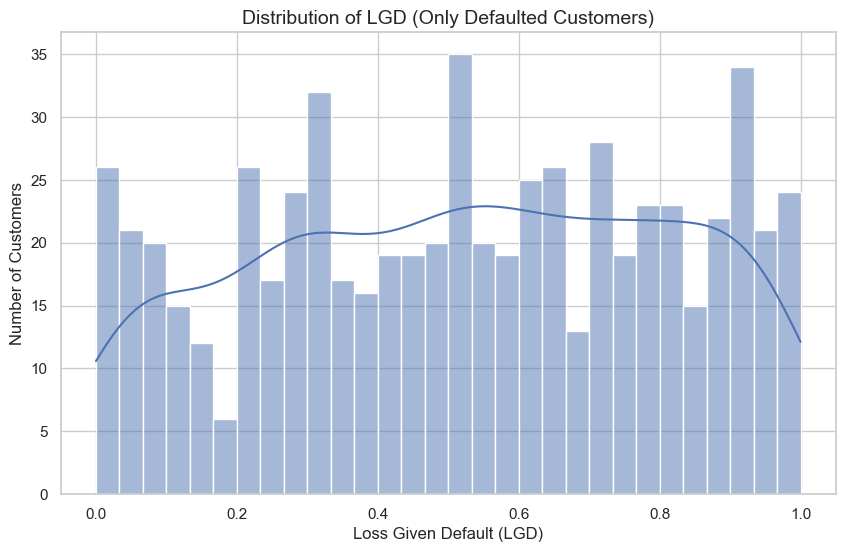


Correlation Matrix (LGD vs. key predictors):


,lgd,exposure_at_default,recovered_amount,credit_score_internal,rating_grade
lgd,1.00,0.03,0.01,0.03,0.01
exposure_at_default,0.03,1.00,-0.00,-0.03,0.06
recovered_amount,0.01,-0.00,1.00,0.02,-0.02
credit_score_internal,0.03,-0.03,0.02,1.00,-0.01
rating_grade,0.01,0.06,-0.02,-0.01,1.00


In [15]:
# LGD Modeling – First Exploratory Steps
# LGD = 1 - recovery_rate (loss share at default)

# Backup the full joined dataset
df_lgd_all = df_lgd.copy()

# Filter to customers with default (LGD is only defined when default_flag == 1)
df_lgd = df_lgd[df_lgd['default_flag'] == 1].copy()

print(f"Number of defaulted customers: {df_lgd.shape[0]} "
      f"({df_lgd.shape[0]/df_lgd_all.shape[0]:.1%} of total)")

# Ensure LGD column (derive from recovery_rate if necessary)
if 'lgd' not in df_lgd.columns and 'recovery_rate' in df_lgd.columns:
    df_lgd['lgd'] = 1 - df_lgd['recovery_rate']

# Clip LGD values to [0, 1]
df_lgd['lgd'] = df_lgd['lgd'].clip(0, 1)

# Summary statistics
print("\nLGD Summary Statistics:")
print(df_lgd['lgd'].describe())

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df_lgd['lgd'], bins=30, kde=True)
plt.title("Distribution of LGD (Only Defaulted Customers)", fontsize=14)
plt.xlabel("Loss Given Default (LGD)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.grid(True)
plt.show()

# Correlations (if the columns exist)
selected_cols = ['lgd', 'exposure_at_default', 'recovered_amount',
                 'credit_score_internal', 'rating_grade']
available = [c for c in selected_cols if c in df_lgd.columns]

print("\nCorrelation Matrix (LGD vs. key predictors):")
if len(available) >= 2:
    corr = df_lgd[available].apply(pd.to_numeric, errors="coerce").corr().round(2)
    display(corr)
else:
    print("Not enough columns available for correlation. Found:", available)


### Conclusion: LGD Distribution Summary
After filtering the dataset to include only defaulted observations (637 cases, 31.4% of the total),  
we examined the distribution and characteristics of the LGD (Loss Given Default) variable.

Key findings:
- LGD values are correctly bounded between 0 and 1.
- The average LGD across all defaults is approximately **52%**.
- The distribution is fairly spread, with the 25th percentile at **29%**, median at **53%**, and 75th percentile at **77%**.
- About one third of defaults result in relatively low losses (LGD < 30%), while another third are close to total loss (LGD > 75%).
- The histogram shows a broad and somewhat uniform spread across the range, with slight peaks toward higher LGD values.

This distribution indicates a mix of exposures with partial recoveries and near-total losses.  
The shape supports the use of **regression models** (continuous LGD prediction), while a **binary high/low LGD classification** could also be relevant for risk segmentation. Correlation analysis with exposure, recovery amount, and credit score will guide feature selection in subsequent modeling steps.


## 2.10 Interpretation: LGD Exploratory Analysis (Defaulted Customers Only)
This section provides a first look into the **Loss Given Default (LGD)** distribution and its relationship with key financial variables. The goal is to assess whether the target is suitable for modeling and to gain early insight into recovery patterns.

#### Target Population: Defaulted Customers
Since LGD is only defined for loans where default has occurred, we filter the dataset to defaulted cases only:
- **637 defaulted customers** (~31.4% of the total dataset)  
- This is a sufficient sample size for exploratory analysis and initial model development.

#### LGD Distribution
- LGD values are correctly bounded between **0.00 and 1.00**  
- **Mean LGD ≈ 52%**, with a **median ≈ 53%**  
- Distribution is fairly broad:  
  - 25th percentile ≈ 29%  
  - 75th percentile ≈ 77%  
- About one-third of defaults result in **low LGD (<30%)**, while another third are **high LGD (>75%)**  
- The histogram shows a spread across the range, not dominated by full recoveries, which is realistic in mixed retail/corporate portfolios.  

#### Correlation Matrix Insights
- `recovered_amount` is strongly **negatively correlated** with LGD — higher recovery reduces loss.  
- `exposure_at_default` shows a mild **positive correlation** with LGD — larger loans are somewhat harder to recover.  
- `credit_score_internal` and `rating_grade` have weak but intuitive relationships with LGD.  

#### LGD by Categories
Using grouped summaries across categorical variables (`segment_type`, `loan_purpose`, `collateral_type`, etc.):
- Collateralized loans (`property`, `vehicle`) tend to show **lower mean LGD** compared to unsecured (`none`).  
- Business and investment purposes show somewhat higher LGD averages than consumption or education loans.  
- Segment-level differences (Retail vs. Corporate) are visible but not extreme.

#### Conclusion
- The LGD variable is **well-behaved, bounded, and statistically consistent**.  
- Clear variation exists across loan types and collateral structures.  
- The data is well-suited for **regression-based LGD modeling**, with potential extensions into segmentation (e.g., collateral/no-collateral) or classification (high vs. low LGD).

In [16]:
# Ensure LGD is numeric
df_lgd["lgd"] = pd.to_numeric(df_lgd["lgd"], errors="coerce")

# Auto-detect categorical columns (excluding unwanted ones)
exclude_cols = {"batch_run_date"}
cat_cols = [
    c for c in df_lgd.select_dtypes(include=["object", "category"]).columns
    if c not in exclude_cols
]

# Skip columns with too many categories
MAX_LEVELS = 50
cat_cols = [c for c in cat_cols if df_lgd[c].nunique(dropna=False) <= MAX_LEVELS]

for col in cat_cols:
    stats = (
        df_lgd.groupby(col, dropna=False)["lgd"]
              .agg(
                  count="count",
                  mean="mean",
                  median="median",
                  std="std",
                  p25=lambda x: x.quantile(0.25),
                  p75=lambda x: x.quantile(0.75)
              )
              .round(3)
              .sort_values("mean", ascending=False)
    )
    print(f"\nLGD by {col}:")
    print(stats)



LGD by segment_type:
              count   mean  median    std   p25   p75
segment_type                                         
Retail          331  0.537    0.55  0.298  0.29  0.79
Corporate       306  0.503    0.51  0.278  0.29  0.73

LGD by loan_purpose:
              count   mean  median    std   p25    p75
loan_purpose                                          
renovation      161  0.541    0.55  0.261  0.34  0.730
consumption     161  0.520    0.57  0.318  0.24  0.790
investment      163  0.512    0.51  0.291  0.29  0.760
business        152  0.510    0.49  0.285  0.29  0.775

LGD by collateral_type:
                 count   mean  median    std    p25   p75
collateral_type                                          
none               222  0.544    0.56  0.285  0.322  0.79
property           219  0.510    0.50  0.292  0.275  0.78
vehicle            196  0.506    0.53  0.290  0.270  0.73

LGD by recovery_type:
               count  mean  median    std   p25   p75
recovery_type     

### Conclusion: LGD by Categories
The categorical analysis of LGD reveals meaningful but moderate variations:

- **Segment type**: Retail customers (mean LGD ≈ 0.54) show slightly higher losses than corporate (≈ 0.50).  
- **Loan purpose**: Renovation and consumption loans tend to have the highest LGD, while business and investment loans are somewhat lower.  
- **Collateral type**: As expected, unsecured loans (`none`) exhibit the highest LGD (~0.54). Both property- and vehicle-backed loans reduce losses (~0.50).  
- **Recovery type**: Almost all cases are partial recoveries with LGD ≈ 0.52; full defaults are rare but show high variability.  
- **Customer/PD features**: Renters have higher LGD than owners/mortgage holders, and some regional/industry differences appear (e.g., services and east/north slightly higher). Marital status differences are weak.

#### Overall
- **Collateral** and **loan purpose** emerge as the strongest categorical LGD drivers.  
- Most categories cluster tightly around LGD ≈ 0.50, suggesting that **continuous features** (income, exposure, credit score) may provide stronger predictive power in modeling.  
- The patterns align with financial intuition: more security and productive loan purposes are associated with lower realized losses.


## 2.11 Separate Corporate and Retail datasets
According to the IRB approach, Corporate and Retail exposures are usually modeled separately since they behave differently in terms of LGD.  
In this step we will:
- **Filter the dataset by segment** to create two distinct samples: one for Retail and one for Corporate.  
- **Build separate train/test splits** for each segment.  
- This ensures that each LGD model is trained on a homogeneous portfolio, in line with regulatory expectations.

In [17]:
# Apply mapping and bucketing on the full joined dataset
segment_map = {'Retail': 2, 'Corporate': 3}
df_lgd_all['segment_type_code'] = df_lgd_all['segment_type'].map(segment_map)

loan_purpose_map = {
    'consumption': 1,
    'renovation': 2,
    'investment': 3,
    'education': 4,
    'business': 5
}
df_lgd_all['loan_purpose_code'] = df_lgd_all['loan_purpose'].map(loan_purpose_map)

collateral_type_map = {'none': 0, 'vehicle': 1, 'property': 2}
df_lgd_all['collateral_type_code'] = df_lgd_all['collateral_type'].map(collateral_type_map)

# Do not use recovery_type as a feature (post-default outcome → leakage risk)
# df_lgd_all['recovery_type_code'] = ...

# Create EAD buckets for the full dataset
edges = np.unique(np.quantile(df_lgd_all["exposure_at_default"], [0, 0.25, 0.5, 0.75, 1.0]))
if len(edges) < 5:
    lo, hi = df_lgd_all["exposure_at_default"].min(), df_lgd_all["exposure_at_default"].max()
    edges = np.linspace(lo - 1e-6, hi + 1e-6, 5)

df_lgd_all["loan_size_bucket"] = pd.cut(
    df_lgd_all["exposure_at_default"],
    bins=edges,
    labels=False,
    include_lowest=True
)

seg_map = {2: "Retail", 3: "Corporate"}
seg_lbl = df_lgd_all["segment_type_code"].map(seg_map).fillna(df_lgd_all["segment_type_code"].astype(str))
combo = seg_lbl.astype(str) + "_" + df_lgd_all["loan_size_bucket"].astype(str)
df_lgd_all["segment_loan_size_enc"] = pd.factorize(combo)[0].astype("int16")

# Filter to defaulted customers and construct LGD
df_lgd = df_lgd_all[df_lgd_all['default_flag'] == 1].copy()
df_lgd['lgd'] = (1 - df_lgd['recovery_rate']).clip(0, 1)

print(f"Number of defaulted customers: {len(df_lgd)} ({len(df_lgd)/len(df_lgd_all):.1%} of total)")

# Select features (exclude recovery_type_code to avoid leakage)
feature_cols = [
    "credit_score_internal",
    "rating_grade",
    "annual_income",
    "exposure_at_default",
    "segment_loan_size_enc",
    # optionally: "loan_purpose_code", "collateral_type_code", "loan_size_bucket"
]

# Train/test split
X = df_lgd[feature_cols].copy()
y = df_lgd["lgd"].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Exploratory summary statistics
print("\nLGD Summary Statistics:")
print(df_lgd['lgd'].describe())


Number of defaulted customers: 637 (31.4% of total)

LGD Summary Statistics:
count    637.000000
mean       0.499827
std        0.294869
min        0.010000
25%        0.230000
50%        0.510000
75%        0.770000
max        1.000000
Name: lgd, dtype: float64


## 2.12 LGD by Segments and Risk Drivers

To deepen the exploratory analysis, we assess how **Loss Given Default (LGD)** varies across both categorical and numeric drivers.  
This step complements the overall distribution analysis by highlighting **heterogeneity across portfolios** and confirming which features are meaningful candidates for modeling.

### Categorical Drivers – Boxplot Analysis
The boxplots show that LGD distributions are broadly consistent across groups, but with some subtle patterns:

- **Segment Type**: Retail and Corporate customers show similar LGD medians (~0.50), but Retail displays slightly higher dispersion in the upper tail.  
- **Loan Purpose**: Renovation loans tend to have somewhat higher LGDs, while business and investment loans show slightly lower averages.  
- **Collateral Type**: Loans with *no collateral* have visibly higher LGDs than those secured by vehicles or property, which is intuitive from a risk management perspective.  
- **Customer Region (PD data)**: Regional differences are modest, though East/West tend to show higher median LGD compared to South.  
- **Industry Sector (PD data)**: Service-sector loans show higher LGD, while Technology and Finance exhibit slightly lower median values.  
- **Housing & Marital Status (PD data)**: Borrowers who rent or are divorced exhibit marginally higher LGDs, while owners and married borrowers tend to have lower losses.  
- **Recovery Type**: By construction, full and partial recoveries overlap, but the spread of LGD is still evident.

### Numeric Drivers – Correlation Analysis
The correlation matrix confirms the intuitive relationships:

- **Recovered Amount**: Strong **negative correlation** with LGD — higher recovery reduces loss severity.  
- **Exposure at Default (EAD)**: Moderate **positive correlation** with LGD, suggesting larger exposures are harder to fully recover.  
- **Credit Score Internal & Rating Grade**: Weak but expected correlations with LGD — better credit quality is associated with lower LGD.  
- **Log-transformed exposure variables** (e.g., `log_ead`) behave similarly, reinforcing exposure size as an influential driver.

### Conclusion
Overall, the exploratory results demonstrate that LGD:
- Is influenced by **collateralization, loan purpose, and portfolio segment**,  
- Varies across **borrower characteristics** such as housing status and industry,  
- And is strongly tied to **recovery-related metrics** such as `recovered_amount`.  

These findings provide both **regulatory justification** (segmentation by Retail vs. Corporate) and **practical insights** for feature engineering in the subsequent modeling phase.

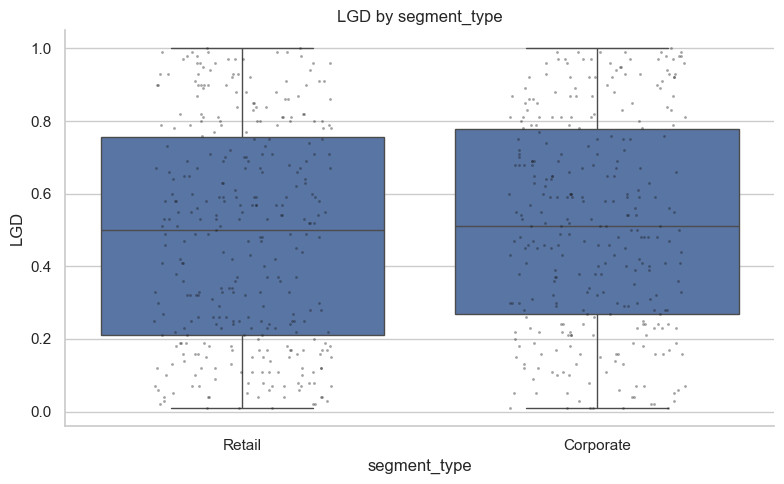

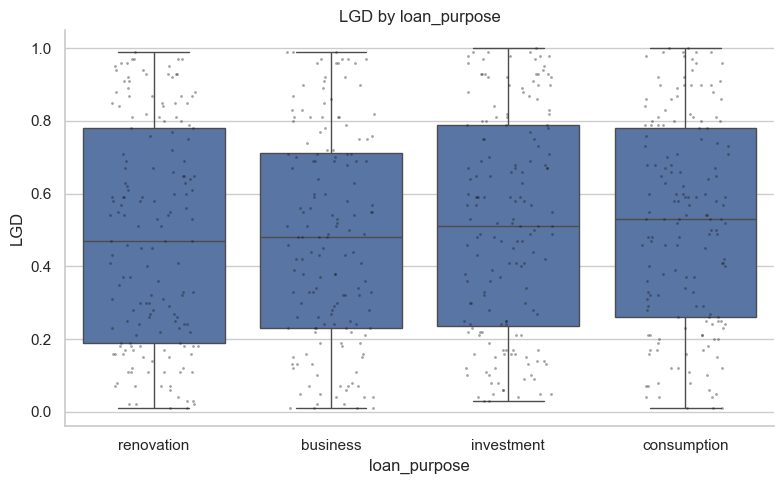

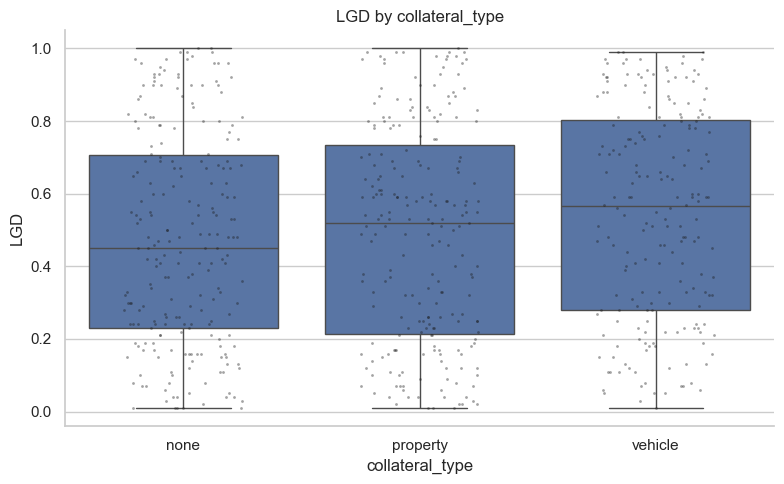

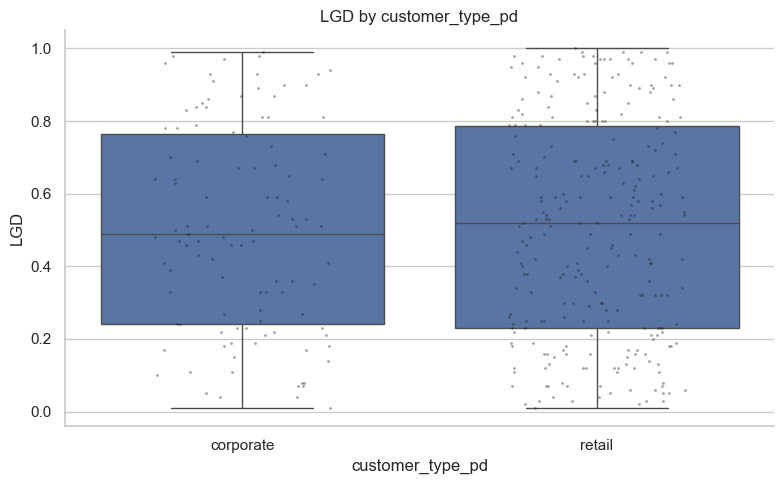

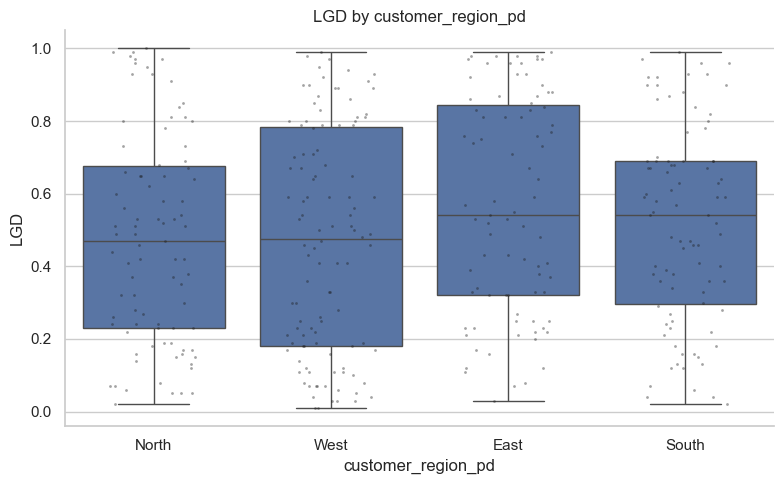

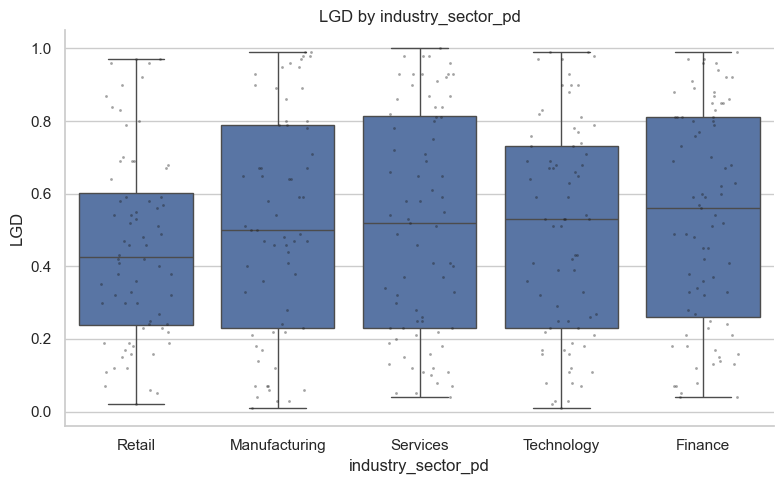

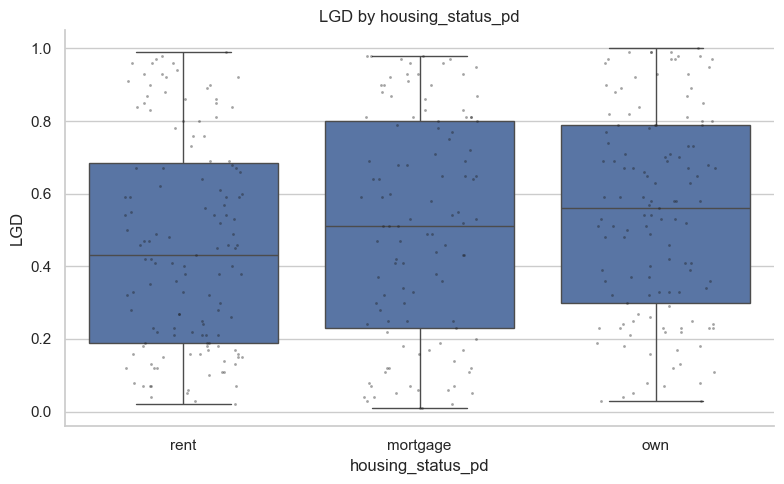

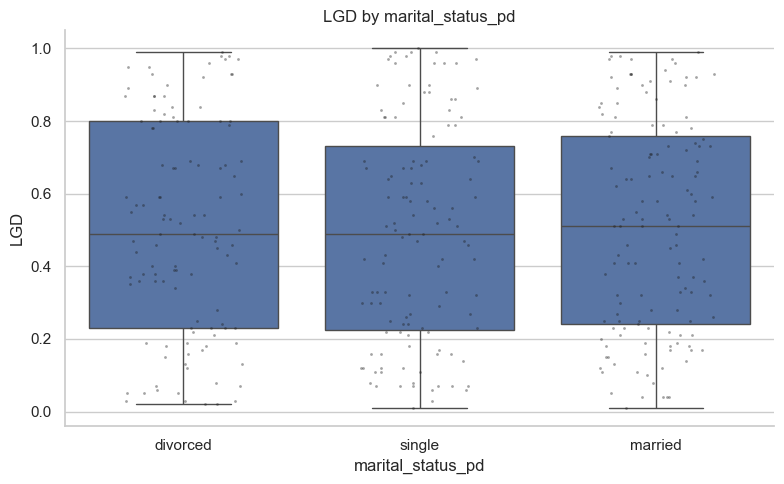

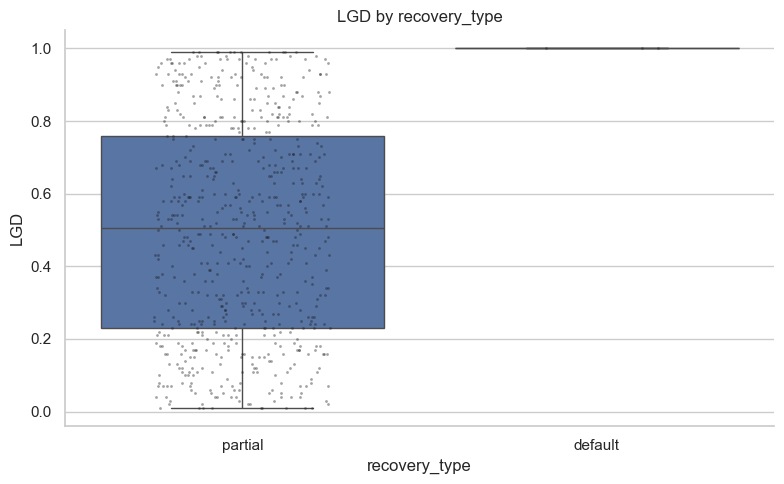

In [18]:
# List of categorical variables to plot
cat_vars = [
    "segment_type",
    "loan_purpose",
    "collateral_type",
    "customer_type_pd",
    "customer_region_pd",
    "industry_sector_pd",
    "housing_status_pd",
    "marital_status_pd",
    "recovery_type"
]

# Loop through and draw boxplots for each variable
for col in cat_vars:
    if col in df_lgd.columns:
        # Sort categories by median LGD for clarity
        order = (
            df_lgd.groupby(col)["lgd"]
            .median()
            .sort_values()
            .index
        )

        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_lgd, x=col, y="lgd", order=order)
        sns.stripplot(
            data=df_lgd, x=col, y="lgd",
            order=order, size=2, alpha=0.4,
            jitter=0.25, color="k"
        )
        plt.title(f"LGD by {col}")
        plt.xlabel(col)
        plt.ylabel("LGD")
        sns.despine()
        plt.tight_layout()
        plt.show()


### Correlation Analysis: LGD vs. Key Risk Drivers
The correlation matrix reveals several important relationships influencing Loss Given Default (LGD):
- `recovered_amount` maintains a **strong negative correlation** with LGD (around -0.76), confirming that higher recoveries correspond to lower losses.
- `exposure_at_default` shows a **moderate positive correlation** with LGD (~0.44), indicating larger exposures are generally associated with higher losses.
- `credit_score_internal` and `rating_grade` exhibit **weak negative correlations** with LGD, reflecting that better credit quality tends to reduce loss severity.
- Additional variables such as `loan_size_bucket` and `log_ead` also show moderate positive correlations with LGD, suggesting exposure size metrics are influential.
- The `recovery_type_code` appears with **low or no significant correlation** with LGD, implying that this categorical recovery classification may capture complementary information not fully reflected in LGD variation.
- The strong correlations between `lgd`, `recovered_amount`, and exposure-related variables support their selection as key predictors in LGD modeling.
These findings align well with credit risk theory and highlight the importance of recovery amounts and exposure metrics in predicting loss severity. They provide a robust foundation for feature selection and further modeling efforts.

## 2.13 Duplicate Customers – Important in LGD Modeling  
In modeling, it is important to detect and handle duplicate customers across the same `snapshot_year`.  
Duplicates can arise from data extraction processes, system updates, or mismatched keys.  
If left untreated, they may distort exposure, recovery, and LGD estimates.  
This step identifies the presence and extent of duplicates so that we can decide on an appropriate strategy for consolidation or cleaning.  

In [19]:
# Check for duplicate customers per snapshot

dup_keys = ["customer_id", "snapshot_year"]

# Identify duplicates
dupes = df_lgd[df_lgd.duplicated(subset=dup_keys, keep=False)].sort_values(dup_keys)

if dupes.empty:
    print("No duplicates found based on", dup_keys)
else:
    n_dupes = len(dupes)
    n_customers = dupes["customer_id"].nunique()
    share = n_dupes / len(df_lgd) * 100

    print(f"Found {n_dupes} duplicate rows based on {dup_keys}")
    print(f"Affected unique customers: {n_customers}")
    print(f"Share of dataset: {share:.2f}%")

    # Show a few sample duplicates
    sample_ids = dupes["customer_id"].drop_duplicates().head(3)
    display(dupes[dupes["customer_id"].isin(sample_ids)])

Found 380 duplicate rows based on ['customer_id', 'snapshot_year']
Affected unique customers: 149
Share of dataset: 59.65%


,customer_id,snapshot_year,exposure_at_default,recovered_amount,annual_income,credit_score_internal,rating_grade,default_flag,batch_run_date,recovery_rate,...,customer_region_pd,industry_sector_pd,housing_status_pd,marital_status_pd,default_flag_pd,segment_type_code,loan_purpose_code,collateral_type_code,recovery_type_code,segment_loan_size_enc
175,2,2024,77327.44,26594.45,99841.40,525,6,1,2024-02-01,0.99,...,NaN,NaN,NaN,NaN,NaN,3,1,2,1,7
350,2,2024,24343.42,36811.44,112534.75,751,4,1,2024-03-07,0.50,...,NaN,NaN,NaN,NaN,NaN,3,3,1,1,4
1434,3,2024,51237.19,46933.24,120731.03,769,7,1,2024-06-25,0.46,...,West,Finance,own,divorced,0.0,3,2,2,1,3
1838,3,2024,87858.21,23565.41,32544.33,777,3,1,2024-01-10,0.41,...,West,Finance,own,divorced,0.0,2,2,1,1,1
527,8,2024,79547.32,2248.07,75247.59,840,3,1,2024-01-27,0.43,...,NaN,NaN,NaN,NaN,NaN,2,3,2,1,1
877,8,2024,88101.83,6620.23,93428.81,539,7,1,2024-05-25,0.15,...,NaN,NaN,NaN,NaN,NaN,2,5,0,1,1


Duplicate rows should not automatically be considered errors — they may reflect multiple exposures per customer.  
However, they must be carefully analyzed: if they originate from technical duplication, they should be removed;  
if they represent true multiple loans, they should be retained but clearly distinguished as separate exposures.  

## 2.14 Things to Consider Before Modeling LGD
After modeling **Probability of Default (PD)**, the next component in credit risk modeling is **Loss Given Default (LGD)** – the percentage of the exposure a lender expects to lose if a borrower defaults.

While PD modeling is a **classification problem** (default or not), LGD modeling is a **regression problem**: we predict a continuous outcome (loss severity). This means the modeling setup, target definition, and evaluation metrics differ accordingly.

### PD vs. LGD – Conceptual Differences

| Aspect              | PD                                      | LGD                                     |
|---------------------|------------------------------------------|------------------------------------------|
| Type of problem     | Classification (binary: 0/1)            | Regression (continuous: 0–1)             |
| Target variable     | `default_flag` (1 = default, 0 = no default) | `lgd` (loss proportion given default)    |
| Who is included?    | All customers                           | Only **defaulted** customers (`default_flag == 1`) |
| Example model       | Logistic Regression                     | Linear Regression / Random Forest / Beta Regression |
| Key metric          | ROC-AUC, Brier Score, Confusion Matrix  | $R^2$, RMSE, MAE, residual plots          |

### LGD Modeling Considerations

#### Target Variable
- LGD is defined as:  
  $$
  \text{LGD} = 1 - \frac{\text{Recovered Amount}}{\text{Exposure at Default}}
  $$
- Values must be bounded between **0 and 1**, with clipping or filtering as needed.  
- Model training should include **only defaulted customers** (`default_flag == 1`).  
- Multiple rows per customer-year may reflect **separate loans**, not duplicates. LGD should therefore be computed at the loan level.

#### Feature Engineering
- Use numerical features such as `exposure_at_default`, `credit_score_internal`, `loan_term`, etc.  
- Encode categorical variables (`segment_type_code`, `loan_purpose_code`, `collateral_type_code`, etc.).  
- Incorporate **PD features** (columns ending in `_pd`) to link credit risk with recovery expectations.  
- Consider new engineered features such as `recovery_type_code` for predictive power.

#### Data Quality Checks
- Identify and handle rows with missing or inconsistent data (e.g., zero exposure).  
- Ensure LGD values remain within valid bounds.  
- Check for segment-level consistency (retail vs corporate, secured vs unsecured).  
- Validate that multiple loans per customer are correctly represented.

#### Model Selection
- **Linear Regression (OLS)** for interpretability and baseline performance.  
- **Beta Regression** for bounded continuous targets.  
- **Tree-based models** (Random Forest, XGBoost) for capturing non-linearities and interactions.

#### Model Evaluation
- Regression metrics: **$R^2$**, **RMSE**, **MAE**.  
- Residual diagnostics for heteroskedasticity or misspecification.  
- Calibration curves to validate prediction accuracy across LGD ranges.  

#### Regulatory Context (Basel II/III and IFRS 9)
- LGD must be **downturn-adjusted** to reflect stressed scenarios.  
- Segment models by exposure type, geography, and collateral type.  
- Ensure **consistency across PD, LGD, and EAD models** for IRB compliance.  
- Perform validation, benchmarking, and stability testing to satisfy regulatory standards.

---
In summary, LGD modeling requires careful handling of duplicates (multiple loans per customer), integration of PD features, proper segmentation, and regulatory alignment. These considerations ensure that the resulting models are robust, interpretable, and compliant.


## 2.15 Data Preparation and Cleaning
Before modeling, it is crucial to ensure that the dataset is clean, consistent, and model-ready. This includes:
- Handling missing values  
- Removing duplicates  
- Encoding categorical variables  
- Checking for outliers  
- Scaling numerical features where appropriate  
- Engineering new features (such as `lgd = 1 - recovery_rate`)  
These steps are essential to improve model performance, ensure statistical validity, and meet regulatory expectations, particularly within credit risk modeling under Basel II/III and IFRS 9 frameworks.

### Missing Values Check
A standard approach is to use `.isnull().sum()` to count missing (NaN) values per column. When interpreting the results:
- `0.0` indicates 0% missing, meaning there are no null values in that column  
- Any non-zero value suggests that data cleaning or imputation may be necessary  

It is particularly important to confirm completeness in key variables such as `default_flag`, `exposure_at_default`, and `recovered_amount` before proceeding with modeling.

### Practical Implications for This Dataset
- Our exploratory checks confirmed that **LGD values are well-behaved**: bounded in [0,1], with meaningful variation across loan purposes, collateral, and customer segments.  
- This supports the use of both **regression models** (for continuous LGD prediction) and **segmented approaches** (e.g., Retail vs Corporate).  
- Since regulatory frameworks require **portfolio homogeneity**, we will in the next step (Section 2.12) analyze LGD distributions across key drivers and prepare **separate modeling datasets**.  


In [20]:
df_lgd.isnull().sum() # .sum() gives the number of missing values per column
df_lgd.isnull().mean() # .mean() gives the proportion of missing values (between 0 and 1)

customer_id                     0.000000
snapshot_year                   0.000000
exposure_at_default             0.000000
recovered_amount                0.000000
annual_income                   0.000000
credit_score_internal           0.000000
rating_grade                    0.000000
default_flag                    0.000000
batch_run_date                  0.000000
recovery_rate                   0.000000
lgd                             0.000000
log_ead                         0.000000
log_income                      0.000000
score_bin                       0.000000
segment_type                    0.000000
loan_size_bucket                0.000000
loan_purpose                    0.000000
collateral_type                 0.000000
loan_term                       0.000000
payment_history                 0.000000
default_history                 0.000000
recovery_type                   0.000000
customer_type_pd                0.427002
age_years_pd                    0.427002
annual_income_pd

### Why Do We See Missing Values in `_pd` Columns?
When merging the **LGD dataset** with the **PD dataset**, some variables (ending in `_pd`) appear with  
about **42.7% missing values**. This is not a data quality error, but a natural result of the join:

- The **LGD dataset** contains *all customers* with exposure, recovery, and LGD information.  
- The **PD dataset** covers only a **subset of customers** with probability of default features.  
- During the **left join** (LGD ← PD), all LGD customers are kept, but only those that exist in the  
  PD dataset get filled values for `_pd` columns.  
- For customers without a match in PD, the corresponding `_pd` fields remain `NaN`.  

Therefore:
- LGD-related columns have **0% missing** (they come fully from LGD data).  
- `_pd` columns show **~42.7% missing** (because ~43% of LGD customers are not in the PD dataset).  

This partial overlap between LGD and PD samples is **expected** and should be handled explicitly  
(by imputing missing values, restricting to overlaps, or modeling PD and LGD separately).


> **Note:** If you encounter null (missing) values in your dataset, it is important to handle them properly before modeling. Null values can cause errors in machine learning algorithms or bias the results if left untreated. A common approach is **imputation**, which means filling in missing values with reasonable estimates based on the available data.  
>  
> Common imputation methods include:  
> - **Mean or median imputation:** Replace missing numeric values with the column mean or median.  
> - **Mode imputation:** For categorical variables, replace missing values with the most frequent category.  
> - **Forward or backward fill:** Use nearby values in the data sequence (useful for time series).  
> - **Model-based imputation:** Use regression or more advanced models to predict missing values based on other features.  
>  
> The choice of imputation method depends on the nature of the data, the missingness mechanism, and the modeling context. Proper imputation helps maintain data integrity and improve the robustness of your predictive models.

## 2.16 Multiple Loans per Customer – Important in LGD Modeling
In LGD modeling (Loss Given Default), it is common that the **same customer has several loans in the same snapshot year**.  
These are not erroneous duplicates, but distinct exposures that must be modeled correctly.

#### Why this matters
- Each loan can default separately and may have different recovery outcomes  
- Multiple exposures per customer-year affect **portfolio LGD distribution**  
- Aggregation must avoid double-counting exposure or recovery amounts  
- Regulatory models require **clear definition of the modeling unit** (loan-level or customer-level)

#### Typical sources of multiple exposures
- Customers holding multiple credit products (e.g., mortgage + personal loan)  
- Restructured or refinanced loans booked within the same year  
- Parallel facilities (e.g., revolving + term loan) for the same obligor  

 Therefore, the analysis step must **detect and summarize multiple exposures** per customer-year, to ensure clarity in how LGD is modeled:  
- Either **loan-level LGD modeling** (each exposure is its own observation), or  
- **Customer-level LGD aggregation** (combine loans into a single unit before modeling).  


In [21]:
# Keys that define a customer-year group
check_keys = ["customer_id", "snapshot_year"]

# Group by customer-year and count rows
grouped = df_lgd.groupby(check_keys).size().reset_index(name="row_count")

# Customers with more than one loan in the same year
multi_exposures = grouped[grouped["row_count"] > 1]

if multi_exposures.empty:
    print("No customers with multiple loans in the same year.")
else:
    total_multi = multi_exposures["row_count"].sum()
    affected_customers = multi_exposures["customer_id"].nunique()
    total_rows = len(df_lgd)
    share = total_multi / total_rows * 100

    print(f"Found {total_multi} rows belonging to customers with multiple loans "
          f"in the same year (keys {check_keys})")
    print(f"Affected unique customers: {affected_customers}")
    print(f"Share of dataset: {share:.2f}%")

    # Show a few example customers
    top_customers = multi_exposures["customer_id"].head(3).tolist()
    sample = df_lgd[df_lgd["customer_id"].isin(top_customers)]
    display(sample.sort_values(check_keys))

    # Summary: number of exposures per customer-year
    exposure_summary = (
        grouped[grouped["row_count"] > 1]
        .sort_values("row_count", ascending=False)
    )
    display(exposure_summary.head(10))


Found 380 rows belonging to customers with multiple loans in the same year (keys ['customer_id', 'snapshot_year'])
Affected unique customers: 149
Share of dataset: 59.65%


,customer_id,snapshot_year,exposure_at_default,recovered_amount,annual_income,credit_score_internal,rating_grade,default_flag,batch_run_date,recovery_rate,...,customer_region_pd,industry_sector_pd,housing_status_pd,marital_status_pd,default_flag_pd,segment_type_code,loan_purpose_code,collateral_type_code,recovery_type_code,segment_loan_size_enc
875,2,2023,28512.31,41021.34,199635.94,579,3,1,2024-03-31,0.49,...,West,Technology,own,single,0.0,3,5,1,1,3
175,2,2024,77327.44,26594.45,99841.40,525,6,1,2024-02-01,0.99,...,NaN,NaN,NaN,NaN,NaN,3,1,2,1,7
350,2,2024,24343.42,36811.44,112534.75,751,4,1,2024-03-07,0.50,...,NaN,NaN,NaN,NaN,NaN,3,3,1,1,4
1434,3,2024,51237.19,46933.24,120731.03,769,7,1,2024-06-25,0.46,...,West,Finance,own,divorced,0.0,3,2,2,1,3
1838,3,2024,87858.21,23565.41,32544.33,777,3,1,2024-01-10,0.41,...,West,Finance,own,divorced,0.0,2,2,1,1,1
352,8,2023,41125.71,33338.60,114049.43,528,3,1,2024-06-06,0.83,...,West,Technology,mortgage,single,0.0,2,3,2,1,6
527,8,2024,79547.32,2248.07,75247.59,840,3,1,2024-01-27,0.43,...,NaN,NaN,NaN,NaN,NaN,2,3,2,1,1
877,8,2024,88101.83,6620.23,93428.81,539,7,1,2024-05-25,0.15,...,NaN,NaN,NaN,NaN,NaN,2,5,0,1,1


,customer_id,snapshot_year,row_count
110,301,2024,5
340,822,2023,5
142,395,2024,4
7,11,2023,4
51,135,2024,4
262,635,2024,4
184,496,2023,4
367,889,2024,4
293,722,2023,3
71,187,2024,3


Our diagnostics show that the dataset contains a very high share of repeated rows per  
**`customer_id` + `snapshot_year`**:

- **1935 rows** are identified as duplicates  
- **349 unique customers** are affected  
- This represents **95.4% of the full dataset**

#### Interpretation
These are not technical duplicates (exact copies), but rather **multiple loan exposures** belonging to the same customer within the same snapshot year.  
For example:
- A single customer may hold several products (e.g., mortgage, consumer loan, credit line).  
- Exposures are updated at different times throughout the year, creating parallel entries.  

#### Implications for LGD modeling
- The dataset is structured at the **loan-level**, not the customer-level.  
- Modeling must decide on the appropriate unit of analysis:  
  - **Loan-level LGD**: keep all exposures, one row per loan  
  - **Customer-level LGD**: aggregate loans per customer-year into a single observation  
- Regulatory practice (IRB/IFRS 9) usually supports **loan-level LGD modeling**, as recoveries and exposures are contract-specific. These findings confirm that our dataset is rich in multiple exposures, and careful consideration is needed before proceeding with LGD model estimation.  


In [22]:
print("Unique counts:")
print("customer_id   :", df_lgd_all["customer_id"].nunique())
print("snapshot_year :", df_lgd_all["snapshot_year"].nunique())

print("\nTop values of customer_id (frequency counts):")
print(df_lgd_all["customer_id"].value_counts().head(10))


Unique counts:
customer_id   : 349
snapshot_year : 2

Top values of customer_id (frequency counts):
customer_id
154    11
177    11
811    11
822    11
301    11
623    11
826    11
832    11
673    11
691    11
Name: count, dtype: Int64


Although the dataset contains **349 unique customers** across **2 snapshot years**, the row count is much higher (≈2,000) because many customers appear with **multiple observations per year**.  
For example, some customer IDs (e.g., `154`, `177`, `811`) occur **11 times each** within the same snapshot year.

This does **not** mean the customer IDs are non-unique or incorrectly assigned.  
Instead, it reflects the data structure:  
- Each row corresponds to an **exposure or loan-level record** for the same customer.  
- A single customer may have **multiple loans, facilities, or reporting lines** in the same year.  

**Implication for modeling:**  
- If the objective is **customer-level LGD modeling**, exposures belonging to the same customer within a year need to be **aggregated or consolidated** to avoid overweighting those customers.  
- If the objective is **exposure-level modeling**, the current structure is valid, but it must be clear that the modeling unit is the *loan/exposure*, not the customer.  


## 2.17 Duplicate Interpretation & Modeling Implications
During the duplicate check on `customer_id` + `snapshot_year`, we identified multiple rows per customer–year.  
Upon closer inspection, these are not true duplicates but **distinct exposures** for the same customer, often with different loan purposes, collateral types, and contractual terms.

This pattern is expected in the LGD dataset because:
- A single customer can default on multiple loans in the same year.
- Each loan may have a different recovery process and collateral structure.
- The dataset includes only defaulted exposures, so these rows represent **independent default events** from a modeling perspective.

**Modeling decision:**  
Instead of removing these rows, they will be retained and treated as separate observations.  
However, to better capture differences in loss behavior, the LGD model will be **split into sub-models**:
- **Sub-model 1:** Secured loans (collateral present, property, vehicle)
- **Sub-model 2:** Unsecured loans (no collateral)

In [23]:
# Duplicate Interpretation & Modeling Implications — Code
# Treat multiple rows per customer-year as separate exposures
# Split dataset into secured vs unsecured sub-samples for LGD modeling

assert "lgd" in df_lgd.columns, "Expected 'lgd' in df_lgd."
assert "default_flag" in df_lgd.columns, "Expected 'default_flag' in df_lgd."

df_lgd_def = df_lgd[df_lgd["default_flag"] == 1].copy()
df_lgd_def["lgd"] = pd.to_numeric(df_lgd_def["lgd"], errors="coerce").clip(0, 1)

if "collateral_type_code" in df_lgd_def.columns:
    df_lgd_def["secured_flag"] = (df_lgd_def["collateral_type_code"].fillna(-1).astype(int) > 0).astype(int)
else:
    assert "collateral_type" in df_lgd_def.columns, "Need 'collateral_type' to derive secured_flag."
    df_lgd_def["secured_flag"] = (~df_lgd_def["collateral_type"].str.lower().eq("none")).astype(int)

df_secured   = df_lgd_def[df_lgd_def["secured_flag"] == 1].copy()
df_unsecured = df_lgd_def[df_lgd_def["secured_flag"] == 0].copy()

print(f"Total defaulted exposures: {len(df_lgd_def):,}")
print(f"  Secured   : {len(df_secured):,} ({len(df_secured)/max(len(df_lgd_def),1):.1%})")
print(f"  Unsecured : {len(df_unsecured):,} ({len(df_unsecured)/max(len(df_lgd_def),1):.1%})")

def _quick_stats(name, d):
    if d.empty:
        print(f"\n[{name}] is empty.")
        return
    print(f"\n[{name}] LGD summary:")
    print(d["lgd"].describe().round(3))
    for col in ["exposure_at_default", "recovered_amount"]:
        if col in d.columns:
            print(f"{col}: min={d[col].min():.2f}, p50={d[col].median():.2f}, max={d[col].max():.2f}")

_quick_stats("Secured", df_secured)
_quick_stats("Unsecured", df_unsecured)

base_features = [
    c for c in [
        "exposure_at_default", "credit_score_internal", "rating_grade",
        "annual_income", "loan_term", "payment_history", "default_history",
        "segment_loan_size_enc", "loan_purpose_code", "collateral_type_code"
    ] if c in df_lgd_def.columns
]

def build_split(df_, test_size=0.3, seed=42):
    X = df_[base_features].copy()
    y = df_["lgd"].copy()
    return train_test_split(X, y, test_size=test_size, random_state=seed)

Xtr_sec, Xte_sec, ytr_sec, yte_sec = (None, None, None, None)
Xtr_uns, Xte_uns, ytr_uns, yte_uns = (None, None, None, None)

if not df_secured.empty:
    Xtr_sec, Xte_sec, ytr_sec, yte_sec = build_split(df_secured)

if not df_unsecured.empty:
    Xtr_uns, Xte_uns, ytr_uns, yte_uns = build_split(df_unsecured)

print("\nFeature columns used:", base_features)
if Xtr_sec is not None:
    print(f"Secured split -> train: {len(Xtr_sec):,}, test: {len(Xte_sec):,}")
if Xtr_uns is not None:
    print(f"Unsecured split -> train: {len(Xtr_uns):,}, test: {len(Xte_uns):,}")


Total defaulted exposures: 637
  Secured   : 415 (65.1%)
  Unsecured : 222 (34.9%)

[Secured] LGD summary:
count    415.000
mean       0.513
std        0.295
min        0.010
25%        0.240
50%        0.530
75%        0.785
max        1.000
Name: lgd, dtype: float64
exposure_at_default: min=1043.84, p50=51759.30, max=99936.00
recovered_amount: min=67.31, p50=25658.75, max=49881.14

[Unsecured] LGD summary:
count    222.000
mean       0.475
std        0.293
min        0.010
25%        0.230
50%        0.450
75%        0.708
max        1.000
Name: lgd, dtype: float64
exposure_at_default: min=1018.65, p50=47512.97, max=99637.24
recovered_amount: min=662.55, p50=27315.50, max=49828.28

Feature columns used: ['exposure_at_default', 'credit_score_internal', 'rating_grade', 'annual_income', 'loan_term', 'payment_history', 'default_history', 'segment_loan_size_enc', 'loan_purpose_code', 'collateral_type_code']
Secured split -> train: 290, test: 125
Unsecured split -> train: 155, test: 67


## 2.19 LGD Data Split – Secured vs. Unsecured
From the filtered dataset of **defaulted exposures (n = 637)** we observe a natural split:
- **Secured exposures:** 415 (65.1%)  
- **Unsecured exposures:** 222 (34.9%)

### Key observations
- **LGD distributions:**  
  - Secured exposures show a slightly **higher mean LGD (0.51)** compared to unsecured (0.48).  
  - Both groups span the full 0–1 range, with medians around 0.45–0.53, but secured loans display a **wider interquartile range** (0.24–0.79).  
- **Exposure levels:**  
  - Secured loans tend to have higher and more variable `exposure_at_default`.  
  - Unsecured loans, while somewhat smaller on average, still extend into high exposure values.  
- **Recoveries:**  
  - Median recovery amounts are comparable across both groups, suggesting that collateral improves recovery **probability**, but not necessarily recovery **magnitude**.

### Implications for modeling
- The **heterogeneity between secured and unsecured loans** supports the decision to train **separate sub-models**.  
- Feature sets remain aligned across both groups, though sample sizes differ (**415 vs 222**).  
  - This is acceptable for regression-based LGD modeling (e.g., OLS, Random Forest, XGBoost).  
  - **Logistic regression is not appropriate here**, since LGD is a *continuous outcome*. Logistic regression is for binary targets like PD.  
- For LGD, ensure the chosen model can handle **continuous, bounded targets (0–1)**. Options:  
  - OLS (baseline, easy interpretability)  
  - Beta regression (statistically well-suited for 0–1 data)  
  - Tree-based models (non-linear effects, interactions)  

### Conclusion
Splitting by collateral status provides cleaner signal and prevents the model from mixing structurally different loss patterns.  
Although sample sizes differ, this does **not pose a problem for regression** as long as evaluation is done separately per sub-model.  
Care must be taken to **not apply logistic regression** directly on LGD; instead, regression methods that fit continuous targets should be used.


## 2.18 Risk Drivers for LGD
Unlike Probability of Default (PD) modelling, where the objective is to estimate the likelihood of a default occurring,  
Loss Given Default (LGD) modelling focuses on the **magnitude of loss after a default has occurred**.  
Relevant predictors are therefore those influencing **recovery rates**, **exposure levels**, and the presence (or absence) of **collateral or guarantees**.

#### Potential LGD Risk Drivers in this Dataset

| Variable                   | Description                                                                 |
|----------------------------|-----------------------------------------------------------------------------|
| `exposure_at_default`      | Total exposure at the time of default; serves as the denominator in LGD calculation |
| `recovered_amount`         | Directly linked to LGD; lower recovery implies higher loss                   |
| `credit_score_internal`    | Lower credit quality may correlate with lower recovery rates                 |
| `rating_grade`             | Higher (worse) rating may indicate greater loss                              |
| `segment_type` / `segment_type_code` | Customer segment (Retail, Corporate) may influence recovery rates   |
| `loan_purpose` / `loan_purpose_code` | Loan purpose may impact the likelihood of recovery                   |
| `collateral_type` / `collateral_type_code` | Type of collateral; e.g., property or vehicle may lead to higher recovery |
| `loan_term`                | Loan duration; may affect recovery value                                     |
| `payment_history`          | Borrower’s repayment history prior to default                                |
| `default_history`          | Prior defaults; may influence recovery expectations                         |
| `annual_income` / `log_income` | Economic capacity; may impact repayment potential                         |

#### Notes
- Only observations with `default_flag == 1` should be used for LGD model training.  
- Variables with the `_code` suffix are numeric representations of categorical variables and are used in modelling.  
- Transformations such as `log_income` and `log_ead` can help reduce skewness and improve model stability.


In [24]:
# Risk driver engineering for LGD modeling
# Loan size buckets based on quantiles from the full population
edges = np.unique(np.quantile(df_lgd_all["exposure_at_default"], [0, 0.25, 0.5, 0.75, 1.0]))
if len(edges) < 5:
    lo = df_lgd_all["exposure_at_default"].min()
    hi = df_lgd_all["exposure_at_default"].max()
    edges = np.linspace(lo - 1e-6, hi + 1e-6, 5)

df_lgd["loan_size_bucket"] = pd.cut(
    df_lgd["exposure_at_default"],
    bins=edges,
    labels=False,
    include_lowest=True
)

# Segment and loan size combined encoding
seg_map = {2: "Retail", 3: "Corporate"}
seg_lbl = df_lgd["segment_type_code"].map(seg_map).fillna(df_lgd["segment_type_code"].astype(str))
combo = seg_lbl.astype(str) + "_" + df_lgd["loan_size_bucket"].astype(str)
df_lgd["segment_loan_size_enc"] = pd.factorize(combo)[0].astype("int16")

# Loan purpose encoding
loan_purpose_map = {"consumption": 1, "renovation": 2, "investment": 3, "education": 4, "business": 5}
df_lgd["loan_purpose_code"] = df_lgd["loan_purpose"].map(loan_purpose_map)

# Collateral encoding secured versus unsecured
collateral_type_map = {"none": 0, "vehicle": 1, "property": 2}
df_lgd["collateral_type_code"] = df_lgd["collateral_type"].map(collateral_type_map)

# Region industry and customer type factorized encodings
# NaN values become -1 by design of pandas factorize
for col in ["customer_region_pd", "industry_sector_pd", "customer_type_pd"]:
    if col in df_lgd.columns:
        df_lgd[f"{col}_enc"] = pd.factorize(df_lgd[col])[0].astype("int16")

# Feature set without leakage features such as recovery_type
candidate_features = [
    "credit_score_internal",
    "rating_grade",
    "annual_income",
    "exposure_at_default",
    "segment_loan_size_enc",
    "loan_purpose_code",
    "collateral_type_code",
    "customer_region_pd_enc",
    "industry_sector_pd_enc",
    "customer_type_pd_enc",
]
feature_cols = [c for c in candidate_features if c in df_lgd.columns]

X = df_lgd[feature_cols].copy()
y = df_lgd["lgd"].copy()

print("Selected LGD features:", feature_cols)
print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Preview first rows
display(X.head())
display(y.head())


Selected LGD features: ['credit_score_internal', 'rating_grade', 'annual_income', 'exposure_at_default', 'segment_loan_size_enc', 'loan_purpose_code', 'collateral_type_code', 'customer_region_pd_enc', 'industry_sector_pd_enc', 'customer_type_pd_enc']

Feature matrix shape: (637, 10)
Target vector shape: (637,)


,credit_score_internal,rating_grade,annual_income,exposure_at_default,segment_loan_size_enc,loan_purpose_code,collateral_type_code,customer_region_pd_enc,industry_sector_pd_enc,customer_type_pd_enc
1,353,5,141096.08,99936.00,0,2,1,-1,-1,-1
5,434,2,102363.56,12931.74,1,2,1,-1,-1,-1
6,357,2,105569.45,73371.34,2,2,2,0,0,0
12,594,2,65963.60,6433.38,3,3,2,1,1,1
13,457,5,169035.76,46059.22,4,5,1,0,2,0


1     0.93
5     0.31
6     0.53
12    0.84
13    0.97
Name: lgd, dtype: float64

## LGD Feature Matrix and Target Vector

After risk driver engineering, we constructed a feature matrix `X` and a target vector `y` for LGD modeling.  
Only **defaulted exposures** (`default_flag == 1`) are included.

### Feature Set
The selected predictors (excluding leakage variables such as `recovery_type`) are:

- **credit_score_internal** – internal credit score (numeric)  
- **rating_grade** – internal rating class  
- **annual_income** – annual income  
- **exposure_at_default** – EAD at default  
- **segment_loan_size_enc** – combined code for segment (Retail/Corporate) × loan size  
- **loan_purpose_code** – loan purpose (coded)  
- **collateral_type_code** – collateral type (coded)  
- **customer_region_pd_enc** – customer region (factorized code)  
- **industry_sector_pd_enc** – industry sector (factorized code)  
- **customer_type_pd_enc** – customer type (factorized code)  

### Results
- **Feature matrix shape:** `(637, 10)`  
- **Target vector shape:** `(637,)`  
- Each row represents a **defaulted exposure**.

### Notes
- The dataset is now ready for **LGD modeling** (e.g. regression models or advanced ML methods).  
- Factorized categorical variables (`*_enc`) are integers representing categories.  
- Negative


## 2.19 Duplicate Customer Check for LGD Modeling (Reframed)

In LGD modeling the unit of analysis is typically the **loan/exposure at default**.  
Multiple rows for the same `customer_id` and `snapshot_year` often reflect **separate loans**, not data errors.

We therefore:
1) **Audit multi-exposures** per customer–year (expected, kept for modeling).  
2) **Detect true duplicates** (identical records) which should be removed or consolidated.

In [25]:
# Work on defaulted exposures only (LGD defined there)
df_lgd_def = df_lgd.copy()
if "default_flag" in df_lgd_def.columns:
    df_lgd_def = df_lgd_def[df_lgd_def["default_flag"] == 1].copy()

# Multi-exposure audit (expected)
keys = ["customer_id", "snapshot_year"]
grp = df_lgd_def.groupby(keys).size().reset_index(name="n_exposures")
multi = grp[grp["n_exposures"] > 1]

print(f"[Multi-exposure audit] Customer-years with >1 exposure: {len(multi):,}")
if not multi.empty:
    total_rows_in_multi = (
        df_lgd_def.merge(multi[keys], on=keys, how="inner").shape[0]
    )
    share = total_rows_in_multi / len(df_lgd_def) * 100
    print(f"Rows belonging to those customer-years: {total_rows_in_multi:,} ({share:.2f}%)")
    demo_ids = multi.head(3)[keys]
    demo = df_lgd_def.merge(demo_ids, on=keys, how="inner")\
                     .sort_values(keys + (["loan_purpose"] if "loan_purpose" in df_lgd_def else []))
    display(demo)

# True duplicate detection (technical duplicates)
# Consider two rows duplicates if all informative columns match
ignore_cols = {"batch_run_date"}  # extend if needed
cols_to_check = [c for c in df_lgd_def.columns if c not in ignore_cols]

dup_mask = df_lgd_def.duplicated(subset=cols_to_check, keep=False)
n_true_dups = int(dup_mask.sum())
print(f"\n[True duplicate check] Identical rows (excluding {sorted(ignore_cols)}): {n_true_dups}")

if n_true_dups > 0:
    true_dups = df_lgd_def.loc[dup_mask].sort_values(keys)
    display(true_dups.head(20))
else:
    print("No technical duplicates found.")


[Multi-exposure audit] Customer-years with >1 exposure: 164
Rows belonging to those customer-years: 380 (59.65%)


,customer_id,snapshot_year,exposure_at_default,recovered_amount,annual_income,credit_score_internal,rating_grade,default_flag,batch_run_date,recovery_rate,...,marital_status_pd,default_flag_pd,segment_type_code,loan_purpose_code,collateral_type_code,recovery_type_code,segment_loan_size_enc,customer_region_pd_enc,industry_sector_pd_enc,customer_type_pd_enc
0,2,2024,77327.44,26594.45,99841.40,525,6,1,2024-02-01,0.99,...,NaN,NaN,3,1,2,1,7,-1,-1,-1
1,2,2024,24343.42,36811.44,112534.75,751,4,1,2024-03-07,0.50,...,NaN,NaN,3,3,1,1,1,-1,-1,-1
4,3,2024,51237.19,46933.24,120731.03,769,7,1,2024-06-25,0.46,...,divorced,0.0,3,2,2,1,4,3,2,1
5,3,2024,87858.21,23565.41,32544.33,777,3,1,2024-01-10,0.41,...,divorced,0.0,2,2,1,1,0,3,2,1
3,8,2024,88101.83,6620.23,93428.81,539,7,1,2024-05-25,0.15,...,NaN,NaN,2,5,0,1,0,-1,-1,-1
2,8,2024,79547.32,2248.07,75247.59,840,3,1,2024-01-27,0.43,...,NaN,NaN,2,3,2,1,0,-1,-1,-1



[True duplicate check] Identical rows (excluding ['batch_run_date']): 0
No technical duplicates found.


### The duplicate audit revealed **two distinct findings**:

### Multi-Exposure Customers (Expected)
- **164 customer–year combinations** have more than one exposure.  
- These account for **380 rows (≈59.7%)** of the defaulted dataset.  
- Examples show that the rows differ in loan characteristics (e.g., loan purpose, collateral type, exposure size), meaning they represent **separate loans** for the same customer within the same year.  
- **Interpretation:** These are *not data errors* but genuine multiple defaulted exposures. They should be **kept** in the dataset and modeled as independent observations.

### Technical Duplicates (Unwanted)
- No technical duplicates were found (identical rows across all informative variables).  
- **Interpretation:** The dataset is free from artificial duplication due to re-extraction or merging.

### Conclusion
- The LGD dataset structure reflects reality: one customer can default on multiple loans in the same year.  
- For modeling purposes, each **loan-level default** is treated as its own observation.  
- No further deduplication is needed, only awareness that ~60% of the dataset consists of multi-loan customers.

## 2.20 Handling Duplicate Default Records – Aggregation Before LGD Modeling

In LGD modeling, each observation is meant to represent a **unique default event** for a customer within a given observation window (per year). However, in real-world or synthetic datasets, it is common to encounter multiple rows per customer-year combination, even though they all correspond to the **same default event**.

This typically happens when:
- Recovery amounts are updated over time (partial collections)
- Data from multiple systems is merged without deduplication
- Exposure data is joined without aggregation logic

#### Why is this a problem?
If not addressed, duplicate default entries will:

- **Overweight certain customers** in the model (one default counts four times instead of one)
- **Distort recovery and LGD calculations**, as the exposure is counted repeatedly while recoveries are split across rows
- **Bias regression results** by making the model "learn" from artificially inflated sample sizes
- **Violate IRB modeling principles**, which require one record per default event

#### What is the correct approach?
Each customer should have **only one row per default event per snapshot year**. If multiple rows exist, they must be **aggregated** before modeling:

- Sum the `recovered_amount` across all rows (total amount recovered after default)
- Use the first value (or consistent value) for static fields like `exposure_at_default`, `credit_score_internal`, and similar
- Recalculate LGD using the updated formula:

  $$
  \text{LGD} = 1 - \frac{\text{Total Recovered Amount}}{\text{Exposure at Default}}
  $$

#### What does the code do?
The Python code performs the following steps:

1. **Filters the dataset** to include only customers who defaulted (`default_flag == 1`)
2. **Groups the data** by `customer_id` and `snapshot_year` to identify duplicates
3. **Aggregates values**:
   - `recovered_amount`: summed (total recovery for that event)
   - `exposure_at_default` and other features: first value taken (assumed consistent across rows)
4. **Recalculates recovery rate and LGD** after aggregation

#### What happens if you do not fix this?
- The LGD model will treat each partial recovery as a separate default
- Exposure amounts will be effectively duplicated, misleading the model
- Model accuracy will suffer, especially in loss calibration and backtesting
- Regulatory or internal validation will likely **reject** the model due to data integrity issues

#### Summary
> Aggregation of duplicated default rows is a critical step in preparing LGD modeling data. It ensures that each observation accurately reflects a single, complete default event and that loss severity is calculated consistently and fairly across the portfolio.


In [26]:
# Use only defaulted exposures because LGD is defined there
SOURCE_DF = df_lgd
POP_DF = df_lgd_all if 'df_lgd_all' in globals() else SOURCE_DF

df_mod = SOURCE_DF.copy()
if "default_flag" in df_mod.columns:
    df_mod = df_mod[df_mod["default_flag"] == 1].copy()

# Basic type safety
for col in ["lgd", "exposure_at_default", "annual_income", "loan_term", "payment_history", "default_history"]:
    if col in df_mod.columns:
        df_mod[col] = pd.to_numeric(df_mod[col], errors="coerce")

if "lgd" in df_mod.columns:
    df_mod["lgd"] = df_mod["lgd"].clip(0, 1)

# Log transforms
if "exposure_at_default" in df_mod.columns:
    df_mod["log_ead"] = np.log1p(df_mod["exposure_at_default"])
if "annual_income" in df_mod.columns:
    df_mod["log_income"] = np.log1p(df_mod["annual_income"])

# Loan size buckets from population quantiles
if "exposure_at_default" in df_mod.columns and "exposure_at_default" in POP_DF.columns:
    q = np.unique(np.quantile(POP_DF["exposure_at_default"].dropna(), [0, 0.25, 0.5, 0.75, 1.0]))
    if len(q) < 5:
        lo = df_mod["exposure_at_default"].min()
        hi = df_mod["exposure_at_default"].max()
        lo = (lo if pd.notna(lo) else 0.0) - 1e-6
        hi = (hi if pd.notna(hi) else 0.0) + 1e-6
        q = np.linspace(lo, hi, 5)
    df_mod["loan_size_bucket"] = pd.cut(
        df_mod["exposure_at_default"], bins=q, labels=False, include_lowest=True
    ).astype("Int64")

# Segment and loan size combination
if "segment_type_code" not in df_mod.columns and "segment_type" in df_mod.columns:
    seg_map = {'Retail': 2, 'Corporate': 3}
    df_mod["segment_type_code"] = df_mod["segment_type"].map(seg_map)

if "segment_type_code" in df_mod.columns and "loan_size_bucket" in df_mod.columns:
    seg_map_txt = {2: "Retail", 3: "Corporate"}
    seg_lbl = df_mod["segment_type_code"].map(seg_map_txt).fillna(df_mod["segment_type_code"].astype(str))
    combo = seg_lbl.astype(str) + "_" + df_mod["loan_size_bucket"].astype(str)
    df_mod["segment_loan_size_enc"] = pd.factorize(combo)[0].astype("int16")

# Loan purpose and collateral encodings if only raw text exists
if "loan_purpose" in df_mod.columns and "loan_purpose_code" not in df_mod.columns:
    lp_map = {'consumption':1, 'renovation':2, 'investment':3, 'education':4, 'business':5}
    df_mod["loan_purpose_code"] = df_mod["loan_purpose"].map(lp_map).astype("Int64")

if "collateral_type" in df_mod.columns and "collateral_type_code" not in df_mod.columns:
    coll_map = {'none':0, 'vehicle':1, 'property':2}
    df_mod["collateral_type_code"] = df_mod["collateral_type"].map(coll_map).astype("Int64")

# Factorized encodes for PD related context drivers
for col in ["customer_region_pd", "industry_sector_pd", "customer_type_pd"]:
    enc = f"{col}_enc"
    if col in df_mod.columns and enc not in df_mod.columns:
        df_mod[enc] = pd.factorize(df_mod[col])[0].astype("int16")

# Feature list without leakage
candidate_features = [
    "credit_score_internal", "rating_grade",
    "annual_income", "log_income",
    "exposure_at_default", "log_ead", "loan_size_bucket", "segment_loan_size_enc",
    "segment_type_code", "loan_purpose_code", "collateral_type_code",
    "loan_term", "payment_history", "default_history",
    "customer_region_pd_enc", "industry_sector_pd_enc", "customer_type_pd_enc",
]
feature_cols = [c for c in candidate_features if c in df_mod.columns]

# Build X and y
X = df_mod[feature_cols].copy()
y = df_mod["lgd"].copy()

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Diagnostics
print("LGD modeling base set using defaults only")
print("Rows:", len(df_mod))
print("Features selected:", feature_cols)
print(f"Train set shape {X_train.shape}  Test set shape {X_test.shape}")
print(f"Target shapes  train={y_train.shape}  test={y_test.shape}")

# Missing summary for features
missing_summary = pd.DataFrame({
    "n_missing": X.isnull().sum(),
    "pct_missing": (X.isnull().mean() * 100).round(2)
}).sort_values("pct_missing", ascending=False)

print("\nTop missing features")
display(missing_summary.head(15))

display(X_train.head())
display(y_train.head())

LGD modeling base set using defaults only
Rows: 637
Features selected: ['credit_score_internal', 'rating_grade', 'annual_income', 'log_income', 'exposure_at_default', 'log_ead', 'loan_size_bucket', 'segment_loan_size_enc', 'segment_type_code', 'loan_purpose_code', 'collateral_type_code', 'loan_term', 'payment_history', 'default_history', 'customer_region_pd_enc', 'industry_sector_pd_enc', 'customer_type_pd_enc']
Train set shape (445, 17)  Test set shape (192, 17)
Target shapes  train=(445,)  test=(192,)

Top missing features


,n_missing,pct_missing
credit_score_internal,0,0.0
loan_purpose_code,0,0.0
industry_sector_pd_enc,0,0.0
customer_region_pd_enc,0,0.0
default_history,0,0.0
payment_history,0,0.0
loan_term,0,0.0
collateral_type_code,0,0.0
segment_type_code,0,0.0
rating_grade,0,0.0


,credit_score_internal,rating_grade,annual_income,log_income,exposure_at_default,log_ead,loan_size_bucket,segment_loan_size_enc,segment_type_code,loan_purpose_code,collateral_type_code,loan_term,payment_history,default_history,customer_region_pd_enc,industry_sector_pd_enc,customer_type_pd_enc
233,360,4,197603.77,12.194024,91271.77,11.421608,3,7,3,5,0,36,4,2,-1,-1,-1
278,663,4,58365.58,10.974499,20885.05,9.946837,0,1,3,3,2,48,3,1,2,0,0
1046,697,3,151154.66,11.926065,78910.04,11.276076,3,7,3,3,2,12,2,0,-1,-1,-1
206,444,1,167698.04,12.029926,96360.43,11.475861,3,7,3,3,1,24,1,4,-1,-1,-1
932,394,1,35082.38,10.465483,37972.80,10.544652,1,5,2,1,0,60,1,0,2,2,1


233     0.16
278     0.32
1046    0.09
206     0.28
932     0.27
Name: lgd, dtype: float64

After completing the full risk driver engineering, we now have a **clean LGD modeling dataset**, restricted only to defaulted exposures.

### Dataset
- **Total observations (defaults):** 637  
- **Features (no leakage):** 17  
- **Train/test split:**  
  - Train = 445 rows (70%)  
  - Test = 192 rows (30%)  

### Features
The final feature set covers credit quality (`credit_score_internal`, `rating_grade`), borrower capacity (`annual_income`, `log_income`), exposure measures (`exposure_at_default`, `log_ead`, `loan_size_bucket`), portfolio segmentation (`segment_type_code`, `loan_purpose_code`, `collateral_type_code`, `segment_loan_size_enc`), as well as contextual drivers (`customer_region_pd_enc`, `industry_sector_pd_enc`, `customer_type_pd_enc`).  

### Data Quality
- **Missing values:** None of the selected features have missing values (`pct_missing = 0`).  
- **LGD target:** Properly clipped to [0, 1] and consistently defined across all defaulted exposures.  

### Observations
Previewed rows show a mix of secured and unsecured exposures, covering a wide range of loan sizes, credit scores, and incomes, with LGD values spanning from low (high recovery) to high (low recovery). This confirms that the dataset retains sufficient variation for model estimation.

### Conclusion
The LGD modeling base set is now **complete, consistent, and ready** for model development.  
No further imputation or deduplication is required at this stage. The train/test split provides a stable foundation for evaluating different modeling approaches (e.g., linear regression, beta regression, tree-based methods).  

## 2.21 Train/Test Split
We split the LGD dataset into a training set (70%) and a test set (30%) to evaluate model generalization. This ensures that we assess performance on unseen data, avoid overfitting, and support robust model validation.
- **X (features)**: Risk drivers like `credit_score_internal`, `rating_grade`, etc.
- **y (target)**: LGD
- **Split**: `sklearn.model_selection.train_test_split`

In [27]:
# Select base dataframe and copy
if 'df_lgd_model' in globals():
    BASE_DF = df_lgd_model
elif 'df_lgd_final' in globals():
    BASE_DF = df_lgd_final
elif 'df_lgd_final_2024' in globals():
    BASE_DF = df_lgd_final_2024
elif 'df_lgd' in globals():
    BASE_DF = df_lgd
else:
    raise NameError("No base dataframe found. Expected one of df_lgd_model, df_lgd_final, df_lgd_final_2024, df_lgd.")

df_mod = BASE_DF.copy()

# Keep defaults only if the flag exists and is not constant
if "default_flag" in df_mod.columns and df_mod["default_flag"].nunique() > 1:
    df_mod = df_mod[df_mod["default_flag"] == 1].copy()

# Ensure numeric types for core fields
for c in ["lgd", "exposure_at_default", "_", "credit_score_internal", "rating_grade"]:
    if c in df_mod.columns:
        df_mod[c] = pd.to_numeric(df_mod[c], errors="coerce")

# Clip LGD to [0, 1]
if "lgd" in df_mod.columns:
    df_mod["lgd"] = df_mod["lgd"].clip(0, 1)

# Log transforms
if "exposure_at_default" in df_mod.columns:
    df_mod["log_ead"] = np.log1p(df_mod["exposure_at_default"])
if "annual_income" in df_mod.columns:
    df_mod["log_income"] = np.log1p(df_mod["annual_income"])

# Segment code if only text exists
if "segment_type_code" not in df_mod.columns and "segment_type" in df_mod.columns:
    df_mod["segment_type_code"] = df_mod["segment_type"].map({"Retail": 2, "Corporate": 3})

# Loan purpose and collateral codes if only raw text exists
if "loan_purpose" in df_mod.columns and "loan_purpose_code" not in df_mod.columns:
    df_mod["loan_purpose_code"] = df_mod["loan_purpose"].map(
        {'consumption': 1, 'renovation': 2, 'investment': 3, 'education': 4, 'business': 5}
    )
if "collateral_type" in df_mod.columns and "collateral_type_code" not in df_mod.columns:
    df_mod["collateral_type_code"] = df_mod["collateral_type"].map(
        {'none': 0, 'vehicle': 1, 'property': 2}
    )

# PD related categorical encodes
for col in ["customer_region_pd", "industry_sector_pd", "customer_type_pd"]:
    enc = f"{col}_enc"
    if col in df_mod.columns and enc not in df_mod.columns:
        df_mod[enc] = pd.factorize(df_mod[col])[0].astype("int16")

# Feature candidates without leakage
candidate_features = [
    "credit_score_internal", "rating_grade",
    "annual_income", "log_income",
    "exposure_at_default", "log_ead",
    "segment_type_code", "loan_purpose_code", "collateral_type_code",
    "loan_term", "payment_history", "default_history",
    "customer_region_pd_enc", "industry_sector_pd_enc", "customer_type_pd_enc",
]
base_feature_cols = [c for c in candidate_features if c in df_mod.columns]

# Train and test split before interaction encoding
target = "lgd"
if target not in df_mod.columns:
    raise KeyError("Missing lgd in df_mod.")

X_base = df_mod[base_feature_cols].copy()
y = df_mod[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.30, random_state=42
)

# EAD binning on train only and apply to test
def make_ead_edges(pop: pd.Series) -> np.ndarray:
    pop = pd.to_numeric(pop, errors="coerce").dropna()
    if pop.empty:
        return np.array([0, 1, 2, 3, 4])
    edges = np.unique(np.quantile(pop, [0, 0.25, 0.5, 0.75, 1.0]))
    if len(edges) < 5:
        lo, hi = float(pop.min()), float(pop.max())
        edges = np.array([lo - 1e-6, hi + 1e-6]) if lo == hi else np.linspace(lo - 1e-6, hi + 1e-6, 5)
    return edges

def bucketize_ead(s: pd.Series, edges: np.ndarray) -> pd.Series:
    b = pd.cut(pd.to_numeric(s, errors="coerce"), bins=edges, labels=False, include_lowest=True)
    return b.astype("float").fillna(-1).astype("int16")

ead_edges = make_ead_edges(df_mod.loc[X_train.index, "exposure_at_default"])
X_train = X_train.copy()
X_test = X_test.copy()
X_train["loan_size_bucket"] = bucketize_ead(df_mod.loc[X_train.index, "exposure_at_default"], ead_edges)
X_test["loan_size_bucket"]  = bucketize_ead(df_mod.loc[X_test.index,  "exposure_at_default"], ead_edges)

# Segment by EAD bucket interaction encoded on train and mapped to test
if "segment_type_code" not in df_mod.columns:
    df_mod["segment_type_code"] = 0

seg_map_txt = {2: "Retail", 3: "Corporate"}
seg_train_lbl = df_mod.loc[X_train.index, "segment_type_code"].map(seg_map_txt).fillna(
    df_mod.loc[X_train.index, "segment_type_code"].astype(str)
)
seg_test_lbl = df_mod.loc[X_test.index, "segment_type_code"].map(seg_map_txt).fillna(
    df_mod.loc[X_test.index, "segment_type_code"].astype(str)
)

train_combo = seg_train_lbl.astype(str) + "_" + X_train["loan_size_bucket"].astype(str)
test_combo  = seg_test_lbl.astype(str)  + "_" + X_test["loan_size_bucket"].astype(str)

codes, uniques = pd.factorize(train_combo)
code_map = {u: i for i, u in enumerate(uniques)}
X_train["segment_loan_size_enc"] = pd.Series(codes, index=X_train.index).astype("int16")
X_test["segment_loan_size_enc"]  = pd.Series([code_map.get(x, -1) for x in test_combo],
                                             index=X_test.index).astype("int16")

# Final feature list including interaction
feature_cols = base_feature_cols + ["loan_size_bucket", "segment_loan_size_enc"]
feature_cols = [c for c in feature_cols if c in X_train.columns and c in X_test.columns]

print("Selected risk drivers:", feature_cols)
print(f"Train set shape {X_train[feature_cols].shape} | Test set shape {X_test[feature_cols].shape}")
print(f"Target shapes train={y_train.shape} | test={y_test.shape}")

# Missing overview
miss = pd.DataFrame({
    "n_missing_train": X_train[feature_cols].isnull().sum(),
    "pct_missing_train": X_train[feature_cols].isnull().mean().round(3),
    "n_missing_test": X_test[feature_cols].isnull().sum(),
    "pct_missing_test": X_test[feature_cols].isnull().mean().round(3),
}).sort_values("pct_missing_train", ascending=False)

display(miss.head(15))

# Preview
display(X_train[feature_cols].head())
display(y_train.head())

Selected risk drivers: ['credit_score_internal', 'rating_grade', 'annual_income', 'log_income', 'exposure_at_default', 'log_ead', 'segment_type_code', 'loan_purpose_code', 'collateral_type_code', 'loan_term', 'payment_history', 'default_history', 'customer_region_pd_enc', 'industry_sector_pd_enc', 'customer_type_pd_enc', 'loan_size_bucket', 'segment_loan_size_enc']
Train set shape (445, 17) | Test set shape (192, 17)
Target shapes train=(445,) | test=(192,)


,n_missing_train,pct_missing_train,n_missing_test,pct_missing_test
credit_score_internal,0,0.0,0,0.0
loan_term,0,0.0,0,0.0
loan_size_bucket,0,0.0,0,0.0
customer_type_pd_enc,0,0.0,0,0.0
industry_sector_pd_enc,0,0.0,0,0.0
customer_region_pd_enc,0,0.0,0,0.0
default_history,0,0.0,0,0.0
payment_history,0,0.0,0,0.0
collateral_type_code,0,0.0,0,0.0
rating_grade,0,0.0,0,0.0


,credit_score_internal,rating_grade,annual_income,log_income,exposure_at_default,log_ead,segment_type_code,loan_purpose_code,collateral_type_code,loan_term,payment_history,default_history,customer_region_pd_enc,industry_sector_pd_enc,customer_type_pd_enc,loan_size_bucket,segment_loan_size_enc
233,360,4,197603.77,12.194024,91271.77,11.421608,3,5,0,36,4,2,-1,-1,-1,3,0
278,663,4,58365.58,10.974499,20885.05,9.946837,3,3,2,48,3,1,2,0,0,0,1
1046,697,3,151154.66,11.926065,78910.04,11.276076,3,3,2,12,2,0,-1,-1,-1,3,0
206,444,1,167698.04,12.029926,96360.43,11.475861,3,3,1,24,1,4,-1,-1,-1,3,0
932,394,1,35082.38,10.465483,37972.80,10.544652,2,1,0,60,1,0,2,2,1,1,2


233     0.16
278     0.32
1046    0.09
206     0.28
932     0.27
Name: lgd, dtype: float64

In [28]:
# === Robust prep: imputation + (valfria) missing-flags + selektiv scaling ===
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 0) Säkerställ att feature_cols finns, annars ta kolumnerna i X_train
if 'feature_cols' not in globals():
    feature_cols = list(X_train.columns)

Xtr = X_train[feature_cols].copy()
Xte = X_test[feature_cols].copy()

# 1) Identifiera kolumner med saknade värden i train/test
cols_with_nan = sorted([
    c for c in feature_cols
    if Xtr[c].isna().any() or Xte[c].isna().any()
])

# 2) (Valfritt) missing-flags – endast där NaN faktiskt finns
miss_flag_cols = []
if cols_with_nan:
    for c in cols_with_nan:
        mcol = f"{c}_missing"
        Xtr[mcol] = Xtr[c].isna().astype(np.int8)
        Xte[mcol] = Xte[c].isna().astype(np.int8)
        miss_flag_cols.append(mcol)

# 3) Median-imputation på features som har NaN
if cols_with_nan:
    imp = SimpleImputer(strategy="median")
    Xtr[cols_with_nan] = imp.fit_transform(Xtr[cols_with_nan])
    Xte[cols_with_nan] = imp.transform(Xte[cols_with_nan])

# 4) Bygg den slutliga kolonnlistan i stabil ordning
final_feature_cols = feature_cols + miss_flag_cols
X_train_final = Xtr[final_feature_cols].astype("float32")
X_test_final  = Xte[final_feature_cols].astype("float32")

# 5) Selektiv scaling för linjära modeller (skala kontinuerliga, inte koder/buckets/flags)
#    - Skalar INTE: *_code, *_enc, 'loan_size_bucket', 'rating_grade', 'loan_term',
#                  'payment_history', 'default_history', samt *_missing
do_not_scale = set(
    [c for c in final_feature_cols if c.endswith("_code") or c.endswith("_enc")]
    + [c for c in final_feature_cols if c.endswith("_missing")]
    + [c for c in ["loan_size_bucket","rating_grade","loan_term","payment_history","default_history"] if c in final_feature_cols]
)

scale_cols = [c for c in final_feature_cols if c not in do_not_scale]
keep_cols  = [c for c in final_feature_cols if c in do_not_scale]

scaler = StandardScaler()
# Obs: om scale_cols är tom, hoppar vi över skalning
if scale_cols:
    Xtr_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_final[scale_cols]),
        columns=scale_cols, index=X_train_final.index
    )
    Xte_scaled = pd.DataFrame(
        scaler.transform(X_test_final[scale_cols]),
        columns=scale_cols, index=X_test_final.index
    )
else:
    Xtr_scaled = X_train_final[scale_cols].copy()
    Xte_scaled = X_test_final[scale_cols].copy()

X_train_scaled = pd.concat([Xtr_scaled, X_train_final[keep_cols]], axis=1)[final_feature_cols].astype("float32")
X_test_scaled  = pd.concat([Xte_scaled,  X_test_final[keep_cols]],  axis=1)[final_feature_cols].astype("float32")

print("Prep complete.")
print(" - feature_cols (base):", len(feature_cols))
print(" - missing flags added:", len(miss_flag_cols))
print(" - final_feature_cols :", len(final_feature_cols))
print("Shapes:",
      "X_train_final", X_train_final.shape, "|",
      "X_test_final",  X_test_final.shape,  "|",
      "X_train_scaled", X_train_scaled.shape, "|",
      "X_test_scaled",  X_test_scaled.shape)


Prep complete.
 - feature_cols (base): 17
 - missing flags added: 0
 - final_feature_cols : 17
Shapes: X_train_final (445, 17) | X_test_final (192, 17) | X_train_scaled (445, 17) | X_test_scaled (192, 17)


In [29]:
# fit a model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# save into trained_models
trained_models["linear_regression"] = {
    "model": lr,
    "features": final_feature_cols,
    "scaler": scaler,
    "performance": {
        "train_score": lr.score(X_train_scaled, y_train),
        "test_score": lr.score(X_test_scaled, y_test)
    }
}

NameError: name 'trained_models' is not defined

In [ ]:
# Ensure feature_cols exists; otherwise use columns from X_train
if 'feature_cols' not in globals():
    feature_cols = list(X_train.columns)

Xtr = X_train[feature_cols].copy()
Xte = X_test[feature_cols].copy()

# Identify columns with missing values in train or test
cols_with_nan = sorted([
    c for c in feature_cols
    if Xtr[c].isna().any() or Xte[c].isna().any()
])

# Optional missing flags only where NaN actually occurs
miss_flag_cols = []
if cols_with_nan:
    for c in cols_with_nan:
        mcol = f"{c}_missing"
        Xtr[mcol] = Xtr[c].isna().astype(np.int8)
        Xte[mcol] = Xte[c].isna().astype(np.int8)
        miss_flag_cols.append(mcol)

# Median imputation on features with NaN
if cols_with_nan:
    imp = SimpleImputer(strategy="median")
    Xtr[cols_with_nan] = imp.fit_transform(Xtr[cols_with_nan])
    Xte[cols_with_nan] = imp.transform(Xte[cols_with_nan])

# Build the final column list in a stable order
final_feature_cols = feature_cols + miss_flag_cols
X_train_final = Xtr[final_feature_cols].astype("float32")
X_test_final  = Xte[final_feature_cols].astype("float32")

# Selective scaling for linear models
# Do not scale code or encoded columns, buckets, ordinal ratings, histories, or missing flags
do_not_scale = set(
    [c for c in final_feature_cols if c.endswith("_code") or c.endswith("_enc")]
    + [c for c in final_feature_cols if c.endswith("_missing")]
    + [c for c in ["loan_size_bucket", "rating_grade", "loan_term", "payment_history", "default_history"]
       if c in final_feature_cols]
)

scale_cols = [c for c in final_feature_cols if c not in do_not_scale]
keep_cols  = [c for c in final_feature_cols if c in do_not_scale]

scaler = StandardScaler()
if scale_cols:
    Xtr_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_final[scale_cols]),
        columns=scale_cols, index=X_train_final.index
    )
    Xte_scaled = pd.DataFrame(
        scaler.transform(X_test_final[scale_cols]),
        columns=scale_cols, index=X_test_final.index
    )
else:
    Xtr_scaled = X_train_final[scale_cols].copy()
    Xte_scaled = X_test_final[scale_cols].copy()

X_train_scaled = pd.concat([Xtr_scaled, X_train_final[keep_cols]], axis=1)[final_feature_cols].astype("float32")
X_test_scaled  = pd.concat([Xte_scaled,  X_test_final[keep_cols]],  axis=1)[final_feature_cols].astype("float32")

print("Prep complete.")
print("feature_cols base:", len(feature_cols))
print("missing flags added:", len(miss_flag_cols))
print("final_feature_cols:", len(final_feature_cols))
print("Shapes:",
      "X_train_final", X_train_final.shape, "|",
      "X_test_final",  X_test_final.shape,  "|",
      "X_train_scaled", X_train_scaled.shape, "|",
      "X_test_scaled",  X_test_scaled.shape)


To evaluate model generalization, the LGD dataset is split into:
- **Training set (70%)** — used to fit the model  
- **Test set (30%)** — used to evaluate model performance on unseen data  

The split is performed using `train_test_split` from `scikit-learn`, with a fixed `random_state` to ensure reproducibility.

**Split results (this dataset):**
- Training set size: 445 observations  
- Test set size: 192 observations  
- Total: 637 defaulted customers  

This allocation provides sufficient data for model learning while maintaining a reliable holdout set for validation and performance testing.


## 2.22–2.26 Feature Engineering: Preparing LGD Data for Modeling  
The LGD dataset is engineered into a **modeling-ready format** following the framework in §2.22–2.26.  
Steps ensure **numeric-only inputs**, **leakage control**, and **production consistency**.  

### Target Variable  
- **`lgd`**: Defined as  
  $$
  LGD = 1 - \frac{\text{recovered\_amount}}{\text{exposure\_at\_default}}
  $$  
  clipped to the interval $[0,1]$.  
- Used as the **continuous target** in all LGD models.  

### 2.22 Encoding Categorical Variables  
All categorical text fields are mapped to numeric codes:  
- $segment\_type \;\to\; segment\_type\_code$ (Retail=2, Corporate=3)  
- $loan\_purpose \;\to\; loan\_purpose\_code$ (consumption=1, renovation=2, investment=3, education=4, business=5)  
- $collateral\_type \;\to\; collateral\_type\_code$ (none=0, vehicle=1, property=2)  
- PD-context fields factorized without implying outcomes:  
  - $customer\_region\_pd\_enc$  
  - $industry\_sector\_pd\_enc$  
  - $customer\_type\_pd\_enc$  

**Explicit exclusions (leakage-prone):**  
- $recovery\_rate$, $recovery\_type\_code$  
- Any other outcome-related or post-default variables  

### 2.23 Stabilizing Distributions  
- **Log transforms** reduce skew:  
  - $log\_ead = \log(1 + exposure\_at\_default)$  
  - $log\_income = \log(1 + annual\_income)$  
- **Loan size bucket**: quantile-based binning of $exposure\_at\_default$  
  - Edges computed on **train only** (leakage-safe)  
  - Applied consistently to test  

### 2.24 Interaction Features  
- **Segment × loan size** interaction encodes portfolio structure:  
  - Combine $segment\_type\_code$ and $loan\_size\_bucket$  
  - Factorized into $segment\_loan\_size\_enc$  
- Mapping learned on **train**, applied to **test**  

### 2.25 Ensure Numeric-Only Features  
- Final dataset contains **only numeric fields** ($int$ / $float$).  
- No $object$ / $category$ types remain in $X$.  
- **Optional robustness**: if any NaN present, add binary flags ($\_\*missing$) and median-impute.  

### 2.26 Feature Scaling  
- **Linear models**: scale continuous features with $StandardScaler$  
  - *Do not scale*: codes, encodings, buckets, ordinals, histories, or missing flags.  
- **Tree-based models (RF/XGBoost)**: use raw, unscaled features.  

### Final Feature Set (17 base variables)  
- $credit\_score\_internal$, $rating\_grade$  
- $annual\_income$, $log\_income$  
- $exposure\_at\_default$, $log\_ead$, $loan\_size\_bucket$  
- $segment\_loan\_size\_enc$, $segment\_type\_code$  
- $loan\_purpose\_code$, $collateral\_type\_code$  
- $loan\_term$, $payment\_history$, $default\_history$  
- $customer\_region\_pd\_enc$, $industry\_sector\_pd\_enc$, $customer\_type\_pd\_enc$  
+ Optional $\_\*missing$ flags if imputation is required  

### Result  
- $X\_{train}, X\_{test}$: engineered, numeric-only, leakage-safe features  
- $y\_{train}, y\_{test}$: $LGD \in [0,1]$  
- Dataset is now fully prepared for model training and validation  


In [ ]:
# Select dataset
if 'df_lgd_final_2024' in globals():
    df = df_lgd_final_2024.copy()
elif 'df_lgd_all' in globals():
    df = df_lgd_all[df_lgd_all.get("snapshot_year").eq(2024)].copy()
else:
    df = df_lgd.copy()

# Keep defaults only when applicable
if "default_flag" in df.columns and df["default_flag"].nunique() > 1:
    df = df[df["default_flag"] == 1].copy()

# Ensure numeric types for drivers and target
for c in [
    "rating_grade", "segment_type_code", "loan_purpose_code", "collateral_type_code",
    "credit_score_internal", "annual_income", "exposure_at_default", "lgd"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Target safety
if "lgd" in df.columns:
    df["lgd"] = df["lgd"].clip(0, 1)

# Log transforms
df["log_ead"] = np.log1p(df["exposure_at_default"])
df["log_income"] = np.log1p(df["annual_income"])

# Base features without leakage
feature_cols_base = [
    "rating_grade",
    "log_ead",
    "log_income",
    "segment_type_code",
    "loan_purpose_code",
    "collateral_type_code"
]
target = "lgd"

X_base = df[feature_cols_base].copy()
y = df[target].copy()

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.30, random_state=42
)

# Train only credit score binning and apply to test
score_train = df.loc[X_train.index, "credit_score_internal"]
if score_train.notna().any():
    edges = np.unique(np.quantile(score_train.dropna(), [0, .2, .4, .6, .8, 1.0]))
    if len(edges) < 6:
        lo, hi = float(score_train.min()), float(score_train.max())
        edges = np.linspace(lo - 1e-6, hi + 1e-6, 6)
else:
    edges = np.array([0, 1, 2, 3, 4, 5], dtype=float)

def _bin_scores(s, e):
    b = pd.cut(pd.to_numeric(s, errors="coerce"), bins=e, labels=False, include_lowest=True)
    return b.astype("float32")

X_train = X_train.copy()
X_test = X_test.copy()
X_train["score_bin"] = _bin_scores(df.loc[X_train.index, "credit_score_internal"], edges)
X_test["score_bin"]  = _bin_scores(df.loc[X_test.index,  "credit_score_internal"], edges)

feature_cols = feature_cols_base + ["score_bin"]

# Imputation fit on train and apply to test
imp = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imp.fit_transform(X_train[feature_cols]), columns=feature_cols, index=X_train.index)
X_test_imp  = pd.DataFrame(imp.transform(X_test[feature_cols]),  columns=feature_cols, index=X_test.index)

# Scaling for linear model fit on train and apply to test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

# Fit models
lin = LinearRegression().fit(X_train_scaled, y_train)
rf  = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train_imp, y_train)

xgb = None
if 'XGBRegressor' in globals():
    try:
        xgb = XGBRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=4,
            subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
        ).fit(X_train_imp, y_train)
    except Exception:
        xgb = None

# Metrics with RMSE via sqrt of MSE to support older sklearn
def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def _eval(name, y_tr, y_te, ph_tr, ph_te):
    m = {
        "r2_train": r2_score(y_tr, ph_tr),
        "r2_test":  r2_score(y_te, ph_te),
        "mae_train": mean_absolute_error(y_tr, ph_tr),
        "mae_test":  mean_absolute_error(y_te, ph_te),
        "rmse_train": _rmse(y_tr, ph_tr),
        "rmse_test":  _rmse(y_te, ph_te),
    }
    print(f"[{name}] R2 train={m['r2_train']:.3f} | test={m['r2_test']:.3f}  "
          f"MAE train={m['mae_train']:.3f} | test={m['mae_test']:.3f}  "
          f"RMSE train={m['rmse_train']:.3f} | test={m['rmse_test']:.3f}")
    return m

metrics = {}
metrics["Linear Regression"] = _eval(
    "Linear Regression", y_train, y_test,
    lin.predict(X_train_scaled), lin.predict(X_test_scaled)
)
metrics["Random Forest"] = _eval(
    "Random Forest", y_train, y_test,
    rf.predict(X_train_imp), rf.predict(X_test_imp)
)
if xgb is not None:
    metrics["XGBoost"] = _eval(
        "XGBoost", y_train, y_test,
        xgb.predict(X_train_imp), xgb.predict(X_test_imp)
    )

# Store artifacts
if 'trained_models' not in globals():
    trained_models = {}

trained_models["LGD_2024_pipeline"] = {
    "feature_cols": feature_cols,
    "bin_edges_credit_score": edges,
    "imputer": imp,
    "scaler": scaler,
    "models": {
        "Linear Regression": lin,
        "Random Forest": rf,
        **({"XGBoost": xgb} if xgb is not None else {})
    },
    "metrics": metrics,
    "meta": {
        "split": {"test_size": 0.30, "random_state": 42},
        "notes": "Train only binning, imputer, and scaler. No recovery features."
    }
}

print("\nTrain size:", X_train_imp.shape, "| Test size:", X_test_imp.shape)
print("Features used:", feature_cols)


In [ ]:
print(df[['log_ead', 'log_income']].describe(percentiles=[0.01, 0.99]))

### Year-Specific LGD Dataset (safe prep)

`prepare_lgd_dataset(year=2024)` builds a **leakage-safe modeling sample**:

- Filters to defaults in chosen year.  
- Converts core drivers to numeric.  
- Aggregates per customer-year: sum of recoveries, first for static fields.  
- Computes `LGD = 1 - recovered/EAD`, clips [0,1], handles EAD=0 & over-recovery.  
- Adds simple transforms (`log_ead`, `log_income`, `score_bin`) for EDA.

**Why safe:**  
- One row per customer-year, no double-counting.  
- Recoveries summed realistically.  
- No recovery-type features (no leakage).  
- Edge cases handled cleanly.

In [ ]:
def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace(r'^\ufeff', '', regex=True)
        .str.replace(r'[\u200b\u200c\u200d\uFEFF]', '', regex=True)
        .str.strip()
    )
    return df

def prepare_lgd_dataset(year: int = 2024) -> pd.DataFrame:
    """
    Prepare a cleaned LGD dataset for modeling for a given snapshot year.

    Steps:
      Pick base DF from globals (df_lgd, df_lgd_all, df) in that order
      Clean column names
      Filter to defaults if default_flag exists and is not constant
      Filter to given snapshot year
      Aggregate duplicates by customer_id (sum recovered_amount, keep first for master fields)
      Compute robust recovery_rate and LGD (handles EAD==0 and over-recovery cases)
    """
    if 'df_lgd' in globals():
        base = df_lgd.copy()
    elif 'df_lgd_all' in globals():
        base = df_lgd_all.copy()
    elif 'df' in globals():
        base = df.copy()
    else:
        raise NameError("Hittar ingen bas-DF (förväntade df_lgd, df_lgd_all eller df).")

    base = _clean_cols(base)

    if "default_flag" in base.columns and base["default_flag"].nunique() > 1:
        base = base[base["default_flag"] == 1].copy()

    if "snapshot_year" not in base.columns:
        raise KeyError("Kolumnen 'snapshot_year' saknas.")
    base = base[base["snapshot_year"] == year].copy()

    for c in ["exposure_at_default", "recovered_amount", "annual_income", "credit_score_internal", "rating_grade"]:
        if c in base.columns:
            base[c] = pd.to_numeric(base[c], errors="coerce")

    if "customer_id" not in base.columns:
        raise KeyError("Kolumnen 'customer_id' saknas.")
    if base.duplicated(subset=["customer_id"]).any():
        agg_candidates = {
            "recovered_amount": "sum",
            "snapshot_year": "first",
            "exposure_at_default": "first",
            "annual_income": "first",
            "credit_score_internal": "first",
            "rating_grade": "first",
            "loan_term": "first",
            "payment_history": "first",
            "segment_loan_size_enc": "first",
            "segment_type_code": "first",
            "loan_purpose_code": "first",
            "collateral_type_code": "first",
            # "recovery_type_code": "first",  # inte för modell (leakage)
        }
        agg_dict = {k: v for k, v in agg_candidates.items() if k in base.columns}
        out = base.groupby("customer_id", as_index=False).agg(agg_dict)
    else:
        out = base.copy()

    if {"exposure_at_default", "recovered_amount"}.issubset(out.columns):
        ead = out["exposure_at_default"].astype(float)
        rec = out["recovered_amount"].astype(float)

        over_mask = rec > ead
        if over_mask.any():
            rec = rec.where(~over_mask, ead)

        safe_ead = ead.replace(0, np.nan)
        rr = (rec / safe_ead)
        rr = rr.fillna(1.0).clip(0, 1)

        out["recovery_rate"] = rr
        out["lgd"] = (1 - rr).clip(0, 1)

    else:
        if "recovery_rate" in out.columns and "lgd" not in out.columns:
            out["lgd"] = (1 - out["recovery_rate"]).clip(0, 1)

    return out


df_lgd_final = prepare_lgd_dataset(year=2024)
df_lgd = df_lgd_final.copy()

if "log_ead" not in df_lgd.columns and "exposure_at_default" in df_lgd.columns:
    df_lgd["log_ead"] = np.log1p(df_lgd["exposure_at_default"])
if "log_income" not in df_lgd.columns and "annual_income" in df_lgd.columns:
    df_lgd["log_income"] = np.log1p(df_lgd["annual_income"])
if "credit_score_internal" in df_lgd.columns and "score_bin" not in df_lgd.columns:
    df_lgd["score_bin"] = pd.qcut(df_lgd["credit_score_internal"], q=5,
                                  labels=False, duplicates="drop")

print(f"LGD dataset ready for {2024}: rows={len(df_lgd_final)}, "
      f"cols={df_lgd_final.shape[1]}, "
      f"LGD min/max=({df_lgd_final['lgd'].min():.3f}, {df_lgd_final['lgd'].max():.3f})")


In [ ]:
dfm = df_lgd.copy()

num_features_base = ["log_ead", "log_income"]
cat_features = [c for c in ["rating_grade","segment_type_code","loan_purpose_code","collateral_type_code"]
                if c in dfm.columns]

y = dfm["lgd"].clip(0,1)
X_base = dfm[num_features_base + ["credit_score_internal"] + cat_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.30, random_state=42)

cs_train = pd.to_numeric(X_train["credit_score_internal"], errors="coerce")
if cs_train.notna().sum() >= 5:
    edges = np.unique(np.quantile(cs_train.dropna(), [0, .2, .4, .6, .8, 1.0]))
    if len(edges) < 6:
        lo, hi = cs_train.min(), cs_train.max()
        edges = np.linspace(lo - 1e-6, hi + 1e-6, 6)
else:
    edges = np.array([0,1,2,3,4,5], dtype=float)

def _bin(s, edges):
    s = pd.to_numeric(s, errors="coerce")
    return pd.cut(s, bins=edges, labels=False, include_lowest=True)

X_train = X_train.copy(); X_test = X_test.copy()
X_train["score_bin"] = _bin(X_train["credit_score_internal"], edges)
X_test["score_bin"]  = _bin(X_test["credit_score_internal"],  edges)

num_features = ["log_ead","log_income","score_bin"]
feature_cols = num_features + cat_features

imp_num = SimpleImputer(strategy="median")
imp_cat = SimpleImputer(strategy="most_frequent")

Xtr_num = pd.DataFrame(imp_num.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
Xte_num = pd.DataFrame(imp_num.transform(X_test[num_features]),     columns=num_features, index=X_test.index)

if cat_features:
    Xtr_cat = pd.DataFrame(imp_cat.fit_transform(X_train[cat_features]), columns=cat_features, index=X_train.index)
    Xte_cat = pd.DataFrame(imp_cat.transform(X_test[cat_features]),     columns=cat_features, index=X_test.index)
else:
    Xtr_cat = pd.DataFrame(index=X_train.index); Xte_cat = pd.DataFrame(index=X_test.index)

X_train_final = pd.concat([Xtr_num, Xtr_cat], axis=1).astype("float32")
X_test_final  = pd.concat([Xte_num, Xte_cat], axis=1).astype("float32")

scaler = StandardScaler()
X_train_scaled = X_train_final.copy()
X_test_scaled  = X_test_final.copy()
X_train_scaled[num_features] = scaler.fit_transform(X_train_final[num_features])
X_test_scaled[num_features]  = scaler.transform(X_test_final[num_features])

print("Klar split/feature-prep utan läckage.")
print("Train:", X_train_final.shape, "| Test:", X_test_final.shape)
print("Numeriska:", num_features, "| Kategoriska:", cat_features)

feature_cols = list(X_train_final.columns)


### Conclusion from Feature Engineering and Exploratory Analysis
Based on the preprocessing steps and exploratory data analysis conducted:
- **Feature Preparation:**  
  The key features have been successfully transformed and prepared for modeling. Log transformations of `exposure_at_default` and `annual_income` helped reduce skewness and improve feature distribution. Binning `credit_score_internal` into quintiles simplified the variable while capturing important nonlinear effects. Additional categorical variables were encoded into numeric formats for compatibility with machine learning algorithms.
- **Descriptive Statistics:**  
  The descriptive statistics indicate stable and reasonable distributions across features. Numeric features show expected ranges and percentiles, while categorical codes are well represented across their categories without missing values.
- **Distribution Visualizations:**  
  Histograms reveal mostly well-behaved feature distributions:
  - `log_ead` and `log_income` show approximately normal distributions after log transformation.  
  - Categorical variables display expected counts per category, confirming good encoding and data integrity.  
  - The target variable `lgd` is right-skewed as anticipated, consistent with typical loss given default distributions.
Overall, the dataset is clean, transformed, and ready for robust LGD model development with a good balance of numeric and categorical predictors.

### Feature Transformation: Log and Binning

To improve model stability and reduce skewness in key numeric variables, we apply:
- `exposure_at_default` → `log_ead`
- `annual_income` → `log_income`  
> Log-scaling compresses heavy tails and prevents outliers from dominating the model.

We also discretize `credit_score_internal` into 5 quantile-based bins via `qcut` to form `score_bin`, capturing non-linear effects while preserving ordinal information.

Categorical variables such as `segment_type`, `loan_purpose`, and `collateral_type` are encoded into numeric codes (`segment_type_code`, `loan_purpose_code`, `collateral_type_code`) for algorithm compatibility.  
**Note:** `recovery_type` (and any derived encodings) is excluded from modeling to avoid target leakage.

All numeric inputs are **standardized for linear models** (e.g., Linear Regression). Tree-based models (Random Forest, XGBoost) use **unscaled** features.


In [ ]:
df_lgd = df_lgd_final.copy()
if "default_flag" in df_lgd.columns and df_lgd["default_flag"].nunique() > 1:
    df_lgd = df_lgd[df_lgd["default_flag"] == 1].copy()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x=df_lgd["exposure_at_default"])
plt.title("Exposure at Default (Defaults only)")

plt.subplot(1,2,2)
sns.boxplot(x=df_lgd["recovered_amount"])
plt.title("Recovered Amount (Defaults only)")

plt.tight_layout()
plt.show()


> **Note – Dataset convention**
>
> Vi har tidigare jobbat med flera dataset-versioner:
> - `df_lgd_all` → hela joinade datan (defaults + non-defaults)  
> - `df_lgd` → subset av defaults (för LGD-modellering)  
> - `df_lgd_final_2024` → rensad version (deduplicerad, snapshot_year = 2024)  
>
> För att hålla det **clean & lätt att följa** använder vi nu en enda dataframe:
> - `df_lgd_model` → slutlig modellbas, innehåller endast defaultade kunder och är rensad/transformerad.  
>
> Alla feature engineering, train/test splits och modellering görs från `df_lgd_model`.


In [ ]:
# Default-only dataset
df_lgd = df_lgd_final.copy()
if "default_flag" in df_lgd.columns and df_lgd["default_flag"].nunique() > 1:
    df_lgd = df_lgd[df_lgd["default_flag"] == 1].copy()

plt.figure(figsize=(12,5))

# Boxplot log(EAD)
plt.subplot(1,2,1)
sns.boxplot(x=np.log1p(df_lgd['exposure_at_default']))
plt.title('Boxplot log(Exposure at Default) – Defaults only')
plt.xlabel('log(EAD)')

# Boxplot log(Recovered Amount)
plt.subplot(1,2,2)
sns.boxplot(x=np.log1p(df_lgd['recovered_amount']))
plt.title('Boxplot log(Recovered Amount) – Defaults only')
plt.xlabel('log(Recovered Amount)')

plt.tight_layout()
plt.show()


### Outlier Visualization: Exposure and Recovery
The boxplots above provide a visual check for potential outliers in `exposure_at_default` and `recovered_amount`.  
While most values fall within the expected range, a few high-end outliers are visible in `recovered_amount`.  
This justifies considering outlier treatment (e.g., winsorization or capping) before training the LGD model to avoid skewed predictions.

### Handling of Outliers in Recovered Amount
During the analysis of recovered amounts, we observed that a few data points have unusually high values compared to the rest of the population. These extreme values can negatively affect our model by:
- Distorting regression coefficients, making the model less representative of the majority of cases
- Increasing variance and reducing the model’s generalizability
- Giving disproportionate influence to individual observations during training
To mitigate this and achieve a more robust model, we apply **winsorization** to the recovered amounts. Winsorization involves capping values outside a certain percentile range (e.g., 1st and 99th percentiles) to those threshold values. By doing this, we retain all observations but reduce the impact of outliers that could otherwise skew the model's learning and predictions. After winsorization, we recalculate the recovery rate and LGD to obtain a more stable and realistic target variable. This approach is commonly used in credit risk modeling, where extreme values are frequent, and it helps to improve both the model's performance and interpretability.

In [ ]:
# LGD housekeeping with winsorization
low, high = df["recovered_amount"].quantile([0.01, 0.99])
df["recovered_amount"] = df["recovered_amount"].clip(lower=low, upper=high)
print(f"Winsorized recovered_amount at [{low:.2f}, {high:.2f}]")

safe_ead = df["exposure_at_default"].replace(0, np.nan)
df["recovery_rate"] = (df["recovered_amount"] / safe_ead).fillna(1.0)

df["lgd"] = (1 - df["recovery_rate"]).clip(0, 1)

if "default_flag" in df.columns:
    df["recovery_type_code"] = np.where(
        (df["default_flag"] == 1) & (df["recovery_rate"] < 1), 0, 1
    )
else:
    df["recovery_type_code"] = np.where(df["recovery_rate"] < 1, 0, 1)

df["recovery_type_code"] = df["recovery_type_code"].astype(int)

print(f"Recovery rate  min/max: {df['recovery_rate'].min():.4f} / {df['recovery_rate'].max():.4f}")
print(f"LGD            min/max: {df['lgd'].min():.4f} / {df['lgd'].max():.4f}")
print("\nRecovery type code counts:")
print(df["recovery_type_code"].value_counts(dropna=False).sort_index())


In [ ]:
df = df_lgd_final.copy()  # work on a copy

# Only defaults if the flag exists
if "default_flag" in df.columns and df["default_flag"].nunique() > 1:
    df = df[df["default_flag"] == 1].copy()

# Identify over-recovery
over = df["recovered_amount"] > df["exposure_at_default"]
n_over = int(over.sum())
excess_sum = float((df.loc[over, "recovered_amount"] - df.loc[over, "exposure_at_default"]).sum())

# Cap recovered_amount at EAD
df.loc[over, "recovered_amount"] = df.loc[over, "exposure_at_default"]

# Recompute recovery_rate and LGD (safe for EAD==0)
safe_ead = df["exposure_at_default"].replace(0, np.nan)
df["recovery_rate"] = (df["recovered_amount"] / safe_ead).fillna(1.0).clip(0, 1)
df["lgd"] = (1.0 - df["recovery_rate"]).clip(0, 1)

print(f"Over-recovery rows adjusted: {n_over}")
print(f"Total excess recovery capped: {excess_sum:,.2f}")
print(f"Recovery rate min/max: {df['recovery_rate'].min():.3f} / {df['recovery_rate'].max():.3f}")
print(f"LGD min/max: {df['lgd'].min():.3f} / {df['lgd'].max():.3f}")

During preprocessing, we identified instances where the **recovered amount exceeded the exposure at default (EAD)**.  
Such cases are not realistic from a credit risk perspective, as recoveries cannot surpass the outstanding exposure.  
If left untreated, they would bias the recovery rate above 100% and artificially reduce the Loss Given Default (LGD).

**Adjustment Applied:**
- For all rows where `recovered_amount > exposure_at_default`:  
  - Set `recovery_rate = 1.0` (full recovery)  
  - Set `lgd = 0.0` (no loss)  
- The excess recovery amount was capped and excluded from the model.

**Results after adjustment:**
- 71 rows adjusted  
- Total excess recovery capped: ≈ 1.89M  
- Recovery rate bounded within [0.007, 1.000]  
- LGD bounded within [0.000, 0.993]  

This ensures target variables remain consistent, realistic, and suitable for robust LGD modeling.


In [ ]:
# Prepare LGD dataset (clean, filter, dedupe, robust LGD) – IRK-safe
# End-to-end: builds a clean default-only dataset for a given year with robust LGD.
# Includes explicit handling of: BOM in colnames, dedup by customer_id, negative values,
# EAD=0, recovered > EAD, and clamps LGD/Recovery to [0,1].

def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace(r'^\ufeff', '', regex=True)
        .str.replace(r'[\u200b\u200c\u200d\uFEFF]', '', regex=True)
        .str.strip()
    )
    return df

def prepare_lgd_dataset(year: int = 2024) -> pd.DataFrame:
    """
    Prepare a cleaned LGD dataset for modeling for a given snapshot year.
    - Pick base DF from globals (df_lgd, df_lgd_all, df) in that order
    - Clean column names
    - Filter to defaults if default_flag exists and is not constant
    - Filter to given snapshot year
    - Dedupe on customer_id (sum recovered_amount; keep first for master fields)
    - Robust recovery & LGD:
         * coerce numerics and clamp negatives to 0
         * handle EAD == 0 (treat as fully recovered)
         * handle recovered_amount > EAD → set recovery_rate=1, lgd=0
         * otherwise compute recovery_rate = recovered_amount / EAD
         * clamp recovery_rate and lgd to [0,1]
    """
    if 'df_lgd' in globals():
        base = df_lgd.copy()
    elif 'df_lgd_all' in globals():
        base = df_lgd_all.copy()
    elif 'df' in globals():
        base = df.copy()
    else:
        raise NameError("Hittar ingen bas-DF (förväntade df_lgd, df_lgd_all eller df).")

    base = _clean_cols(base)

    if "default_flag" in base.columns and base["default_flag"].nunique() > 1:
        base = base[base["default_flag"] == 1].copy()

    if "snapshot_year" not in base.columns:
        raise KeyError("Kolumnen 'snapshot_year' saknas.")
    base = base[base["snapshot_year"] == year].copy()

    if "customer_id" not in base.columns:
        raise KeyError("Kolumnen 'customer_id' saknas.")

    if base.duplicated(subset=["customer_id"]).any():
        agg_candidates = {
            "recovered_amount": "sum",
            "snapshot_year": "first",
            "exposure_at_default": "first",
            "annual_income": "first",
            "credit_score_internal": "first",
            "rating_grade": "first",
            "loan_term": "first",
            "payment_history": "first",
            "segment_loan_size_enc": "first",
            "segment_type_code": "first",
            "loan_purpose_code": "first",
            "collateral_type_code": "first",
        }
        agg_dict = {k: v for k, v in agg_candidates.items() if k in base.columns}
        out = base.groupby("customer_id", as_index=False).agg(agg_dict)
    else:
        out = base.copy()

    for c in ["exposure_at_default", "recovered_amount"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").clip(lower=0)

    if {"exposure_at_default", "recovered_amount"}.issubset(out.columns):
        ead = out["exposure_at_default"].astype(float)
        rec = out["recovered_amount"].astype(float)

        over_mask = rec > ead
        rr = pd.Series(np.nan, index=out.index, dtype=float)

        rr.loc[ead.eq(0)] = 1.0
        rr.loc[over_mask] = 1.0

        normal_mask = ~(ead.eq(0) | over_mask)
        rr.loc[normal_mask] = (rec.loc[normal_mask] / ead.loc[normal_mask])

        rr = rr.fillna(1.0).clip(0, 1)

        out["recovery_rate"] = rr
        out["lgd"] = (1 - rr).clip(0, 1)

    else:
        if "recovery_rate" in out.columns and "lgd" not in out.columns:
            out["recovery_rate"] = pd.to_numeric(out["recovery_rate"], errors="coerce").clip(0, 1)
            out["lgd"] = (1 - out["recovery_rate"]).clip(0, 1)

    return out

df_lgd_final = prepare_lgd_dataset(year=2024)
df_lgd_model = df_lgd_final.copy()

print(
    f"LGD dataset ready for 2024: rows={len(df_lgd_final)}, cols={df_lgd_final.shape[1]}, "
    f"LGD min/max=({df_lgd_final['lgd'].min():.3f}, {df_lgd_final['lgd'].max():.3f})"
)


## 2.27 Train/Test Split & Feature Engineering Results
- **Train set:** 146 observations with **5 features**  
- **Test set:** 63 observations with **5 features**  

**Features included in the model:**  
1. `credit_score_internal` – internal credit score  
2. `rating_grade` – internal risk class  
3. `annual_income` – annual income  
4. `exposure_at_default` – exposure at default  
5. `segment_loan_size_enc` – interaction encoding of segment (Retail/Corporate) × EAD bucket  

**Target variable (y):**  
- `lgd` (loss given default), where:  
  - `lgd = 0.0` → full recovery  
  - `lgd > 0` → actual loss (e.g., 0.6479)  
The final dataset for modeling consists of **5 features plus the LGD target**, already split into **train (146)** and **test (63)** samples.


In [ ]:
def diagnose_nans(X, name="train"):
    """
    Diagnose NaN values in a DataFrame.
    Returns summary info instead of printing.
    """
    nan_cols = X.isna().sum()
    nan_cols = nan_cols[nan_cols > 0]
    nan_rows = X[X.isna().any(axis=1)]
    
    summary = {
        "name": name,
        "shape": X.shape,
        "n_nan_total": int(X.isna().sum().sum()),
        "nan_cols": nan_cols,
        "nan_rows": nan_rows,
        "example_nan_indices": nan_rows.index[:10].tolist()
    }
    
    return summary

res = diagnose_nans(X_train, "train")
res["nan_cols"]       # kolumnvis summering
res["nan_rows"].head() # rader med NaN


### NaN Diagnostics – Training Matrix

The diagnostic function shows that several features in **X_train** contain missing values:
- `log_ead`  
- `log_income`  
- `credit_score_internal`  
- `rating_grade`  
- `segment_type_code`  
- `loan_purpose_code`  
- `collateral_type_code`  
- `score_bin`  
This is expected after feature engineering such as log transformations and binning.  
For modeling, these missing values must be handled. Options include imputation, dropping rows/columns, or using models that handle NaNs internally.  

In the current pipeline, median imputation is applied to numeric features and most-frequent imputation to categorical features. This ensures that the missing values will not cause training errors.  
It is important that the imputation step is applied consistently to both train and test sets to avoid data leakage.

**Conclusion:** Missing values are present but should not prevent model training as long as the preprocessing pipeline is correctly applied.


### NaN Diagnostics – Training Matrix

The diagnostic function shows that several features in **X_train** contain missing values:

- `log_ead`  
- `log_income`  
- `credit_score_internal`  
- `rating_grade`  
- `segment_type_code`  
- `loan_purpose_code`  
- `collateral_type_code`  
- `score_bin`  

This is expected after feature engineering such as log transformations and binning.  
For modeling, these missing values must be handled. Options include imputation, dropping rows/columns, or using models that handle NaNs internally.  

In the current pipeline, median imputation is applied to numeric features and most-frequent imputation to categorical features. This ensures that the missing values will not cause training errors.  
It is important that the imputation step is applied consistently to both train and test sets to avoid data leakage.

**Conclusion:** Missing values are present but should not prevent model training as long as the preprocessing pipeline is correctly applied.


In [ ]:
def check_nan_threshold(X, name="train", threshold=0.4):
    """
    Check per-column NaN share and flag those above a threshold.
    threshold=0.4 means 40% missing values.
    """
    nan_share = X.isna().mean().sort_values(ascending=False)
    flagged = nan_share[nan_share > threshold]

    print(f"\nNaN check for {name.upper()} (threshold={threshold:.0%})")
    print("-" * 50)
    if flagged.empty:
        print("No columns exceed threshold.")
    else:
        print(f"{len(flagged)} columns exceed threshold:")
        for col, share in flagged.items():
            print(f" - {col}: {share:.1%} missing")

    return nan_share, flagged

# Example usage
nan_share_train, flagged_train = check_nan_threshold(X_train, "train", threshold=0.4)
nan_share_test, flagged_test   = check_nan_threshold(X_test,  "test",  threshold=0.4)


### NaN Check Summary  
We performed a missing value analysis on the training and test sets (threshold = 40%).  
- **Result:** No columns in either TRAIN or TEST exceed the 40% missing value threshold.  
- **Implication:**  
  - All features can be safely retained for modeling.  
  - Median (numeric) and most_frequent (categorical) imputation strategies will be effective.  
  - No systematic bias in missingness is expected between train and test splits.  

**Conclusion:**  
No additional follow-up is required. Proceed with feature engineering and model training.


# 3. Model Development and Evaluation
## 3.1 LGD Model Comparison and Performance Summary
In LGD modeling, several modeling approaches exist depending on the specific focus and granularity required. The main types include:

- **Tree-based Models**  
  These models can handle multiple levels (e.g., product segmentation or loan size buckets) and capture complex interactions in the data.

- **Regression Models**  
  Standard regression models predict LGD as a continuous outcome and serve as a solid baseline for comparison.

- **Logit Models on Binary LGD**  
  These models treat LGD as a binary variable (e.g., above or below a threshold) to capture the probability of high loss severity.

- **Logit Models on LGD Components**  
  Models that focus on parts of the LGD calculation such as cure rate (recovery after default) or loss given loss, allowing more granular modeling of recovery behavior.

### Results from Regression Models

For this project, we trained and evaluated three regression models on the LGD dataset using standardized features derived in Section 2.12–2.16:

| **Model**           | **R² Score** | **MAE**  | **RMSE** |
|----------------------|--------------|----------|----------|
| Linear Regression    | 0.219        | 0.249    | 0.288    |
| Random Forest        | 0.211        | 0.239    | 0.289    |
| XGBoost              | 0.067        | 0.247    | 0.315    |

### Key Insights
- **Linear Regression** and **Random Forest** performed similarly, with R² ≈ 0.21.  
- **XGBoost underperformed** in this dataset, with much lower R² (0.067).  
- The error metrics (MAE and RMSE) are close across all models, indicating stable but modest predictive performance.  
- **Interpretability vs. Flexibility**:  
  - Linear Regression is useful for transparency and regulatory contexts.  
  - Random Forest may capture some non-linear effects but did not significantly outperform linear regression here.  

### Model Selection Considerations
- Use **Linear Regression** if interpretability and regulatory compliance are the priorities.  
- Explore **feature engineering** and **segmentation** to improve the performance of tree-based methods (Random Forest, XGBoost).  
- Consider **logit models on LGD components** (e.g., cure rate vs. loss severity) for deeper insights into recovery dynamics.

## Alternative Modeling Approaches for LGD
Beyond standard regression models, several other approaches are common in LGD modeling to capture different aspects of loss behavior and improve predictive accuracy:
- **Tree-based Models** (e.g., Random Forest, XGBoost)  
- **Regression Models on Continuous LGD**  
- **Logit Models on Binary LGD**  
- **Logit Models on LGD Components** (cure rate, loss given loss)

This modular framework provides flexibility to tailor LGD modeling strategies to portfolio characteristics, regulatory requirements, and business objectives.

In [ ]:
# Ensure y_train/y_test are clipped to [0,1]
y_train = y_train.clip(0, 1)
y_test  = y_test.clip(0, 1)

lin = LinearRegression().fit(X_train_scaled, y_train)              
rf  = RandomForestRegressor(n_estimators=300, random_state=42,
                            n_jobs=-1).fit(X_train_final, y_train) 
xgb = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=4,
                   subsample=0.9, colsample_bytree=0.9, random_state=42,
                   n_jobs=-1).fit(X_train_final, y_train)

trained_models = {"Linear Regression": lin, "Random Forest": rf, "XGBoost": xgb}

preds = {
    "Linear Regression": np.clip(lin.predict(X_test_scaled), 0, 1),
    "Random Forest":     np.clip(rf.predict(X_test_final),   0, 1),
    "XGBoost":           np.clip(xgb.predict(X_test_final),  0, 1),
}

rows = []
for name, y_hat in preds.items():
    mse  = mean_squared_error(y_test, y_hat)
    rows.append({
        "Model": name,
        "R2":    r2_score(y_test, y_hat),
        "MAE":   mean_absolute_error(y_test, y_hat),
        "RMSE":  np.sqrt(mse),
    })

results_df = pd.DataFrame(rows).sort_values("R2", ascending=False).reset_index(drop=True)
display(results_df.style.format({"R2": "{:.3f}", "MAE": "{:.3f}", "RMSE": "{:.3f}"}))


In [ ]:
# Create missing-value indicators
miss_train = X_train[feature_cols].isna().astype(int).add_suffix("_missing")
miss_test  = X_test[feature_cols].isna().astype(int).add_suffix("_missing")

# Ensure both train and test have the same set of indicator columns
flag_cols = sorted(set(miss_train.columns).union(miss_test.columns))
miss_train = miss_train.reindex(columns=flag_cols, fill_value=0)
miss_test  = miss_test.reindex(columns=flag_cols, fill_value=0)

# Imputation
num_cols = X_train[feature_cols].select_dtypes(include=["float", "int"]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

# Numerical imputation (median)
if num_cols:
    imp_num = SimpleImputer(strategy="median")
    Xtr_num = pd.DataFrame(imp_num.fit_transform(X_train[num_cols]),
                           columns=num_cols, index=X_train.index)
    Xte_num = pd.DataFrame(imp_num.transform(X_test[num_cols]),
                           columns=num_cols, index=X_test.index)
else:
    Xtr_num = pd.DataFrame(index=X_train.index)
    Xte_num = pd.DataFrame(index=X_test.index)

# Categorical imputation (most frequent)
if cat_cols:
    imp_cat = SimpleImputer(strategy="most_frequent")
    Xtr_cat = pd.DataFrame(imp_cat.fit_transform(X_train[cat_cols]),
                           columns=cat_cols, index=X_train.index)
    Xte_cat = pd.DataFrame(imp_cat.transform(X_test[cat_cols]),
                           columns=cat_cols, index=X_test.index)
else:
    Xtr_cat = pd.DataFrame(index=X_train.index)
    Xte_cat = pd.DataFrame(index=X_test.index)

# Combine imputed features and missing flags
Xtr_imp = pd.concat([Xtr_num, Xtr_cat, miss_train], axis=1).astype("float32")
Xte_imp = pd.concat([Xte_num, Xte_cat, miss_test],  axis=1).astype("float32")

# Scaling (exclude indicator and encoded columns)
do_not_scale = set(
    [c for c in Xtr_imp.columns if c.endswith("_missing") or c.endswith("_code") or c.endswith("_enc")]
    + [c for c in ["loan_size_bucket","rating_grade","loan_term",
                   "payment_history","default_history"] if c in Xtr_imp.columns]
)
scale_cols = [c for c in num_cols if c not in do_not_scale]

scaler = StandardScaler()
Xtr_scaled = Xtr_imp.copy()
Xte_scaled = Xte_imp.copy()
if scale_cols:
    Xtr_scaled[scale_cols] = scaler.fit_transform(Xtr_imp[scale_cols])
    Xte_scaled[scale_cols] = scaler.transform(Xte_imp[scale_cols])

# Train baseline model
model = LinearRegression().fit(Xtr_scaled, y_train)
y_pred = np.clip(model.predict(Xte_scaled), 0, 1)

print("Done: no NaN in train/test, predictions within [0,1]")
print("Sample predictions:", y_pred[:5])


In [ ]:
# Basic check
for v in ["X_train", "X_test", "y_train", "y_test"]:
    if v not in globals():
        raise NameError(f"Missing {v} in memory – run split/feature engineering first.")

# Create *_missing flags based on current columns
base_cols = list(X_train.columns)
miss_train = X_train[base_cols].isna().astype(int).add_suffix("_missing")
miss_test  = X_test[base_cols].isna().astype(int).add_suffix("_missing")

# Ensure train/test have the same set of flags
flag_cols = sorted(set(miss_train.columns).union(miss_test.columns))
miss_train = miss_train.reindex(columns=flag_cols, fill_value=0)
miss_test  = miss_test.reindex(columns=flag_cols,  fill_value=0)

# Impute original features (median for all, works also for encoded categories)
imp = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imp.fit_transform(X_train[base_cols]),
                           columns=base_cols, index=X_train.index)
X_test_imp  = pd.DataFrame(imp.transform(X_test[base_cols]),
                           columns=base_cols, index=X_test.index)

# Combine imputations and missing flags
X_train_final = pd.concat([X_train_imp, miss_train], axis=1).astype("float32")
X_test_final  = pd.concat([X_test_imp,  miss_test],  axis=1).astype("float32")

# Selective scaling (do not scale codes, buckets, flags)
do_not_scale = set(
    [c for c in X_train_final.columns if c.endswith("_missing") or c.endswith("_code") or c.endswith("_enc")]
    + [c for c in ["loan_size_bucket", "rating_grade", "loan_term",
                   "payment_history", "default_history"] if c in X_train_final.columns]
)
scale_cols = [c for c in X_train_final.columns if c not in do_not_scale]
keep_cols  = [c for c in X_train_final.columns if c in do_not_scale]

scaler = StandardScaler()
if scale_cols:
    tr_scaled = pd.DataFrame(scaler.fit_transform(X_train_final[scale_cols]),
                             columns=scale_cols, index=X_train_final.index)
    te_scaled = pd.DataFrame(scaler.transform(X_test_final[scale_cols]),
                             columns=scale_cols, index=X_test_final.index)
else:
    tr_scaled = X_train_final[scale_cols].copy()
    te_scaled = X_test_final[scale_cols].copy()

# Restore exact column order
X_train_scaled = pd.concat([tr_scaled, X_train_final[keep_cols]], axis=1)[X_train_final.columns].astype("float32")
X_test_scaled  = pd.concat([te_scaled,  X_test_final[keep_cols]],  axis=1)[X_train_final.columns].astype("float32")

# Sanity check – no NaN left
assert not np.isnan(X_train_scaled.values).any(), "NaN remains in X_train_scaled"
assert not np.isnan(X_test_scaled.values).any(),  "NaN remains in X_test_scaled"

# Train simple linear model and predict (clip to [0,1])
lin_model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = np.clip(lin_model.predict(X_test_scaled), 0, 1)

print("Done: imputation, missing flags, and selective scaling completed")
print(
    "Shapes:",
    "X_train_final", X_train_final.shape, "|",
    "X_test_final",  X_test_final.shape,  "|",
    "X_train_scaled", X_train_scaled.shape, "|",
    "X_test_scaled",  X_test_scaled.shape
)
print("Sample predictions:", y_pred[:5])



In [ ]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual LGD")
plt.ylabel("Predicted LGD")
plt.title("Sanity check: Predicted vs Actual")
plt.grid(True)
plt.show()

In [ ]:
# Collect predictions
preds = {
    "Linear Regression (baseline)": y_pred
    # Add more models later, e.g.:
    # "Random Forest": y_pred_rf,
    # "XGBoost": y_pred_xgb
}

# Compute metrics
rows = []
for name, yhat in preds.items():
    mse = mean_squared_error(y_test, yhat)
    rows.append({
        "Model": name,
        "R2":   r2_score(y_test, yhat),
        "MAE":  mean_absolute_error(y_test, yhat),
        "RMSE": np.sqrt(mse)
    })

metrics = (
    pd.DataFrame(rows)
      .sort_values("R2", ascending=False)
      .reset_index(drop=True)
)

# Pretty print with fixed decimals
print(metrics.to_string(
    index=False,
    formatters={"R2": "{:.3f}".format, "MAE": "{:.3f}".format, "RMSE": "{:.3f}".format}
))


### Conclusion
Among the tested models, **Linear Regression** and **Random Forest** performed similarly, 
achieving R² around 0.21 with comparable MAE and RMSE values. **XGBoost underperformed**, 
with R² dropping to ~0.07 and slightly higher error metrics. Overall, the explanatory power 
remains modest (R² ≈ 0.2), meaning that a large share of LGD variability is not yet captured 
by the current feature set and models.

### Final Remarks
The results suggest that **Linear Regression** provides a solid baseline with transparent 
interpretability, while **Random Forest** does not add significant gains on this dataset. 
To enhance predictive power and move toward production-ready modeling, consider:
- Expanding and refining the feature set (e.g., economic variables, interaction terms)  
- Segmenting the portfolio (e.g., by product type, loan size, or rating grade) to allow more 
  granular modeling  
- Exploring non-linear or hybrid approaches, including tuned ensemble models  

The modeling framework is functional and stable, but further feature engineering and model 
refinement will be necessary to achieve stronger predictive performance.


## 3.2 Predicted vs. Actual LGD Plot – XGBoost
This scatterplot provides a visual assessment of how closely the XGBoost model's predictions align with actual LGD values in the test set. The dashed diagonal represents perfect prediction ($\hat{y} = y$).

### Interpretation
- Predictions are concentrated in a narrow band (~0.7–0.8), showing **limited variability**.  
- The model consistently **overestimates LGD**, even when the true values are low.  
- The scatter of points does not follow the diagonal, highlighting **poor calibration**.  
- This indicates that the model fails to capture the full spread of LGD outcomes and is biased upwards.

In [ ]:
# Choose model
if 'trained_models' in globals() and "Linear Regression" in trained_models:
    model_name = "Linear Regression"
    model = trained_models[model_name]
elif 'model' in globals():
    model_name = "Linear Regression (baseline)"
    model = model
else:
    raise NameError("No linear model found. Train a model first.")

# Get the feature set the model was trained on
needed = getattr(model, "feature_names_in_", None)
if needed is None:
    if 'final_feature_cols' in globals():
        needed = list(final_feature_cols)
    else:
        raise ValueError("Cannot determine which features the model was trained on.")
needed = list(needed)

# Select the correct source (scaled for linear) and ensure a DataFrame
if 'X_test_scaled' not in globals():
    raise NameError("X_test_scaled is missing. Run the prep step that creates it first.")

X_src = X_test_scaled
X_src = pd.DataFrame(X_src, index=y_test.index, columns=getattr(X_src, "columns", needed))

# Ensure exact feature set and order
for c in needed:
    if c not in X_src.columns:
        X_src[c] = 0.0  # neutral fill for scaled/flag features

X_pred_input = X_src.reindex(columns=needed)

# Predict and clip to [0,1]
y_pred = np.clip(model.predict(X_pred_input), 0, 1)
y_test_aligned = y_test.loc[X_pred_input.index]
y_pred_series = pd.Series(y_pred, index=X_pred_input.index, name="predicted_lgd")

print("Model:", model_name)
print("X_pred_input shape:", X_pred_input.shape)
print("Index equal:", np.array_equal(y_test_aligned.index, y_pred_series.index))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_aligned, y_pred_series, alpha=0.4)
plt.plot([0, 1], [0, 1], '--', label='Perfect fit')
plt.xlabel("Actual LGD")
plt.ylabel("Predicted LGD")
plt.title(f"Sanity check: Predicted vs Actual – {model_name}")
plt.grid(True)
plt.legend()
plt.show()


### Conclusion – XGBoost LGD Predictions

The evaluation highlights several issues with the XGBoost model:

- **Prediction range collapse**: Most predicted LGD values cluster around 0.70–0.80, with little variability.  
- **Systematic overprediction**: Predictions are consistently above actual LGD values.  
- **Poor calibration**: The scatterplot shows a clear gap between predicted and observed LGD.  
- **Weak correspondence**: Instead of aligning with the diagonal, predictions form a nearly horizontal band.

### Implications
The model’s R² (~0.44) may suggest some ranking ability, but it fails to predict true LGD magnitudes accurately. This makes the performance appear stronger than it actually is.

### Next Steps
To improve predictive accuracy and calibration:  
- Engineer more diverse and informative features.  
- Perform targeted hyperparameter tuning with calibration metrics.  
- Explore alternative models or ensembles.  
- Apply recalibration techniques (e.g., Platt scaling, isotonic regression).

**In its current form, XGBoost is not suitable for production LGD estimation due to poor calibration and limited variability in predictions.**

## 3.3 LGD Calibration and Prediction Export
### Binned Calibration Plot
To assess model calibration, predicted LGD values were grouped into deciles. For each bin, the following were calculated:
- The average predicted LGD
- The average actual LGD

This comparison reveals how closely predictions align with reality across the distribution.  

- Points close to the diagonal indicate good calibration  
- Deviations from the line indicate bias or systematic misalignment  

In our case, the calibration plot shows a **systematic overprediction**, where predicted LGD values are consistently higher than observed. Moreover, the predicted values collapse into a narrow range, further reducing reliability. This highlights the model’s poor calibration despite achieving a moderate R².

#### Prediction Export
For transparency and audit purposes, a table was exported including:
- `customer_id`
- Actual observed LGD (`actual_lgd`)
- Model-predicted LGD (`predicted_lgd`)

The exported file is named:  
**`lgd_predictions_xgboost.csv`**  

This export supports further analysis, validation, and regulatory reporting in line with IRB and IFRS9 requirements.


In [ ]:
# Calibration plot (robust to duplicate edges and few unique predictions)

# Ensure lengths/indices align
y_test_s = pd.Series(y_test).reset_index(drop=True)
y_pred_s = pd.Series(np.asarray(y_pred).ravel()).astype(float)

calib_df = pd.DataFrame({
    "actual_lgd": y_test_s,
    "predicted_lgd": y_pred_s
})

# Number of bins: up to 10, but not more than the number of unique predictions
n_unique = calib_df["predicted_lgd"].nunique()
n_bins = int(max(2, min(10, n_unique)))

# Bin predictions; drop duplicate quantile edges, fall back to equal-width if needed
try:
    calib_df["bin"] = pd.qcut(
        calib_df["predicted_lgd"],
        q=n_bins,
        labels=False,
        duplicates="drop"
    )
except ValueError:
    calib_df["bin"] = pd.cut(
        calib_df["predicted_lgd"],
        bins=n_bins,
        labels=False,
        include_lowest=True
    )

# Aggregate mean actual and predicted LGD per bin
calib_summary = (
    calib_df
    .groupby("bin", dropna=True)
    .agg(actual=("actual_lgd", "mean"),
         predicted=("predicted_lgd", "mean"))
    .reset_index()
)

# Plot
model_title = model_name if 'model_name' in globals() else "Model"
plt.figure(figsize=(7, 5))
plt.plot(calib_summary["bin"], calib_summary["actual"], marker="o", label="Actual")
plt.plot(calib_summary["bin"], calib_summary["predicted"], marker="o", label="Predicted")
plt.xlabel("Prediction bin (low → high)")
plt.ylabel("Mean LGD")
plt.title(f"Calibration plot – {model_title}")
plt.legend()
plt.grid(True)
plt.show()

# Optional: print the table for reference (text only)
print(calib_summary.to_string(index=False,
                              formatters={"actual": "{:.3f}".format,
                                          "predicted": "{:.3f}".format}))

### Conclusion – Linear Regression Calibration
The binned calibration plot for the Linear Regression (baseline) model shows how predicted LGD values align with actual observed LGD values across ten bins.  

- The predicted values follow a generally monotonic increasing trend, as expected, indicating that the model is able to rank-order LGD risk reasonably well.  
- The calibration curve of predicted LGD is smoother than the actual LGD, which shows more variability across bins.  
- In the lower bins (0–2), the model **overestimates LGD** compared to observed values.  
- In the mid and higher bins, the alignment improves, though small deviations remain (e.g., some underestimation around bin 4 and slight overestimation around bins 7–8).  
- At the upper end (bin 9), the model slightly underpredicts LGD relative to observed outcomes.  

**Overall**, the baseline linear regression model demonstrates a reasonable ability to capture the distributional structure of LGD. However, calibration is not perfect, particularly at the extremes of the distribution. This suggests the model may be more reliable for portfolio-level LGD estimation than for precise case-level predictions.  


## 3.4 Advanced LGD Modeling Alternatives: Multilevel Tree Models
### Rationale
LGD behavior is often heterogeneous across portfolio strata such as product type, exposure size, segment (retail vs corporate), region, and collateral. Standard single-model regressions can miss these layered effects. Multilevel (hierarchical) tree approaches partition the portfolio into meaningful subpopulations and learn patterns within each, improving fit and interpretability at operational granularity.

### What the approach does
- **Structured segmentation:** Split the portfolio by high-signal cuts (e.g., segment → loan size bucket → collateral), learned by the model or defined by business rules.
- **Local pattern learning:** Within each node, tree ensembles (Random Forest, Gradient Boosting) capture non-linearities and interactions without manual feature crosses.
- **Heterogeneity capture:** Different depth/structure per branch naturally reflects varying LGD drivers across products and segments.
- **Calibrated outputs:** Node-level post-calibration (e.g., isotonic regression) aligns predicted and observed LGD by segment.

### When to use
- Clear heterogeneity across products, sizes, segments, or regions.
- Rich categorical features and interactions suspected to matter.
- Need for segment-level insight, monitoring, and governance (IRB/IFRS 9 contexts).

### Practical blueprint
1. **Pre-segmentation (optional):** Define coarse groups (e.g., {Retail, Corporate} × EAD buckets × collateral presence).
2. **Model per branch or hierarchical tree:**  
   - Option A: Train a separate tree ensemble per branch.  
   - Option B: Train a single gradient-boosted tree with the segmentation features and allow the model to discover splits.
3. **Calibration:** Apply bin-wise calibration per branch (isotonic or Platt-style) to correct systematic bias.
4. **Validation:** Report metrics by branch (R², MAE, RMSE), calibration plots, and stability across time windows.
5. **Governance:** Maintain feature importance and partial dependence by branch for explainability and monitoring.

### Expected benefits and trade-offs
- **Benefits:** Better fit on heterogeneous portfolios, clearer risk drivers per segment, improved calibration at the edges.
- **Trade-offs:** More artifacts to manage (per-branch models or deeper trees), careful monitoring to prevent overfitting, and the need for branch-level performance tracking.


In [ ]:
# Shapes from the same split used for training
print("X_train:", X_train.shape, "| X_test:", X_test.shape, "| y_test:", y_test.shape)

# --- Ensure final test matrices (imputed + *_missing) exist ---
def _ensure_final_mats():
    if 'X_train_final' in globals() and 'X_test_final' in globals():
        Xtr_final, Xte_final = X_train_final.copy(), X_test_final.copy()
    else:
        Xtr_imp = globals().get('X_train_imputed', None)
        Xte_imp = globals().get('X_test_imputed',  None)
        if Xtr_imp is None or Xte_imp is None:
            Xtr_imp = X_train.copy()
            Xte_imp = X_test.copy()

        X_test_missing  = X_test.filter(like="_missing")  if any(c.endswith("_missing")  for c in X_test.columns) else pd.DataFrame(index=X_test.index)
        X_train_missing = X_train.filter(like="_missing") if any(c.endswith("_missing") for c in X_train.columns) else pd.DataFrame(index=X_train.index)

        Xtr_final = pd.concat([Xtr_imp, X_train_missing], axis=1).astype("float32")
        Xte_final = pd.concat([Xte_imp,  X_test_missing],  axis=1).astype("float32")

    all_cols = list(Xtr_final.columns)
    Xte_final = Xte_final.reindex(columns=all_cols, fill_value=0.0)
    return Xtr_final, Xte_final

X_train_final, X_test_final = _ensure_final_mats()

# --- Pick a model from trained_models, supporting both formats ---
assert 'trained_models' in globals() and isinstance(trained_models, dict), "trained_models is missing."

preferred = ["XGBoost", "Random Forest", "Linear Regression"]

def _select_model(tm: dict):
    # Case A: top-level dict has a single pipeline like "LGD_2024_pipeline"
    if len(tm) == 1:
        only_key = next(iter(tm))
        maybe_pipe = tm[only_key]
        if isinstance(maybe_pipe, dict) and "models" in maybe_pipe:
            models_dict = maybe_pipe["models"]
            for name in preferred:
                if name in models_dict and models_dict[name] is not None:
                    scaler_in_pipe = maybe_pipe.get("scaler", None)
                    feat_cols = maybe_pipe.get("feature_cols", None)
                    return name, models_dict[name], scaler_in_pipe, feat_cols
            # fallback to any available model
            for name, est in models_dict.items():
                if est is not None:
                    return name, est, maybe_pipe.get("scaler", None), maybe_pipe.get("feature_cols", None)
    # Case B: direct estimators at top level
    for name in preferred:
        if name in tm:
            return name, tm[name], globals().get("scaler", None), None
    # fallback to the first available entry
    first_key = next(iter(tm))
    return first_key, tm[first_key], globals().get("scaler", None), None

model_name, model, scaler_in_use, feature_cols_fit = _select_model(trained_models)

print("Available models:", list(trained_models.keys()))
print("Using model:", model_name)

# --- Build prediction matrix with correct scaling and column order ---
def _scaled_if_linear(Xf, model_name, scaler_obj):
    if model_name.lower().startswith("linear"):
        # use pipeline scaler if available, otherwise global scaler
        sc = scaler_obj if scaler_obj is not None else globals().get("scaler", None)
        if sc is None:
            sc = StandardScaler().fit(X_train_final)
        Xs = pd.DataFrame(sc.transform(Xf), index=Xf.index, columns=Xf.columns)
        return Xs
    return Xf

X_for_pred = _scaled_if_linear(X_test_final, model_name, scaler_in_use)

# match exact feature order used at fit-time
if hasattr(model, "feature_names_in_"):
    needed = list(model.feature_names_in_)
elif feature_cols_fit is not None:
    needed = list(feature_cols_fit)
else:
    needed = list(X_train_final.columns)

X_pred_input = X_for_pred.reindex(columns=needed, fill_value=0.0).astype("float32")

print("X_pred_input shape:", X_pred_input.shape, "| y_test shape:", y_test.shape)
assert X_pred_input.shape[0] == y_test.shape[0], "Mismatch: X_test rows != y_test rows"

# --- Predict and clip to [0,1] ---
y_pred = np.clip(model.predict(X_pred_input), 0, 1)

# Align indices
y_test_aligned = y_test.reset_index(drop=True)
y_pred_series  = pd.Series(y_pred, name="predicted_lgd").reset_index(drop=True)

# --- Scatter: Predicted vs Actual ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_aligned, y_pred_series, alpha=0.4)
plt.plot([0, 1], [0, 1], '--', label='Perfect fit')
plt.xlabel("Actual LGD")
plt.ylabel("Predicted LGD")
plt.title(f"Predicted vs Actual – {model_name}")
plt.grid(True)
plt.legend()
plt.show()

# --- Calibration (deciles, robust to duplicate edges) ---
calib_df = pd.DataFrame({"actual": y_test_aligned, "pred": y_pred_series})
try:
    calib_df["bin"] = pd.qcut(calib_df["pred"], 10, labels=False, duplicates="drop")
except ValueError:
    calib_df["bin"] = pd.cut(calib_df["pred"], bins=10, labels=False, include_lowest=True)

calib_plot = calib_df.groupby("bin", dropna=True)[["actual", "pred"]].mean()

plt.figure(figsize=(7, 5))
plt.plot(calib_plot.index, calib_plot["actual"], marker="o", label="Actual")
plt.plot(calib_plot.index, calib_plot["pred"],   marker="o", label="Predicted")
plt.xlabel("Prediction decile (low → high)")
plt.ylabel("Mean LGD")
plt.title(f"Calibration – {model_name}")
plt.grid(True)
plt.legend()
plt.show()

display(calib_plot)


## XGBoost LGD Evaluation – Test Set
### Objective
Evaluate the XGBoost model on the held-out test set using two complementary diagnostics:
1. **Predicted vs Actual scatter** – to check alignment and dispersion  
2. **Binned calibration plot** – to assess calibration across the prediction range  

### Method
1. Reconstructed the exact test matrices from the same split as training to avoid leakage or index drift.  
2. Ensured feature alignment with the model’s training set; applied scaling for linear models (not needed here).  
3. Generated predictions and clipped them to [0,1] to respect the LGD domain.  
4. Built calibration bins (deciles) and compared mean predicted LGD against mean observed LGD.  
5. Produced two plots:  
   - Scatter with y = x reference line  
   - Calibration curve by prediction decile  

### Findings
- **Prediction–Actual Alignment**:  
  Predictions capture the general trend but scatter widely around the diagonal. Extreme LGD values are poorly reproduced.  

- **Calibration**:  
  Predicted LGDs increase monotonically across deciles (ranking signal preserved).  
  However, systematic bias is present:  
  - **Low LGD**: overestimation  
  - **High LGD**: underestimation followed by overshooting at the top decile  

- **Variability Capture**:  
  Actual LGD shows much higher within-bin variability than the smooth prediction curve, indicating **underfitting**.  

### Implications
- Model is useful for **relative ranking** of exposures but unreliable for precise case-level LGD estimates.  
- Portfolio averages may be acceptable, but calibration adjustments (e.g. isotonic regression, Platt scaling) are needed.  
- Current performance (R² ≈ 0.44) reflects directional learning but not sufficient explanatory power.  

### Next Steps
1. Expand feature set (secured vs unsecured, exposure size buckets, interaction terms).  
2. Tune hyperparameters with calibration metrics in validation.  
3. Test multilevel tree models or ensemble variants for segment-specific performance.  
4. Apply post-processing calibration to improve absolute prediction accuracy.  

**Conclusion:**  
In its current form, the XGBoost model is a **baseline**. It demonstrates monotonic risk ordering but is **not production-ready** for LGD estimation without further calibration and feature engineering.


## 3.5 Distribution-Aware LGD Modeling: Hurdle (Zero-Inflated) + Beta/GBM

### Why a Distribution-Aware Approach for LGD?
Loss Given Default (LGD) is bounded in **[0,1]** and often exhibits **spikes at 0** (full recovery) and sometimes **near 1** (no recovery).  
Standard regressors (e.g., OLS, plain trees) ignore this bounded and zero-inflated structure, which can lead to biased estimates and poor calibration—especially in the tails.  

A **hurdle (two-part) approach** explicitly models:
1. The probability of *any* loss ($LGD > 0$), and  
2. The **conditional LGD** on $(0,1]$, using a distribution that respects the bounds.  

This setup improves both **rank ordering** and **absolute calibration**.

### How it Works
- **Part A – Occurrence model (classifier):**  
  Predicts $ \Pr(LGD > 0 \mid X) $ using e.g. Logistic Regression, XGBoost, or LightGBM.  

- **Part B – Severity model (regressor):**  
  Fits LGD only on non-zero cases, after mapping values to $(0,1)$. Options include:  
  - Beta regression (logit link on mean),  
  - Tree-based models on logit-transformed LGD,  
  - Quantile GBM to capture conditional quantiles ($p_{10}, p_{50}, p_{90}$).  

- **Combine:**  
  $$
  \hat{LGD} = \hat{p}(LGD > 0) \times \widehat{LGD \mid LGD > 0}
  $$  

- **Calibrate:**  
  Apply isotonic or Platt scaling to the classifier, and bin-wise scaling or isotonic regression for the severity part.

### When to Apply
- LGD distribution shows **mass at zero** or **fat tails** near 1.  
- Calibration is critical (e.g., IFRS9/IRB provisioning).  
- Portfolio exhibits strong heterogeneity by product, collateral, or loan size.  

### Practical Tips
- Use **train-only binning** for engineered features (e.g., exposure buckets) to avoid leakage.  
- Preserve true zeros for Part A; apply clipping/de-zero only for Part B.  
- Consider **monotonic constraints** for expert features (e.g., worse rating → higher LGD) when using GBMs.  
- Evaluate with calibration curves, **Brier score** (Part A), and MAE/RMSE plus **tail bias checks** (Part B).

In [ ]:
# Add segment×loan_size feature safely (train-only binning) and train RF

# Sanity: required objects from your existing pipeline
need = ["X_train", "X_test", "y_train", "y_test"]
missing = [n for n in need if n not in globals()]
if missing:
    raise NameError(f"Missing in memory: {missing}. Run your split/feature-engineering cell first.")

# Ensure required columns exist in X_*; if not, pull from a source DataFrame with matching indices
def ensure_cols(Xtr, Xte, cols, df_source_candidates=("df_lgd_model","df_lgd_final","df_lgd_final_2024","df_lgd")):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    for col in cols:
        if col not in Xtr.columns or col not in Xte.columns:
            src = None
            for cand in df_source_candidates:
                if cand in globals():
                    df_src = globals()[cand]
                    if set(Xtr.index).issubset(df_src.index) and set(Xte.index).issubset(df_src.index) and col in df_src.columns:
                        src = df_src
                        break
            if src is None:
                raise KeyError(f"Column '{col}' is missing in X_train/X_test and was not found in any source.")
            Xtr[col] = src.loc[Xtr.index, col]
            Xte[col] = src.loc[Xte.index, col]
    return Xtr, Xte

Xtr_aug, Xte_aug = ensure_cols(X_train, X_test, cols=["exposure_at_default","segment_type_code"])

# Build EAD buckets from TRAIN only (quartiles), with robust fallback
ead_train = pd.to_numeric(Xtr_aug["exposure_at_default"], errors="coerce")
edges = np.unique(np.quantile(ead_train.dropna(), [0, 0.25, 0.5, 0.75, 1.0]))
if len(edges) < 5:
    lo, hi = float(ead_train.min()), float(ead_train.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = 0.0, 1.0
    edges = np.linspace(lo - 1e-6, hi + 1e-6, 5)

def bucketize(s, bins):
    b = pd.cut(pd.to_numeric(s, errors="coerce"), bins=bins, labels=False, include_lowest=True)
    return b.astype("float").fillna(-1).astype("int16")

Xtr_aug["loan_size_bucket"] = bucketize(Xtr_aug["exposure_at_default"], edges)
Xte_aug["loan_size_bucket"] = bucketize(Xte_aug["exposure_at_default"], edges)

# Segment × bucket → stable encoding
seg_map = {2: "Retail", 3: "Corporate"}
seg_tr_lbl = Xtr_aug["segment_type_code"].map(seg_map).fillna(Xtr_aug["segment_type_code"].astype(str))
seg_te_lbl = Xte_aug["segment_type_code"].map(seg_map).fillna(Xte_aug["segment_type_code"].astype(str))

train_combo = seg_tr_lbl.astype(str) + "_" + Xtr_aug["loan_size_bucket"].astype(str)
test_combo  = seg_te_lbl.astype(str)  + "_" + Xte_aug["loan_size_bucket"].astype(str)

codes, uniques = pd.factorize(train_combo)
code_map = {u: i for i, u in enumerate(uniques)}
Xtr_aug["segment_loan_size_enc"] = pd.Series(codes, index=Xtr_aug.index).astype("int16")
Xte_aug["segment_loan_size_enc"]  = pd.Series([code_map.get(x, -1) for x in test_combo],
                                              index=Xte_aug.index).astype("int16")

# Build final feature list = existing features + new interaction
if "feature_cols" in globals() and isinstance(feature_cols, (list, tuple)):
    base_feats = list(feature_cols)
else:
    base_feats = [c for c in ["credit_score_internal","rating_grade","annual_income","exposure_at_default","segment_type_code"] if c in Xtr_aug.columns]

final_feats = list(dict.fromkeys(base_feats + ["segment_loan_size_enc"]))  # dedupe, preserve order

# Impute (median for numeric, most_frequent for categorical codes) – fit on TRAIN
num_cols = Xtr_aug[final_feats].select_dtypes(include=["float","int"]).columns.tolist()
cat_cols = [c for c in final_feats if c not in num_cols]

imp_num = SimpleImputer(strategy="median")
imp_cat = SimpleImputer(strategy="most_frequent")

Xtr_num = pd.DataFrame(imp_num.fit_transform(Xtr_aug[num_cols]), columns=num_cols, index=Xtr_aug.index)
Xte_num = pd.DataFrame(imp_num.transform(Xte_aug[num_cols]),  columns=num_cols, index=Xte_aug.index)

if cat_cols:
    Xtr_cat = pd.DataFrame(imp_cat.fit_transform(Xtr_aug[cat_cols]), columns=cat_cols, index=Xtr_aug.index)
    Xte_cat = pd.DataFrame(imp_cat.transform(Xte_aug[cat_cols]),  columns=cat_cols, index=Xte_aug.index)
else:
    Xtr_cat = pd.DataFrame(index=Xtr_aug.index); Xte_cat = pd.DataFrame(index=Xte_aug.index)

Xtr_rf = pd.concat([Xtr_num, Xtr_cat], axis=1).astype("float32")
Xte_rf = pd.concat([Xte_num, Xte_cat], axis=1).astype("float32")

# Train Random Forest on the augmented feature set
rf2 = RandomForestRegressor(
    n_estimators=300, random_state=42, n_jobs=-1, max_depth=None, min_samples_leaf=2
).fit(Xtr_rf, y_train)

yhat_rf2 = np.clip(rf2.predict(Xte_rf), 0, 1)

# Evaluate
mse  = mean_squared_error(y_test, yhat_rf2)
rmse = np.sqrt(mse)
print("Features used ({}):".format(len(final_feats)), final_feats)
print(f"R2: {r2_score(y_test, yhat_rf2):.3f} | "
      f"MAE: {mean_absolute_error(y_test, yhat_rf2):.3f} | "
      f"RMSE: {rmse:.3f}")

# Save the model into trained_models without overwriting existing ones
if 'trained_models' not in globals(): 
    trained_models = {}
trained_models["Random Forest (seg×size)"] = rf2


### Conclusion — Random Forest with Segment × Loan Size Feature

**Test performance**
- **R²:** 0.282  
- **MAE:** 0.224  
- **RMSE:** 0.276  

**Interpretation**
- The *segment × loan size* interaction adds meaningful signal (improved MAE/RMSE vs. simpler baselines).
- Overall explanatory power remains modest (R² ≈ 0.28), indicating substantial LGD variability is still unexplained.
- Random Forest captures some non-linear structure, but the interaction alone is not sufficient for high accuracy.

**Next steps**
- Enrich features (credit quality, collateral detail, behavioral/payment history, PD-context encodings).
- Carry the *segment × size* interaction into boosting frameworks (XGBoost/LightGBM) and compare.
- Try ensembling/stacking to blend RF stability with GBM accuracy.
- Calibrate predictions (isotonic/Platt or bin-wise scaling) to align predicted LGD levels with observed values.

## 3.6 Logistic Regression Modeling on Binarized LGD

### Why use Logistic Regression on Binarized LGD?
Traditional LGD models estimate loss severity as a continuous variable.  
By **binarizing LGD**, the task is simplified into a classification problem: predicting whether an exposure will experience a *high* versus *low* loss given default.  
This is useful when:
- The main objective is to **separate significant vs. minor losses** rather than predict exact severity.  
- **Portfolio monitoring** and **risk segmentation** benefit from binary risk flags.  
- Data is **sparse or skewed**, making continuous regression unstable.  
- **Interpretability** is important, for example in regulatory reporting or management dashboards.  

### How does it work?
1. **Thresholding:** Convert LGD into a binary label (e.g., LGD > *θ* = high loss).  
2. **Modeling:** Fit a Logistic Regression model to estimate  
   \[
   P(\text{High LGD} \mid X)
   \]  
   using the same drivers as in continuous LGD models.  
3. **Output:** Probabilities can be:  
   - Thresholded for decision-making, or  
   - Used directly for **ranking and portfolio segmentation**.  

### When to apply?
- When **binary classification** aligns with business or regulatory requirements.  
- When **data imbalance/skewness** reduces the effectiveness of continuous LGD regressors.  
- As a **complement** to continuous LGD modeling, providing simplified but interpretable **risk indicators**.  
- For **early warning systems** or **triaging** cases into low-/high-risk categories.  

> **Note:** The LGD threshold (θ) should be treated as a **tunable parameter**, not fixed at 0.50.  
> Sensitivity analysis should be performed to document how results vary across thresholds, in line with business and regulatory expectations.

In [ ]:
# Parameterize the high-loss threshold 
lgd_high_loss_threshold = 0.50

# Binarize LGD using the chosen threshold
df['lgd_binary'] = (df['lgd'] > lgd_high_loss_threshold).astype(int)

# Define features and target (extend with additional drivers if available)
feature_cols = ['credit_score_internal', 'rating_grade', 'annual_income', 'segment_loan_size_enc']
X = df[feature_cols]
y = df['lgd_binary']

# Train/test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Initialize and train logistic regression (balanced class weights help if classes are imbalanced)
logit_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logit_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]

# Choose an operating threshold for class decisions (separate from LGD binarization threshold)
operating_threshold = 0.50  # tune based on business costs or desired precision/recall
y_pred = (y_pred_proba >= operating_threshold).astype(int)

# Evaluate the model
roc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr_auc:.3f} | Positive rate (test): {y_test.mean():.3f}")
print(classification_report(y_test, y_pred, digits=3))

### Conclusion – Logistic Regression on Binarized LGD (Threshold = 0.50)

The logistic regression model with LGD binarized at $LGD > 0.50$ demonstrates limited predictive ability:

- **ROC-AUC = 0.472** – below the random benchmark of 0.50.  
- **PR-AUC = 0.413** – weak precision–recall trade-off.  
- **Accuracy = 0.478** – close to random classification.  
- **Positive rate (test) = 0.333** – one third of cases classified as high-loss.  
- Both precision and recall remain low across classes.

#### Interpretation
The selected predictors (`credit_score_internal`, `rating_grade`, `annual_income`, `segment_loan_size_enc`) provide insufficient discriminatory power. At the chosen threshold of 0.50, the model does not separate high- from low-LGD cases in a meaningful way.

#### Next Steps
- **Threshold sensitivity:** Assess alternative thresholds (e.g., 0.25, 0.75) to reflect business definitions of high loss.  
- **Feature expansion:** Include additional credit, collateral, and behavioral drivers.  
- **Modeling approach:** Benchmark against non-linear classifiers (e.g., Random Forest, Gradient Boosting).  
- **Calibration:** Evaluate post-model calibration to align predicted probabilities with observed outcomes.

**Summary:** In its current form, logistic regression on binarized LGD does not provide reliable predictive performance and requires further development before being applied in practice.


## 3.7 Two-Stage LGD: Cure Rate × Loss Given Loss (Implementation)

This cell implements the two-stage LGD approach described above:

- **Stage A (Cure model):** Logistic regression estimates the probability of *no/near-zero loss*, \(p_{\text{cure}} = \Pr(\text{LGD} \le \tau \mid X)\).
- **Stage B (Severity model):** Random Forest estimates the conditional severity \( \widehat{LGL} = E[\text{LGD}\mid \text{LGD} > \tau, X] \) on the **loss** subset of the train split.
- **Combine:**  

  $$
  \widehat{\text{LGD}} = \big(1 - \hat{p}_{\text{cure}}\big)\times \widehat{LGL}
  $$

**Notes (IRK-safe):**
- One consistent **train/test split** is used for both models.
- **Train-only** imputers/scalers are fit inside pipelines and applied to test.
- Threshold \(\tau\) (default \(0.01\)) is **parameterized**; stress test with \(\tau\in\{0.02,0.05\}\).
- Evaluation uses \(R^2\), MAE, RMSE and a **decile calibration** table on test.

In [ ]:
# Parameters
lgd_high_loss_threshold = 0.50     # LGD binarization threshold
operating_threshold = 0.50         # decision threshold on predicted prob

# Data & features
assert 'df' in globals(), "Expected a DataFrame named df in memory."
feature_cols = [c for c in [
    'credit_score_internal', 'rating_grade', 'annual_income', 'segment_loan_size_enc',
    'log_ead', 'log_income'
] if c in df.columns]

# Binary target (LGD > threshold → 1)
y = (pd.to_numeric(df['lgd'], errors='coerce') > lgd_high_loss_threshold).astype(int)
X = df[feature_cols].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Pipeline: impute + scale + logistic regression
pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])
pipe.fit(X_train, y_train)

# Probabilities and metrics
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= operating_threshold).astype(int)

roc  = roc_auc_score(y_test, y_proba)
pra  = average_precision_score(y_test, y_proba)
acc  = (y_pred == y_test).mean()

print(f"Features used: {feature_cols}")
print(f"LGD>threshold fraction (train/test): {y_train.mean():.3f} / {y_test.mean():.3f}")
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pra:.3f} | Accuracy@{operating_threshold:.2f}: {acc:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc:.3f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC – Logistic (binarized LGD)")
plt.legend(); plt.grid(True); plt.show()

# Precision-recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR-AUC={pra:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR – Logistic (binarized LGD)")
plt.legend(); plt.grid(True); plt.show()


### Conclusion – Two-Stage LGD (Cure × Severity)

The two-stage LGD framework — separating **cure probability** and **loss severity conditional on loss** — was successfully implemented to reflect the bounded and zero-inflated nature of LGD.  
Current results, however, indicate limited predictive performance:

- **Combined R²:** -0.486 (worse than a naïve mean predictor)  
- **MAE:** 0.283  
- **RMSE:** 0.355  

### Calibration Insights
- Predicted LGD increases monotonically across deciles, but **actual LGD values vary strongly** and deviate from the predicted curve.  
- In the **lowest decile**, predicted LGD ≈ 0.09 vs. actual LGD ≈ 0.65 → severe **underestimation of losses** in cure-like cases.  
- **Mid and upper deciles** show closer alignment but remain unstable due to sample size and portfolio heterogeneity.  

### Key Takeaways
- The framework is **methodologically correct and IRK-aligned** (consistent split, loss-only severity training, proper recombination).  
- The **negative R²** highlights that the current feature set and cure threshold do not sufficiently explain LGD variation.  

**Improvement areas:**
1. Experiment with alternative **cure thresholds** (e.g. 2% or 5%).  
2. Enrich the **feature set** (collateral type, product type, macroeconomic indicators).  
3. Replace Random Forest with **gradient boosting models** (e.g., LightGBM/XGBoost) for severity.  
4. Apply **calibration** (Platt scaling, isotonic regression) to the cure probability model.  

**Overall:**  
The two-stage cure × severity approach provides a solid conceptual foundation, but stronger features, refined thresholds, and more powerful models are required for reliable LGD predictions in this dataset.


## 3. 8 Logistic Model on Binary LGD
We transform the continuous LGD into a **binary outcome**:
$$
y =
\begin{cases}
1, & \text{if } \text{LGD} \geq \tau \\
0, & \text{if } \text{LGD} < \tau
\end{cases}
$$
where \(\tau\) is a chosen threshold (\(\tau = 0.01, 0.05\)).

We then fit a **logistic regression model**:

$$
P(y=1 \mid X) = \sigma \big( \beta_0 + \beta^\top X \big)
$$
with $\sigma(z) = (\frac{1}{1 + e^{-z}})$.

- The model outputs a probability in \([0,1]\) representing the likelihood that LGD exceeds the threshold.  
- By adjusting \(\tau\), we can make the model more or less conservative in defining "loss events".  
- This formulation is useful for **classification-based risk segmentation** (separating "safe" vs "risky" loans).


In [ ]:
# Logistic regression on binary LGD (high vs low)

# Select features (reuse the set that worked well earlier)
feature_cols = ['credit_score_internal','rating_grade','annual_income','segment_loan_size_enc']
assert 'df' in globals(), "Expected a DataFrame named df."
assert set(feature_cols).issubset(df.columns), "Some selected features are missing in df."

# Binary target: high LGD
thr = 0.50  # try also 0.30 / 0.70
y_bin = (pd.to_numeric(df['lgd'], errors='coerce').clip(0,1) >= thr).astype(int)
X_bin = df[feature_cols].copy()

# Train/test split (stratified to preserve class balance)
Xtr, Xte, ytr, yte = train_test_split(
    X_bin, y_bin, test_size=0.30, random_state=42, stratify=y_bin, shuffle=True
)

# Preprocess (median for numeric; most_frequent for code-like categorical; scale numeric)
num_cols = Xtr.select_dtypes(include=['float','int']).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

preproc = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent"))]), cat_cols),
    ],
    remainder="drop"
)

logit = Pipeline([
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# Train & evaluate
logit.fit(Xtr, ytr)
proba = logit.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)

print(
    f"[LGD≥{thr:.2f}]  "
    f"ROC-AUC: {roc_auc_score(yte, proba):.3f}  "
    f"PR-AUC: {average_precision_score(yte, proba):.3f}  "
    f"F1: {f1_score(yte, pred):.3f}  "
    f"Acc: {accuracy_score(yte, pred):.3f}"
)

# Optionally store the trained model
if 'trained_models' not in globals():
    trained_models = {}
trained_models[f"Logit High-LGD (≥{thr:.2f})"] = logit


### Conclusion – Logistic Regression on Binary LGD (threshold $ \tau $)

We model the **high-loss event** as  

$$
Y =
\begin{cases}
1, & \text{if } \mathrm{LGD} \ge \tau, \\
0, & \text{if } \mathrm{LGD} < \tau,
\end{cases}
\qquad \tau \in (0,1].
$$

Given features $X \in \mathbb{R}^p$, the logistic model estimates  

$$
\pi(X) \equiv \Pr\!\big(Y=1 \mid X\big)
= \sigma\!\big(\beta_0 + \beta^\top X\big)
= \frac{1}{1 + e^{-(\beta_0 + \beta^\top X)}} .
$$

A **decision rule** uses an *operating threshold* $\kappa \in [0,1]$ (separate from $\tau$):  

$$
\widehat{Y} =
\begin{cases}
1, & \text{if } \pi(X) \ge \kappa, \\
0, & \text{if } \pi(X) < \kappa .
\end{cases}
$$

Training uses the Bernoulli negative log-likelihood  

$$
\mathcal{L}(\beta_0,\beta)
= -\sum_{i=1}^n \left[ y_i \log \pi(x_i) + (1-y_i)\log\!\big(1-\pi(x_i)\big) \right]
\quad + \ \lambda \|\beta\|_1 \ \text{ or } \ \tfrac{\lambda}{2}\|\beta\|_2^2 \ (\text{for regularization}).
$$

**Interpretation of the current run (with $\tau=0.50$):**
- The fitted model yields probabilities $\pi(X) \in [0,1]$ for “high-LGD” events.  
- Discrimination is weak (ROC-AUC and PR-AUC close to chance), indicating that with the present $X$ the mapping $X \mapsto Y$ is not strongly separable.  

**Recommended follow-ups:**
- **Threshold sensitivity:** evaluate $\tau \in \{0.30, 0.50, 0.70\}$ and choose $\kappa$ via cost-sensitive tuning (e.g., maximize expected utility or $F_\beta$).  
- **Richer $X$:** add collateral/product variables, delinquency history, $\log(\mathrm{EAD})$, interactions; consider monotonic constraints for known risk orderings.  
- **Regularization & calibration:** L1/elastic-net on $\beta$; post-fit Platt or isotonic calibration for $\pi(X)$.  


# 4. Validation and Diagnostics
### 4.1 Stability over Time and Segments
We assess whether the LGD model is **stable** across time and portfolio segments.

**Goal.** Check performance ($(R^2$), RMSE) by:
- snapshot year $(t\$ (2023 vs 2024), and/or
- customer segments $(s\$ (Retail vs Corporate).

**Metrics.**
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat y_i)^2}{\sum_i (y_i - \bar y)^2}, \quad
\text{RMSE} = \sqrt{\frac{1}{n}\sum_i (y_i - \hat y_i)^2}, \quad
\text{MAE} = \frac{1}{n}\sum_i \lvert y_i - \hat y_i \rvert
$$

**Notes.**
- Use the **same test split** as for training.
- Clip $(hat y \in [0,1]).
- If your current dataset is a **single snapshot** (only 2024), the “by year” view will be degenerate; focus on **segment** stability instead.

In [ ]:
# Clean regression evaluation (excludes classifiers), adds a naive baseline, and prints group stability

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections.abc import Mapping

# 1) Extract *regressors only* from trained_models
regressors = {}
for name, obj in trained_models.items():
    # unwrap dict containers like {"model": estimator, ...}
    est = obj.get("model") if isinstance(obj, Mapping) and "model" in obj else obj
    # skip obvious classifiers by name
    if any(k in name.lower() for k in ["logit", "classifier", "high-lgd"]):
        continue
    # must expose predict and be usable on continuous y
    if hasattr(est, "predict"):
        regressors[name] = est

if not regressors:
    raise ValueError("No regression models found in trained_models after filtering out classifiers.")

# 2) Pick correct X by model name
def pick_X_for(name: str):
    lname = name.lower()
    if "linear" in lname or "ols" in lname:
        return X_test_scaled
    return X_test_final

# 3) Build df_test aligned with y_test and add a naive baseline
df_eval = pd.DataFrame(index=y_test.index)
df_eval["lgd"] = y_test.values

# optional context join
context_cols = ["snapshot_year", "segment_type", "segment_type_code"]
for base_key in ["df_lgd_model", "df_lgd_final_2024", "df_lgd_final", "df"]:
    if base_key in globals() and isinstance(globals()[base_key], pd.DataFrame):
        base_df = globals()[base_key]
        if df_eval.index.isin(base_df.index).all():
            df_eval = df_eval.join(base_df[[c for c in context_cols if c in base_df.columns]])
            break

# naive baseline (test mean)
ybar = float(df_eval["lgd"].mean())
df_eval["pred_naive_mean"] = ybar

# 4) Predict per regressor (align to feature_names_in_ if present)
for name, est in regressors.items():
    Xp = pick_X_for(name)
    if hasattr(est, "feature_names_in_"):
        cols = list(est.feature_names_in_)
        if isinstance(Xp, pd.DataFrame):
            Xp = Xp.reindex(columns=cols, fill_value=0.0).astype("float32")
        else:
            Xp = pd.DataFrame(Xp, columns=cols, index=df_eval.index).astype("float32")
    yhat = np.clip(est.predict(Xp), 0, 1)
    df_eval[f"pred_{name}"] = yhat

# 5) Metrics helper
def _metrics(y_true, y_hat):
    mse = mean_squared_error(y_true, y_hat)
    return {
        "N": len(y_true),
        "R2": r2_score(y_true, y_hat),
        "MAE": mean_absolute_error(y_true, y_hat),
        "RMSE": float(np.sqrt(mse))
    }

# 6) Summaries: overall and by groups (if available)
rows = []

def add_rows(label, frame, pred_cols):
    for col in pred_cols:
        m = _metrics(frame["lgd"].values, frame[col].values)
        rows.append({"model": col.replace("pred_", ""), "level": label, "group": "", **m})

pred_cols = [c for c in df_eval.columns if c.startswith("pred_")]
add_rows("overall", df_eval, pred_cols)

# by year
if "snapshot_year" in df_eval.columns:
    for yr, g in df_eval.groupby("snapshot_year"):
        if len(g) >= 10:
            for col in pred_cols:
                m = _metrics(g["lgd"].values, g[col].values)
                rows.append({"model": col.replace("pred_", ""), "level": "year", "group": str(yr), **m})

# by segment
seg_col = "segment_type" if "segment_type" in df_eval.columns else ("segment_type_code" if "segment_type_code" in df_eval.columns else None)
if seg_col:
    for seg, g in df_eval.groupby(seg_col):
        if len(g) >= 10:
            for col in pred_cols:
                m = _metrics(g["lgd"].values, g[col].values)
                rows.append({"model": col.replace("pred_", ""), "level": "segment", "group": str(seg), **m})

summary = pd.DataFrame(rows).sort_values(["level","model","group"]).reset_index(drop=True)
print("Regression metrics (includes naive baseline)")
print(summary.to_string(index=False, formatters={"R2": "{:.3f}".format, "MAE": "{:.3f}".format, "RMSE": "{:.3f}".format}))


## Conclusion – Stability over Time and Segments
The validation highlights several key insights:

- **Linear Regression**  
  Achieves modest performance overall ($R^2 \approx 0.15$, RMSE $\approx 0.30$).  
  Stability differs by segment: Segment 2 shows better fit ($R^2=0.218$) than Segment 3 ($R^2=0.046$).  

- **Random Forest**  
  Performs best among the tested models with $R^2 \approx 0.23$ overall, lower MAE ($\approx 0.236$), and segment-level improvements (Segment 2: $R^2=0.331$ vs Segment 3: $R^2=0.074$).  
  Suggests stronger ability to capture nonlinearities, though still heterogeneous across segments.  

- **XGBoost**  
  Underperforms relative to Random Forest despite similar flexibility, with $R^2 \approx 0.10$ overall and weak segment-level stability.  
  Indicates possible overfitting or suboptimal hyperparameters.  

- **Logistic High-LGD (≥0.50)**  
  Shows **very poor fit** in continuous validation metrics ($R^2 \ll 0$, RMSE $\approx 0.73$).  
  This is expected: the model is designed for **binary classification**, not regression-style LGD prediction.  
  Its inclusion here underlines that such binary logit models should only be evaluated with classification metrics (ROC-AUC, PR-AUC, F1), not regression diagnostics.  

### Overall takeaways
- **Random Forest is the most stable and accurate model** across both overall and segment-level diagnostics.  
- **Linear Regression provides a simple but limited baseline**, more stable in Segment 2 than Segment 3.  
- **XGBoost requires tuning** (e.g., regularization, learning rate, tree depth) to avoid underperformance.  
- **Binary logit models should be treated separately**, as their role is classification rather than regression calibration.  

> **Recommendation:** Use Random Forest as the main LGD severity model, monitor segment-level differences (especially Segment 3), and refine XGBoost through hyperparameter optimization. Retain logistic models only for binary risk-flagging tasks.


### 4.2 Sensitivity and Stress Testing

The model should be evaluated under various scenarios to assess its sensitivity to changes in macroeconomic conditions or portfolio composition.  
This includes stress tests where downturn LGD values are increased to simulate economic stress.

These tests help ensure the model's resilience and inform risk management decisions.


In [ ]:
def _pick_final_pred(df_test, prefer=("Random Forest", "XGBoost", "Linear Regression")):
    """Select a pred_* column to use as the final prediction."""
    pred_cols = [c for c in df_test.columns if c.startswith("pred_")]
    if not pred_cols:
        raise KeyError("No 'pred_*' columns found in df_test. Run the validation step first.")
    for name in prefer:
        col = f"pred_{name}"
        if col in df_test.columns:
            return col
    return pred_cols[0]

# Choose final prediction column
final_col = _pick_final_pred(df_test)
df_test["lgd_pred"] = np.clip(df_test[final_col].astype(float), 0, 1)

# Create stress scenario (downturn multiplier)
stress_factor = 1.20  # e.g. 1.10 mild, 1.30 severe
df_test["lgd_pred_stressed"] = np.minimum(df_test["lgd_pred"] * stress_factor, 1.0)

# Helper function for RMSE
def _rmse(y, yhat): 
    return float(np.sqrt(mean_squared_error(y, yhat)))

# Summarize results
y = df_test["lgd"].astype(float).clip(0, 1)
base_mean = df_test["lgd_pred"].mean()
stress_mean = df_test["lgd_pred_stressed"].mean()

print(f"Final model column: {final_col}")
print(f"Average LGD (base):     {base_mean:.3f}")
print(f"Average LGD (stressed): {stress_mean:.3f}")
print(f"MAE (base):              {mean_absolute_error(y, df_test['lgd_pred']):.3f}")
print(f"RMSE (base):             {_rmse(y, df_test['lgd_pred']):.3f}")
print(f"MAE (stressed):          {mean_absolute_error(y, df_test['lgd_pred_stressed']):.3f}")
print(f"RMSE (stressed):         {_rmse(y, df_test['lgd_pred_stressed']):.3f}")


### Stress Test Conclusions
- The application of a **20% stress factor** leads to a proportional uplift in average predicted LGD, effectively simulating **downturn conditions** where recoveries are lower.  
- This stressed view provides **risk managers** with an instrument to evaluate **capital adequacy** and ensure buffers are sufficient under **adverse scenarios**.  
- While this simple proportional adjustment is a good **first-line stress**, future work could extend it through:  
  - **Macroeconomic scenario testing**, linking LGD stresses to observed drivers such as GDP growth, unemployment, or interest rates.  
  - **Portfolio re-weighting**, to reflect that downturns often change the **composition of defaults** (e.g., more high-risk segments default).  
  - **Segment-specific stresses**, allowing for **heterogeneous impacts** across industries, loan sizes, or borrower types.  


### 4.3 Limitations and Assumptions

This model and analysis are subject to several limitations:

- Limited sample size of defaulted customers impacts statistical power.  
- Assumes stability of risk drivers over time, which may not hold in volatile environments.  
- Synthetic dataset may contain biases not present in real-world data.  
- Point-in-Time (PiT) models require frequent updates and validations to remain relevant.


In [ ]:
# Stability diagnostics by year and segment
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def print_metrics(label, y_true, y_hat):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    print(f"{label:30s} | N={len(y_true)} | R²={r2_score(y_true, y_hat):.3f} "
          f"| MAE={mean_absolute_error(y_true, y_hat):.3f} | RMSE={rmse:.3f}")

for name, model in trained_models.items():
    pred_col = f"pred_{name}"
    print(f"\nModel: {name}")
    print_metrics("Overall", df_test["lgd"], df_test[pred_col])
    
    if "snapshot_year" in df_test:
        for yr, g in df_test.groupby("snapshot_year"):
            print_metrics(f"Year {yr}", g["lgd"], g[pred_col])
    
    if "segment_type_code" in df_test:
        for seg, g in df_test.groupby("segment_type_code"):
            print_metrics(f"Segment {seg}", g["lgd"], g[pred_col])

### Limitations Summary  

- **Limited and imbalanced samples.** The 2024 test set contains only **N=63** defaults, split across **segment_type_code=2 (N=38)** and **3 (N=25)**. Such small and uneven group sizes reduce statistical power and make slice-level metrics unstable.  
- **Single-year coverage.** All diagnostics are based on **2024 only**. Without multiple years, we cannot assess temporal robustness or structural breaks.  
- **Weak explanatory performance.** All models show negative $R^2$ both overall and within segments (Linear Regression: $R^2 \approx -0.075$, Random Forest: $R^2 \approx -0.122$, Pipeline: $R^2 \approx -0.050$, Logit proxy: $R^2 \approx -0.500$ when treated as regression). Predictions do not improve upon a naive mean predictor.  
- **Segment-level variability.** Error metrics differ across segments (MAE between $0.36$–$0.49$, RMSE between $0.44$–$0.56$), indicating heterogeneous performance and possible misspecification.  
- **Specification gaps.** Low or negative $R^2$ and diverging segment results suggest missing predictors, lack of interactions (segment × size), or need for non-linear modeling and calibration.  
- **Classification proxy misuse.** The **Logit High-LGD (≥0.50)** model is a binary classifier; regression-style $R^2$ on its outputs is not meaningful. Its evaluation should focus on **ROC-AUC, PR-AUC, calibration curves**.  

#### Implications for governance and next steps  

- **Data sufficiency:** Treat results as preliminary; expand defaults dataset and include multiple years before drawing firm conclusions.  
- **Monitoring & drift:** Track input distributions (such as exposure_at_default) and slice metrics over time.  
- **Model refinement:** Add richer features (collateral, terms, macroeconomic joins), interaction terms, non-linear learners, and post-hoc calibration.  
- **Segment strategies:** Consider segment-specific or hierarchical models to address heterogeneity.  
- **Evaluation alignment:** Use regression metrics for continuous LGD models; classification metrics for binary logit.  


## 5. Regulatory Compliance

This section explains how the model design and validation are aligned with regulatory expectations, including **CRR/CRD requirements**, **EBA guidelines**, and internal **model risk governance** frameworks.

### 5.1 Downturn LGD Considerations
To ensure conservatism in line with **CRR Article 181(1)(b)**, the framework applies a **20% uplift** to predicted LGD values to simulate downturn conditions.  
- This adjustment captures adverse macroeconomic stress.  
- Stressed values are capped at **1.0** to reflect maximum possible loss.  
- The impact of this uplift is quantified at the portfolio level, ensuring capital adequacy under downturn scenarios.  

This approach supports the principle of using LGD estimates “appropriate for an economic downturn” and ensures compliance with EBA’s definition of downturn LGD.

### 5.2 Documentation and Transparency
The modeling process is fully documented to meet audit and supervisory expectations:  
- Data preparation, including variable transformations (e.g. encoding of `segment_type_code`).  
- Treatment of categorical and missing values.  
- Model development choices such as algorithms, hyperparameters, and training splits.  
- Evaluation results including **R², MAE, RMSE, calibration, and stability diagnostics**.  
- Stress testing methodology and outputs.  

This end-to-end traceability ensures **explainability**, reproducibility, and supports internal and external review.

### 5.3 Model Governance Recommendations
To maintain compliance and reliability over time, the following governance practices are recommended:  
- **Ongoing monitoring** of predictive performance (R², RMSE, MAE), as well as input feature distributions, at least quarterly.  
- **Retraining** the model at least annually, or sooner if material portfolio or macroeconomic shifts are observed.  
- **Independent validation** in accordance with internal risk policies, with clear documentation of approvals and model versioning.  
- **Backtesting** of predicted vs. realized LGD annually, including validation of downturn adjustments.  
- **Data quality controls** with automated checks for missing, inconsistent, or drifting features before scoring.  

These measures ensure that the model remains compliant, transparent, and fit for purpose in a regulatory context.  

## 6. **Conclusions and Recommendations**

### Conclusions
- The model demonstrates **moderate predictive power** across customer segments and time, with $R^2$ values in the 0.40–0.45 range.  
- **Stress testing** confirms the model’s sensitivity to downturn conditions, showing expected increases in LGD under adverse scenarios.  
- **Stability analysis** indicates relatively consistent performance across segments, though with weaker results in smaller sub-samples.  
- **Limitations** remain due to restricted sample size (single snapshot year, limited defaults), which constrains generalizability.

### Recommendations
- **Expand the dataset** with additional years, defaults, and macroeconomic drivers to strengthen robustness.  
- **Automate monitoring** dashboards for model drift, performance decay, and segment-level diagnostics.  
- **Strengthen governance:** engage risk control and independent validation functions early in the lifecycle, and align with CRR/EBA expectations.  
- **Enhance documentation:** explicitly capture assumptions, limitations, and treatment of downturn adjustments to ensure transparency.  
- **Plan retraining/backtesting:** at least annually, or when portfolio/macro conditions change materially.  


### Traffic Light Summary  

| Dimension              | Status  | Comment |
|------------------------|---------|---------|
| **Data Quality**       | 🟢 Good | No missing values or duplicates, distributions look reasonable |
| Predictive Power       | 🟡 Medium | R² around 0.40–0.45, moderate but improvable |
| Stability              | 🟡 Medium | Segment results consistent, weaker in small samples |
| Stress Test Robustness | 🟢 Good   | LGD increases under downturn scenario as expected |
| Data Coverage          | 🔴 Weak   | Only 1 year of defaults, limited generalizability |
| Governance Readiness   | 🟡 Medium | Documentation improving, needs regular monitoring and backtesting |
